In [438]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rand
import pandas as pd

from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight

In [439]:
np.random.seed(0) # For reproducibility

In [440]:
# Matplotlib configuration with colours I like :)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#3D6090', '#7EC9EE', '#4FB4A3', '#E2D072', '#DB667A', '#C552B1'])

In [441]:
# https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data
data = pd.read_csv("loan_data.csv")
data

person_age person_gender person_education  person_income  \
0            22.0        female           Master        71948.0   
1            21.0        female      High School        12282.0   
2            25.0        female      High School        12438.0   
3            23.0        female         Bachelor        79753.0   
4            24.0          male           Master        66135.0   
...           ...           ...              ...            ...   
44995        27.0          male        Associate        47971.0   
44996        37.0        female        Associate        65800.0   
44997        33.0          male        Associate        56942.0   
44998        29.0          male         Bachelor        33164.0   
44999        24.0          male      High School        51609.0   

       person_emp_exp person_home_ownership  loan_amnt        loan_intent  \
0                   0                  RENT    35000.0           PERSONAL   
1                   0                   OWN     1000.0          EDUCATION   
2                   3              MORTGAGE     5500.0            MEDICAL   
3                   0                  RENT    35000.0            MEDICAL   
4                   1                  RENT    35000.0            MEDICAL   
...               ...                   ...        ...                ...   
44995               6                  RENT    15000.0            MEDICAL   
44996              17                  RENT     9000.0    HOMEIMPROVEMENT   
44997               7                  RENT     2771.0  DEBTCONSOLIDATION   
44998               4                  RENT    12000.0          EDUCATION   
44999               1                  RENT     6665.0  DEBTCONSOLIDATION   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0              16.02                 0.49                         3.0   
1              11.14                 0.08                         2.0   
2              12.87                 0.44                         3.0   
3              15.23                 0.44                         2.0   
4              14.27                 0.53                         4.0   
...              ...                  ...                         ...   
44995          15.66                 0.31                         3.0   
44996          14.07                 0.14                        11.0   
44997          10.02                 0.05                        10.0   
44998          13.23                 0.36                         6.0   
44999          17.05                 0.13                         3.0   

       credit_score previous_loan_defaults_on_file  loan_status  
0               561                             No            1  
1               504                            Yes            0  
2               635                             No            1  
3               675                             No            1  
4               586                             No            1  
...             ...                            ...          ...  
44995           645                             No            1  
44996           621                             No            1  
44997           668                             No            1  
44998           604                             No            1  
44999           628                             No            1  

[45000 rows x 14 columns]

# Data exploration

In [443]:
data.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [444]:
# Change types to categorical where needed

data["loan_status"] = data["loan_status"].astype("category")

categoricals = ["person_gender",
                "person_education",
                "person_home_ownership",
                "loan_intent",
                "previous_loan_defaults_on_file",
                "loan_status"
               ]

for cat in categoricals:
    data[cat] = data[cat].astype("category")

In [445]:
# Semantically always > 0, at least within this domain
gtz_features = [
    "person_age",
    "person_income",
    "person_emp_exp",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
    "credit_score"
]

In [446]:
data['loan_intent'].value_counts().index.categories
intents = [intent.lower().capitalize() for intent in data['loan_intent'].value_counts().index.categories]
intents

['Debtconsolidation',
 'Education',
 'Homeimprovement',
 'Medical',
 'Personal',
 'Venture']

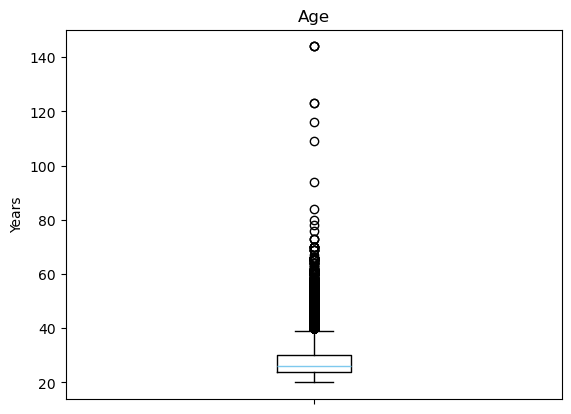

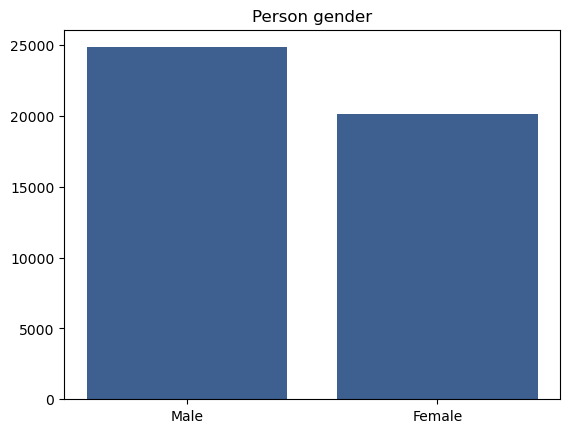

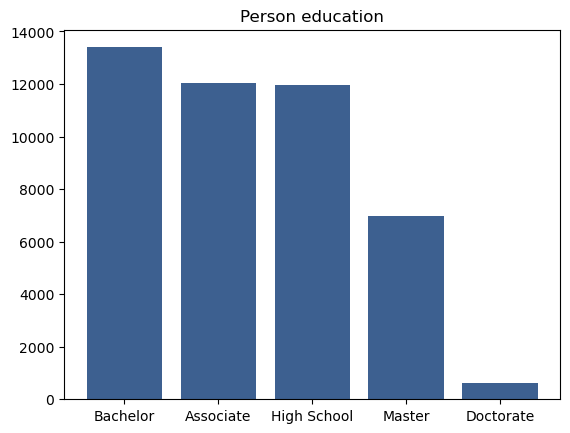

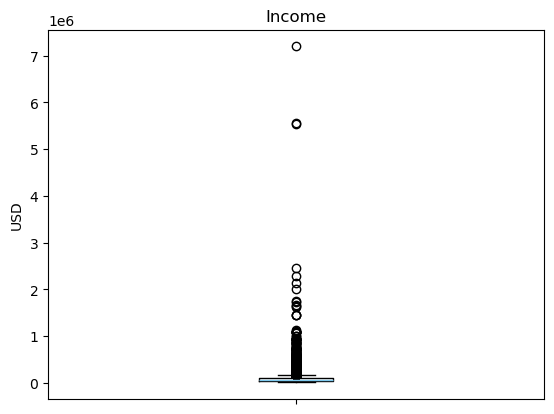

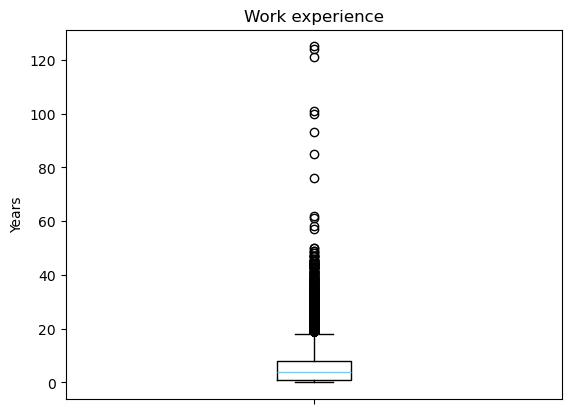

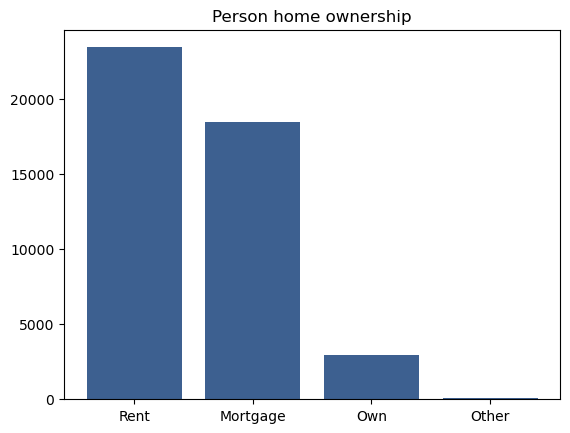

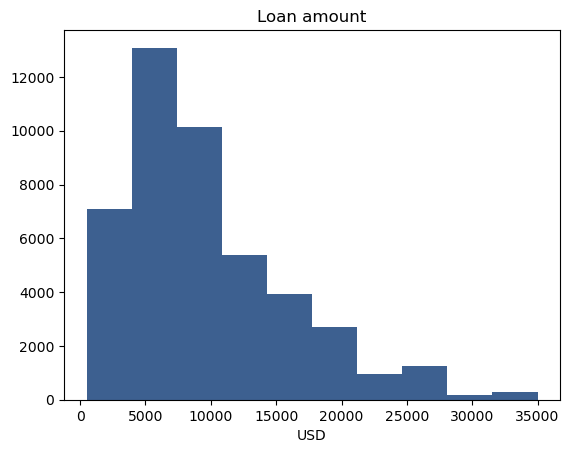

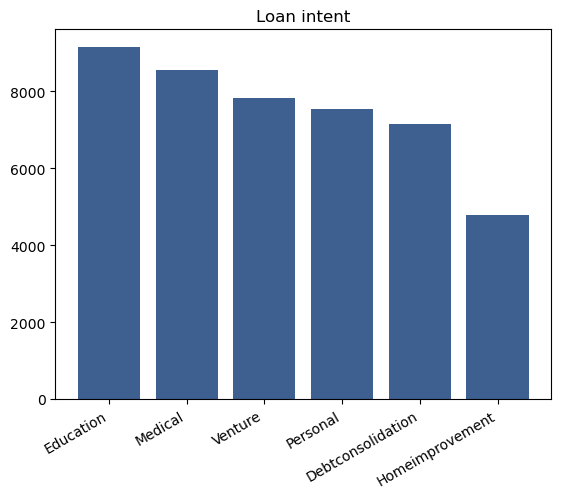

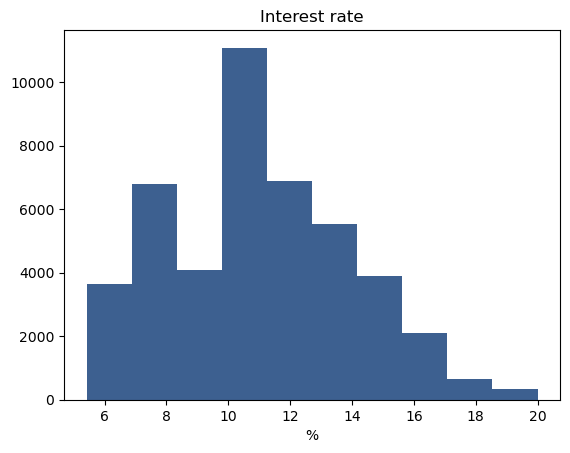

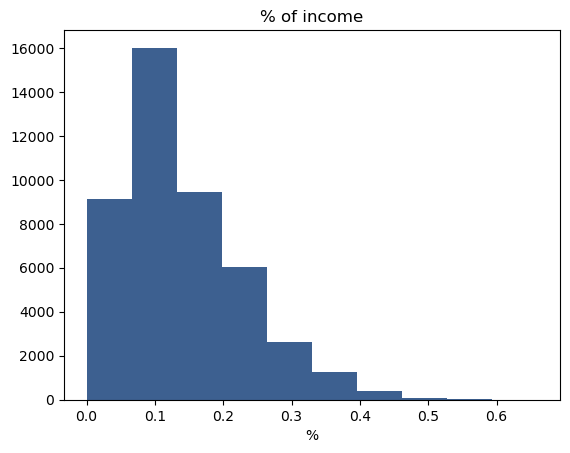

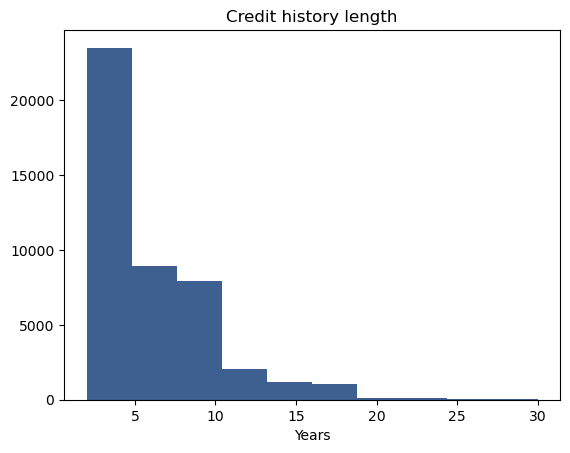

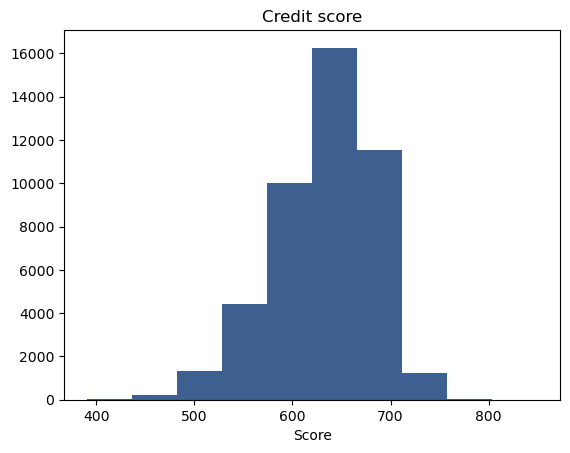

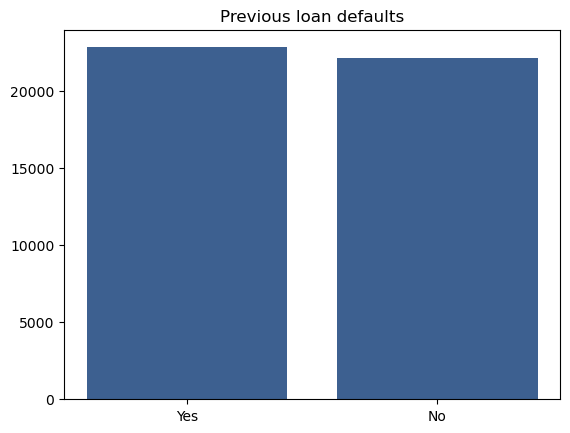

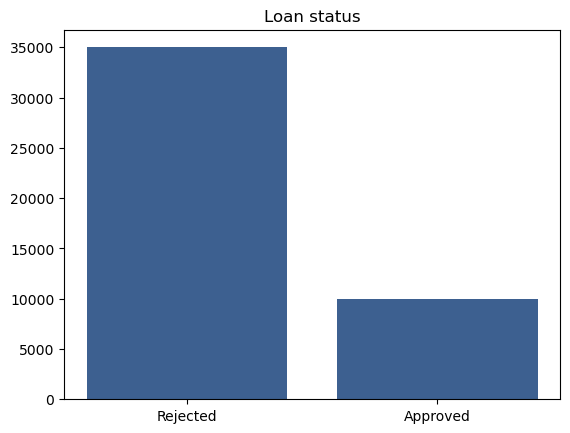

In [447]:
# plt.hist(data["person_age"])
# plt.title("Age")
# plt.xlabel("Years")

plt.boxplot(data["person_age"], tick_labels = [""])
plt.title("Age")
plt.ylabel("Years")
plt.xticks()
# plt.savefig("images/" + "person_age" + ".svg")
plt.show()

counts = data["person_gender"].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Person gender')
plt.xticks(['male', 'female'], ['Male', 'Female'])
# plt.savefig("images/" + "person_gender" + ".svg")
plt.show()

counts = data["person_education"].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Person education')
# plt.savefig("images/" + "person_education" + ".svg")
plt.show()

plt.boxplot(data["person_income"], tick_labels = [""])
plt.title("Income")
plt.ylabel("USD")
plt.xticks()
# plt.savefig("images/" + "person_income" + ".svg")
plt.show()
  
plt.boxplot(data["person_emp_exp"], tick_labels = [""])
plt.title("Work experience")
plt.ylabel("Years")
plt.xticks()
# plt.savefig("images/" + "person_emp_exp" + ".svg")
plt.show()

counts = data["person_home_ownership"].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Person home ownership')
plt.xticks(['RENT', 'MORTGAGE', 'OWN', 'OTHER'], ['Rent', 'Mortgage', 'Own', 'Other'])
# plt.savefig("images/" + "person_home_ownership" + ".svg")
plt.show()

plt.hist(data["loan_amnt"])
plt.title("Loan amount")
plt.xlabel("USD")
# plt.savefig("images/" + "loan_amnt" + ".svg")
plt.show()

counts = data["loan_intent"].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Loan intent')
# I don't like tilted labels tho :(
intents = [intent.lower().capitalize() for intent in data['loan_intent'].value_counts().index.categories]
plt.xticks(data['loan_intent'].value_counts().index.categories, intents, rotation=30, ha="right")
# plt.savefig("images/" + "loan_intent" + ".svg")
plt.show()

plt.hist(data["loan_int_rate"])
plt.title("Interest rate")
plt.xlabel("%")
# plt.savefig("images/" + "loan_int_rate" + ".svg")
plt.show()

plt.hist(data["loan_percent_income"])
plt.title("% of income")
plt.xlabel("%")
# plt.savefig("images/" + "loan_percent_income" + ".svg")
plt.show()

plt.hist(data["cb_person_cred_hist_length"])
plt.title("Credit history length")
plt.xlabel("Years")
# plt.savefig("images/" + "cb_person_cred_hist_length" + ".svg")
plt.show()

plt.hist(data["credit_score"])
plt.title("Credit score")
plt.xlabel("Score")
# plt.savefig("images/" + "credit_score" + ".svg")
plt.show()

counts = data["previous_loan_defaults_on_file"].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Previous loan defaults')
# plt.savefig("images/" + "previous_loan_defaults_on_file" + ".svg")
plt.show()

counts = data["loan_status"].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Loan status')
plt.xticks([0, 1], ['Rejected', 'Approved'])
# plt.savefig("images/" + "loan_status" + ".svg")
plt.show()

# Model

## Preprocessing

In [449]:
def get_label_encd(df_original, columns):
    df = df_original.copy()
    le = preprocessing.LabelEncoder()
    for col in columns:
        if col in df.columns:
            df[col] = le.fit_transform(df[col])
            df[col] = df[col].astype("category")
    
    return df

In [597]:
def get_XY(df_original):
    df = df_original.copy()
    
    df['loan_status'] = df['loan_status'].astype("category")
    
    # Split data into features and target
    X = df.drop("loan_status", axis=1)  # Features
    y = df["loan_status"]  # Target variable

    return X, y

In [453]:
X, y = get_XY(data)
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Label encoded
X_train = get_label_encd(X_train, categoricals)
X_test = get_label_encd(X_test, categoricals)

X_train.dtypes

person_age                         float64
person_gender                     category
person_education                  category
person_income                      float64
person_emp_exp                       int64
person_home_ownership             category
loan_amnt                          float64
loan_intent                       category
loan_int_rate                      float64
loan_percent_income                float64
cb_person_cred_hist_length         float64
credit_score                         int64
previous_loan_defaults_on_file    category
dtype: object

## Random Forest

### Finding optimal parameters

In [454]:
# # This is very slow
# # Used to obtain best parameters for classifier

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     "n_estimators": [50, 100, 200],  # Number of trees
#     "max_depth": [4, 8, 16],  # Maximum depth of each tree
#     "min_samples_split": [2, 5, 10],  # Minimum number of samples to split a node
#     "min_samples_leaf": [1, 2, 4],  # Minimum number of samples in each leaf
#     "max_features": ["sqrt", "log2"],
#     "random_state": [0, 100, 1000]
# }

# # Create the GridSearchCV object
# model = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="balanced_accuracy", n_jobs=-1, verbose=2)

# # Fit the model to the training data
# model.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = model.best_params_
# best_score = model.best_score_


# print("Best parameters:", best_params)
# print("Best Score (balanced accuracy):", best_score)

### Building model

In [455]:
def build_run_RFC(X_train, X_test, y_train, y_test):
    """
    Returns report dictionary
    """
    
    # Building Model
    best_params = {'max_depth': 16,
                   'max_features': 'sqrt',
                   'min_samples_leaf': 4,
                   'min_samples_split': 2,
                   'n_estimators': 100,
                   'random_state': 0} # From previous cell
    clf_rfc = RandomForestClassifier(**best_params)
    
    # Training the model on the training dataset
    clf_rfc.fit(X_train, y_train)
    
    # performing predictions
    y_pred = clf_rfc.predict(X_test)
    report=classification_report(y_test,y_pred)
    dreport_rfc=classification_report(y_test,y_pred,output_dict=True)
    
    print("Classification Report:")
    print(report)
    
    balanced_accuracy=metrics.balanced_accuracy_score(y_test,y_pred)
    print("Balanced accuracy:")
    print(balanced_accuracy)

    print("Feature importance ranking:")
    feature_importance_series = pd.Series(clf_rfc.feature_importances_, index=X_train.columns)
    print(feature_importance_series.sort_values(ascending = False))

    return dreport_rfc, feature_importance_series, balanced_accuracy

In [456]:
dreport_rfc, feature_importance_rfc, balanced_accuracy_rfc = build_run_RFC(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.75      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8621600157509688
Feature importance ranking:
previous_loan_defaults_on_file    0.289309
loan_percent_income               0.180007
loan_int_rate                     0.166373
person_income                     0.124047
person_home_ownership             0.074358
loan_amnt                         0.045335
credit_score                      0.037677
loan_intent                       0.029774
person_age                        0.015702
person_emp_exp                    0.013252
cb_person_cred_hist_length        0.012434
person_education                  0.007805
person_gender                     0.003928
dtype: float64


## Decision Tree Classifier

### Finding optimal parameters

In [460]:
# # Used to obtain best parameters for classifier

# # Define the parameter grid for GridSearchCV
# param_grid = {
#     "max_depth": [4, 8, 16],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2"],
#     "random_state": [0, 100, 1000]
# }

# # Create the GridSearchCV object
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring="balanced_accuracy", n_jobs=-1, verbose=2)

# # Fit the model to the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best score
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_


# print("Best parameters:", best_params)
# print("Best Score (accuracy):", best_score)

### Building model

In [461]:
def build_run_DTC(X_train, X_test, y_train, y_test):
    """
    Returns report dictionary
    """
    
    # Building Model
    best_params = {'max_depth': 16,
                   'max_features': 'sqrt',
                   'min_samples_leaf': 1,
                   'min_samples_split': 2,
                   'random_state': 0} # From previous cell
    clf_dtc = DecisionTreeClassifier(**best_params)
    
    # Training the model on the training dataset
    clf_dtc.fit(X_train, y_train)
    
    # performing predictions
    y_pred = clf_dtc.predict(X_test)
    accuracy=metrics.accuracy_score(y_test,y_pred)
    report=classification_report(y_test,y_pred)
    dreport_dtc=classification_report(y_test,y_pred,output_dict=True)
    
    print("Classification Report:")
    print(report)
    
    balanced_accuracy=metrics.balanced_accuracy_score(y_test,y_pred)
    print("Balanced accuracy:")
    print(balanced_accuracy)

    print("Feature importance ranking:")
    feature_importance_series = pd.Series(clf_dtc.feature_importances_, index=X_train.columns)
    print(feature_importance_series.sort_values(ascending = False))
    
    return dreport_dtc, feature_importance_series, balanced_accuracy

In [462]:
dreport_dtc, feature_importance_dtc, balanced_accuracy_dtc = build_run_DTC(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10533
           1       0.81      0.74      0.77      2967

    accuracy                           0.90     13500
   macro avg       0.87      0.84      0.86     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8442281694096949
Feature importance ranking:
previous_loan_defaults_on_file    0.273817
loan_int_rate                     0.181879
person_income                     0.152936
loan_percent_income               0.125689
person_home_ownership             0.068656
loan_amnt                         0.062560
credit_score                      0.038552
loan_intent                       0.032622
person_emp_exp                    0.019598
person_age                        0.019357
cb_person_cred_hist_length        0.012173
person_education                  0.008760
person_gender                     0.003400
dtype: float64


## SVM

### Finding optimal parameters

In [463]:
# # Define the SVM model and parameter grid to search over
# param_grid = {
#         'C': [0.1, 1, 10, 100],
#         'kernel': ['rbf'],
#         'gamma': ['scale', 'auto']
#     }

# # Perform grid search with cross-validation on the training set
# # n_jobs=-1, n_estimators=32
# random_search = RandomizedSearchCV(svm.SVC(),
#                                    param_distributions=param_grid,
#                                    n_iter=8,
#                                    refit=True,
#                                    scoring="balanced_accuracy",
#                                    n_jobs=-1,
#                                    verbose=2
#                                   )
# random_search.fit(X_train, y_train)

# print("Best parameters: ", random_search.best_params_)
# print("Best score (accuracy):", random_search.best_score_)

### Building model

In [464]:
def build_run_SVM(X_train, X_test, y_train, y_test):
    """
    Returns report dictionary
    """
    if X_train.isnull().sum().sum() > 0:
        imputer = SimpleImputer(strategy='median')
        X_train = imputer.fit_transform(X_train)
    
    # Bulding model
    best_params = {'kernel': 'rbf',
                   'gamma' : 'scale',
                   'C': 100,
                   'random_state' : 0} # From previous cell
    # clf_svm = svm.SVC(**random_search.best_params_)
    clf_svm = svm.SVC(**best_params)

    # print("Shapes")
    # print(X_train.shape)
    # print(y_train.shape)
    
    # Train the model using the training data
    clf_svm.fit(X_train, y_train)
    
    # Predicting the response for test dataset
    y_pred = clf_svm.predict(X_test)
    
    # performing predictions
    accuracy=metrics.accuracy_score(y_test,y_pred)
    report=classification_report(y_test,y_pred)
    dreport_svm=classification_report(y_test,y_pred,output_dict=True)
    
    print("Classification Report:")
    print(report)
    
    balanced_accuracy=metrics.balanced_accuracy_score(y_test,y_pred)
    print("Balanced accuracy:")
    print(balanced_accuracy)

    return dreport_svm, None, balanced_accuracy

In [465]:
dreport_svm, feature_importance_svm, balanced_accuracy_svm = build_run_SVM(X_train, X_test, y_train, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10533
           1       0.74      0.26      0.38      2967

    accuracy                           0.82     13500
   macro avg       0.78      0.62      0.64     13500
weighted avg       0.80      0.82      0.78     13500

Balanced accuracy:
0.616006298083629


### Experimental imputer

In [468]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def build_run_SVM_exp(X_train, X_test, y_train, y_test):
    """
    Returns report dictionary
    """
    if X_train.isnull().sum().sum() > 0:
        imputer = IterativeImputer(max_iter=10, random_state=0)
        X_train = imputer.fit_transform(X_train)
    
    # Bulding model
    best_params = {'kernel': 'rbf',
                   'gamma' : 'scale',
                   'C': 100,
                   'random_state' : 0} # From previous cell
    # clf_svm = svm.SVC(**random_search.best_params_)
    clf_svm = svm.SVC(**best_params)

    # print("Shapes")
    # print(X_train.shape)
    # print(y_train.shape)
    
    # Train the model using the training data
    clf_svm.fit(X_train, y_train)
    
    # Predicting the response for test dataset
    y_pred = clf_svm.predict(X_test)
    
    # performing predictions
    accuracy=metrics.accuracy_score(y_test,y_pred)
    report=classification_report(y_test,y_pred)
    dreport_svm=classification_report(y_test,y_pred,output_dict=True)
    
    print("Classification Report:")
    print(report)
    
    balanced_accuracy=metrics.balanced_accuracy_score(y_test,y_pred)
    print("Balanced accuracy:")
    print(balanced_accuracy)

    return dreport_svm, None, balanced_accuracy

## Model evaluation

In [469]:
def plot_model_report(dreport, model_name = "", filePrefix = ""):
    """
    Input from classification_report(y_test,y_pred,output_dict=True) 
    """

    dreport_truncated = {key: dreport[key] for key in list(dreport.keys())[:2]}
    # Prepare data for plotting
    categories = list(dreport_truncated.keys())
    metrics = ['precision', 'recall', 'f1-score']
    values = {metric: [dreport_truncated[category][metric] for category in categories] for metric in metrics}
    
    # Number of groups and bar width
    num_groups = len(categories)
    bar_width = 0.25
    
    # Create an index for the groups
    index = range(num_groups)
    
    # Plotting
    fig, ax = plt.subplots()
    for i, metric in enumerate(metrics):
        offset = (i - (len(metrics) - 1) / 2) * bar_width
        bars = ax.bar([x + offset for x in index], values[metric], bar_width, label=metric)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Categories')
    ax.set_ylabel('Score')
    title = 'Model report'
    if model_name != "":
       title = title + ' for ' + model_name
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 1.1)
    ax.legend()
    
    plt.tight_layout()

    # if filePrefix != "":
    #     plt.savefig("images/" + filePrefix + ".svg")
    #     plt.savefig("images/" + filePrefix + ".png")

    plt.show()

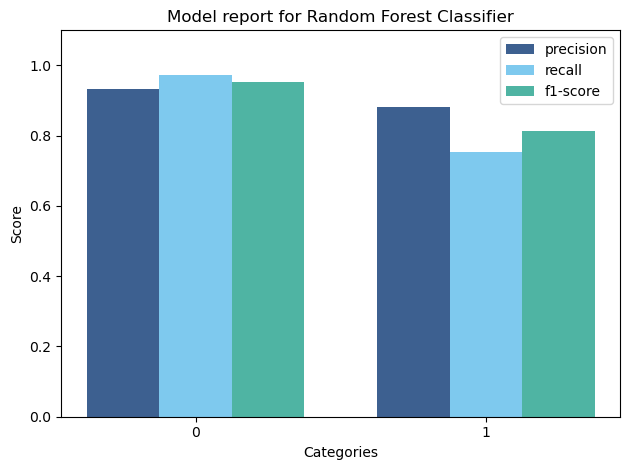

In [470]:
plot_model_report(dreport_rfc, "Random Forest Classifier", "rfc_report_base")

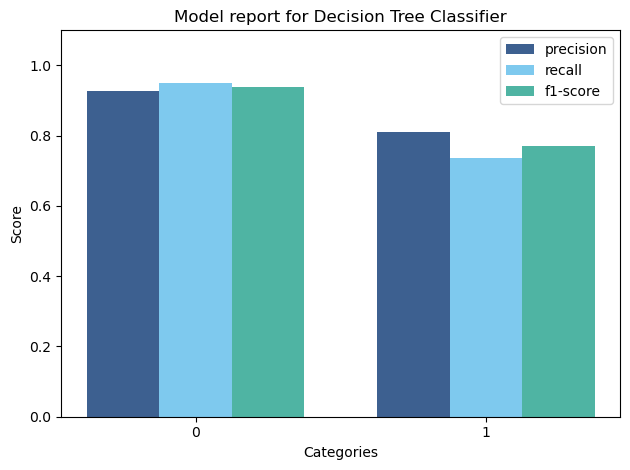

In [471]:
plot_model_report(dreport_dtc, "Decision Tree Classifier", "dtc_report_base")

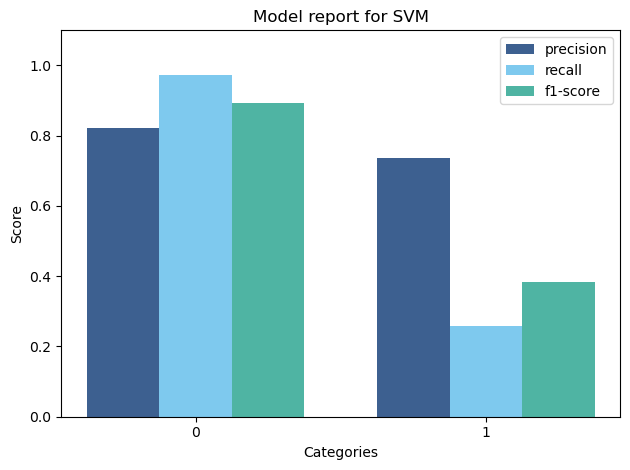

In [472]:
plot_model_report(dreport_svm, "SVM", "svm_report_base")

In [474]:
def plot_model_starter_accuracies(accuracies, title = "", filePrefix = "", yLabel = "", balanced = False):
    """
    Creates bar chart comparing accuracies of models grouped by model
    """
    models = ["RFC",
              "DTC",
              "SVM",
             ]
    
    x = np.arange(len(models))  # the label locations
    width = 0.35  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')
    
    for portion, accuracy in accuracies.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, accuracy, width, label=portion)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Score')
    
    plotTitle = "Models' accuracies "
    if title != "":
        plotTitle = plotTitle + title
        ax.set_title(plotTitle)
    ax.set_xticks(x + width * 1 / 2, models)
    ax.legend(loc='upper left', ncols=4)
    ax.set_ylim(0, 1.1)
    
    # plt.tight_layout()

    if filePrefix != "":
        plt.savefig("images/" + filePrefix + ".svg")
    #     plt.savefig("images/" + filePrefix + ".png")

    plt.show()

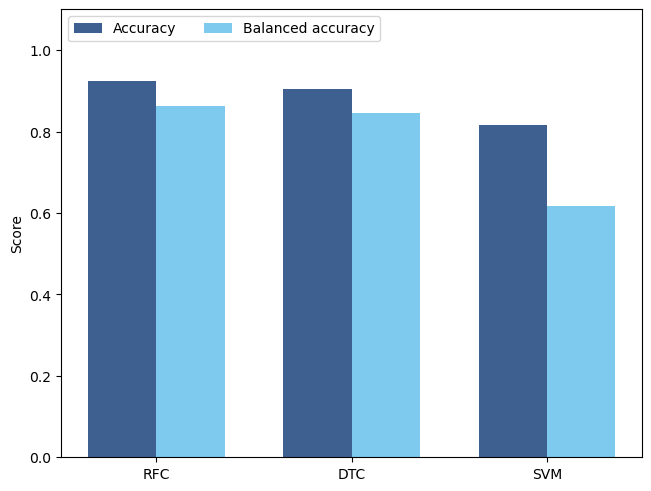

In [475]:
balanced_accuracies = {}
balanced_accuracies['Accuracy'] = [dreport_rfc['accuracy'], dreport_dtc['accuracy'], dreport_svm['accuracy']]
balanced_accuracies['Balanced accuracy'] = [balanced_accuracy_rfc, balanced_accuracy_dtc, balanced_accuracy_svm]
plot_model_starter_accuracies(
    balanced_accuracies,
    filePrefix = "model_accuracies_base"
)

# Dirty data

## Missing data

In [476]:
missing_values = data.isnull().sum()
print(missing_values)

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


### At random

In [477]:
def remove_entries(df, fraction):
    """
    Randomly sets a fraction of the dataframe values to None.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    fraction (float): The fraction of entries to set to None.

    Returns:
    pd.DataFrame: A new DataFrame with some entries set to None.
    """
    # Create a mask where each element has a probability `fraction` of being True
    mask = np.random.rand(*df.shape) < fraction
    
    # Set the values in the DataFrame where the mask is True to None
    df_random_nulls = df.copy()
    df_random_nulls[mask] = None
    
    return df_random_nulls

#### Missing data visualization

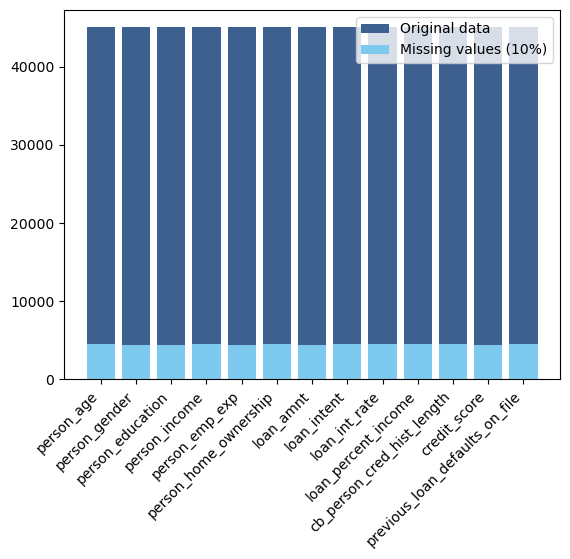

In [584]:
X, y = get_XY(data)
X_removed = remove_entries(X, 0.1)

plt.bar(X.columns, len(X), label="Original data")
plt.bar(X.columns, X_removed.isnull().sum(), label="Missing values (10%)")
plt.xticks(rotation=45, ha="right")
plt.legend()
# plt.savefig("images/distribution_missing.svg")
plt.show()

In [480]:
# missing_values = X_train.isnull().sum()
# print(missing_values)

In [481]:
# total_missing_values = X_train.isnull().sum().sum()
# print(X_train.size - total_missing_values)
# print(str(100 * total_missing_values / X_train.size) + "%")

#### Running models

In [482]:
accuracies = {}

In [483]:
def run_models_with_portion_dirty_data(dirty_function,
                                       portion_array = [0.1, 0.3, 0.5, 0.8],
                                       feature_importance = None,
                                       modifies_target = False,
                                       dirty_type = "dirty",
                                       file_suffix = "dirty",
                                       aux_function = None,
                                       numerical_only = True,
                                       experimental = False,
                                      ):
    accuracies = {}
    balanced_accuracies = {}
    for portion in portion_array:
        original_data = data.copy()
        # print(original_data.size)
        
        # Dataset split
        X, y = get_XY(original_data)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

        # Make data dirty
        if not modifies_target:    
            if feature_importance is not None:
                if aux_function is not None:
                    X_train = dirty_function(
                        df = X_train,
                        fraction = portion,
                        feature_importance = feature_importance,
                        dirty_function = aux_function,
                        numerical_only = numerical_only,
                    )
                else:
                    X_train = dirty_function(X_train, portion, feature_importance = feature_importance)
            else:
                X_train = dirty_function(X_train, portion)
        else:            
            X_train, y_train = dirty_function(X_train, y_train, portion)
        
        print("Dirty portion: " + str(portion))
        total_missing_values = X_train.isnull().sum().sum()
        print("Missing percentage: " + str(100 * total_missing_values / X_train.size) + "%")

        # Label encoded
        X_train = get_label_encd(X_train, categoricals)
        X_test = get_label_encd(X_test, categoricals)

        # RFC
        dreport_dirty_rfc, _, balanced_accuracy_dirty_rfc = build_run_RFC(X_train, X_test, y_train, y_test)
        plot_model_report(dreport_dirty_rfc,
                          "Random Forest Classifier with " + str(int(portion * 100)) + "% of data " + dirty_type,
                          "rfc_report_" + str(portion) + "_" + file_suffix)
        # DTC
        dreport_dirty_dtc, _, balanced_accuracy_dirty_dtc = build_run_DTC(X_train, X_test, y_train, y_test)
        plot_model_report(dreport_dirty_dtc,
                          "Decision Tree Classifier with " + str(int(portion * 100)) + "% of data " + dirty_type,
                          "dtc_report_" + str(portion) + "_" + file_suffix)
        # SVM
        if experimental:
            dreport_dirty_svm, _, balanced_accuracy_dirty_svm = build_run_SVM_exp(X_train, X_test, y_train, y_test)
            plot_model_report(dreport_dirty_svm,
                              "Support Vector Machine EXP with " + str(int(portion * 100)) + "% of data " + dirty_type,
                              "svm_report_" + str(portion) + "_" + file_suffix)
        else:
            dreport_dirty_svm, _, balanced_accuracy_dirty_svm = build_run_SVM(X_train, X_test, y_train, y_test)
            plot_model_report(dreport_dirty_svm,
                              "Support Vector Machine with " + str(int(portion * 100)) + "% of data " + dirty_type,
                              "svm_report_" + str(portion) + "_" + file_suffix)
            
        accuracies[portion] = (dreport_dirty_rfc['accuracy'],
                               dreport_dirty_dtc['accuracy'],
                               dreport_dirty_svm['accuracy'],
                              )

        balanced_accuracies[portion] = (balanced_accuracy_dirty_rfc,
                                        balanced_accuracy_dirty_dtc,
                                        balanced_accuracy_dirty_svm,
                                       )
    
    return accuracies, balanced_accuracies

Dirty portion: 0.1
Missing percentage: 10.108669108669108%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.87      0.75      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8602991877710737
Feature importance ranking:
previous_loan_defaults_on_file    0.265579
loan_percent_income               0.182394
loan_int_rate                     0.156915
person_income                     0.129075
person_home_ownership             0.067922
loan_amnt                         0.052032
credit_score                      0.045315
loan_intent                       0.025619
person_age                        0.021713
person_emp_exp                    0.020105
cb_person_cred_hist_length        0.018533
person_education                  0.009481
person_ge

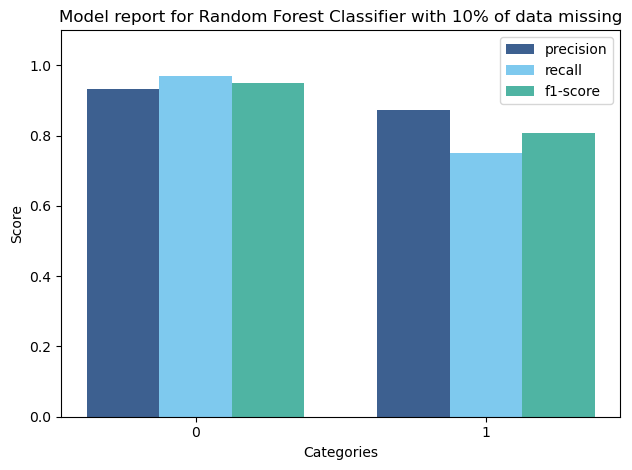

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10533
           1       0.78      0.72      0.75      2967

    accuracy                           0.89     13500
   macro avg       0.85      0.83      0.84     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8299609576028424
Feature importance ranking:
previous_loan_defaults_on_file    0.253125
loan_int_rate                     0.175328
loan_percent_income               0.161331
person_income                     0.143871
person_home_ownership             0.052837
credit_score                      0.047215
loan_amnt                         0.041806
loan_intent                       0.035704
person_age                        0.023789
person_emp_exp                    0.021837
cb_person_cred_hist_length        0.020196
person_education                  0.013440
person_gender                     0.009521
dtype: float64


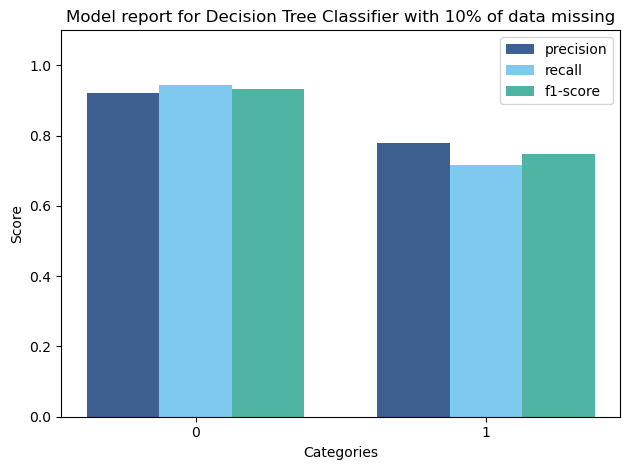

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10533
           1       0.77      0.21      0.33      2967

    accuracy                           0.81     13500
   macro avg       0.79      0.59      0.61     13500
weighted avg       0.80      0.81      0.77     13500

Balanced accuracy:
0.5945210761843681


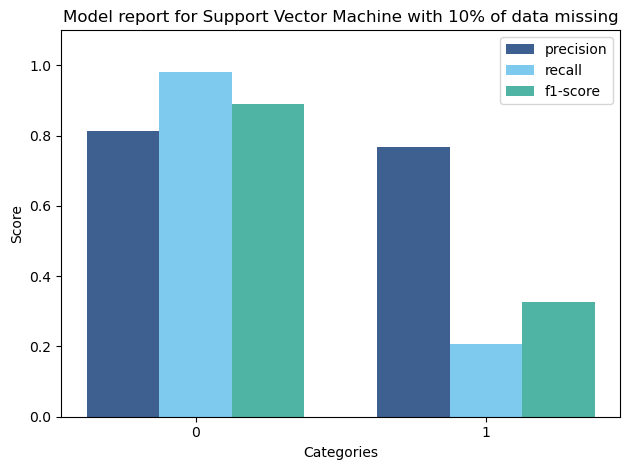

Dirty portion: 0.3
Missing percentage: 29.894505494505495%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.86      0.75      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8596013952778004
Feature importance ranking:
previous_loan_defaults_on_file    0.243380
loan_percent_income               0.184046
loan_int_rate                     0.151156
person_income                     0.127694
person_home_ownership             0.064783
loan_amnt                         0.052560
credit_score                      0.048189
person_age                        0.027752
person_emp_exp                    0.027345
cb_person_cred_hist_length        0.025180
loan_intent                       0.025003
person_education                  0.014252
person_ge

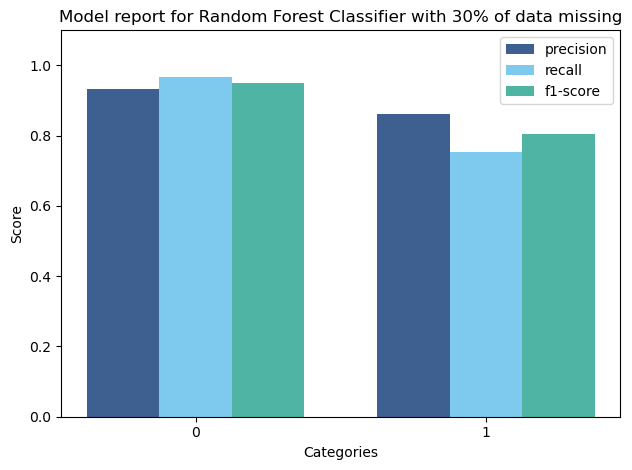

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     10533
           1       0.73      0.69      0.71      2967

    accuracy                           0.88     13500
   macro avg       0.82      0.81      0.82     13500
weighted avg       0.87      0.88      0.87     13500

Balanced accuracy:
0.8104150881379404
Feature importance ranking:
previous_loan_defaults_on_file    0.211025
loan_int_rate                     0.166387
loan_percent_income               0.163547
person_income                     0.141105
person_home_ownership             0.062714
loan_amnt                         0.052663
credit_score                      0.052543
person_emp_exp                    0.031785
loan_intent                       0.029925
person_age                        0.029702
cb_person_cred_hist_length        0.027656
person_education                  0.017867
person_gender                     0.013080
dtype: float64


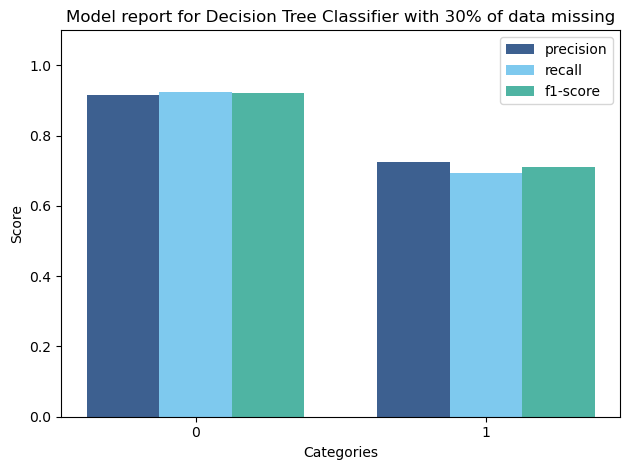

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10533
           1       0.82      0.11      0.20      2967

    accuracy                           0.80     13500
   macro avg       0.81      0.55      0.54     13500
weighted avg       0.80      0.80      0.73     13500

Balanced accuracy:
0.5534945926121544


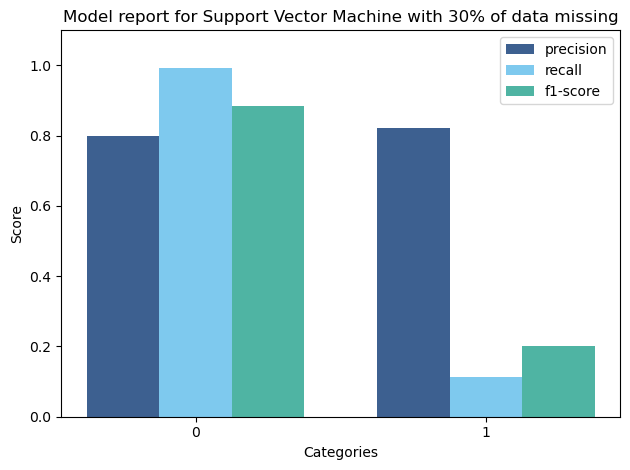

Dirty portion: 0.5
Missing percentage: 49.924786324786325%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     10533
           1       0.83      0.76      0.80      2967

    accuracy                           0.91     13500
   macro avg       0.88      0.86      0.87     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8583363643964748
Feature importance ranking:
previous_loan_defaults_on_file    0.236074
loan_percent_income               0.174883
loan_int_rate                     0.160700
person_income                     0.130790
person_home_ownership             0.061577
loan_amnt                         0.058072
credit_score                      0.045820
person_age                        0.028701
person_emp_exp                    0.027933
cb_person_cred_hist_length        0.026196
loan_intent                       0.023045
person_education                  0.015211
person_ge

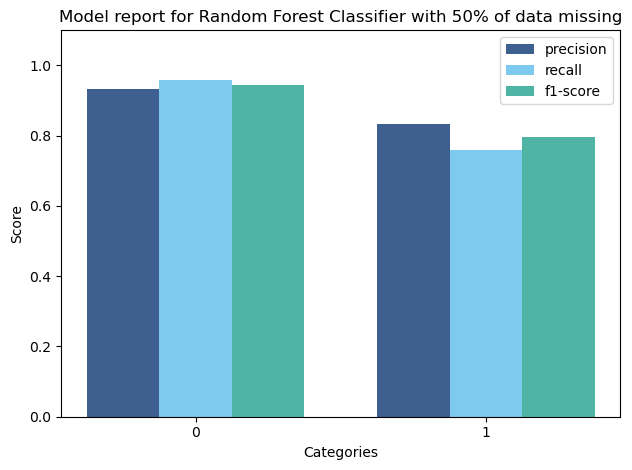

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     10533
           1       0.72      0.70      0.71      2967

    accuracy                           0.87     13500
   macro avg       0.82      0.81      0.82     13500
weighted avg       0.87      0.87      0.87     13500

Balanced accuracy:
0.8124041183292492
Feature importance ranking:
previous_loan_defaults_on_file    0.227631
loan_int_rate                     0.174898
loan_percent_income               0.144479
person_income                     0.137601
person_home_ownership             0.060430
loan_amnt                         0.060107
credit_score                      0.047787
person_emp_exp                    0.034544
person_age                        0.028422
cb_person_cred_hist_length        0.027532
loan_intent                       0.024154
person_education                  0.020437
person_gender                     0.011976
dtype: float64


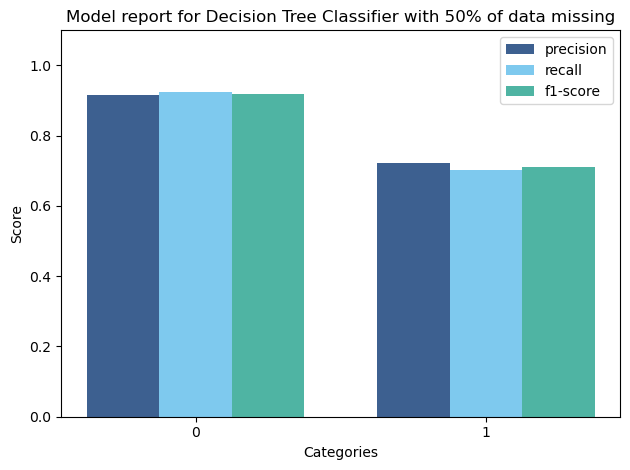

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     10533
           1       0.84      0.09      0.16      2967

    accuracy                           0.80     13500
   macro avg       0.82      0.54      0.52     13500
weighted avg       0.80      0.80      0.72     13500

Balanced accuracy:
0.5408151971122199


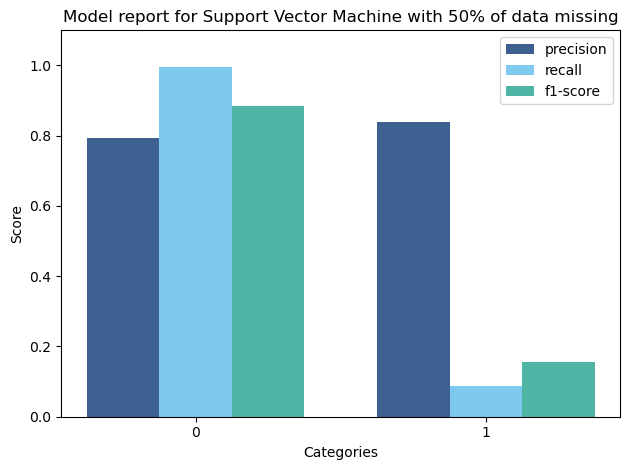

Dirty portion: 0.8
Missing percentage: 79.95433455433455%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10533
           1       0.82      0.74      0.77      2967

    accuracy                           0.91     13500
   macro avg       0.87      0.85      0.86     13500
weighted avg       0.90      0.91      0.90     13500

Balanced accuracy:
0.8451514557214712
Feature importance ranking:
previous_loan_defaults_on_file    0.260513
loan_percent_income               0.195306
loan_int_rate                     0.153212
person_income                     0.124078
person_home_ownership             0.058961
loan_amnt                         0.047670
credit_score                      0.039733
cb_person_cred_hist_length        0.025939
person_age                        0.024915
loan_intent                       0.022627
person_emp_exp                    0.022600
person_education                  0.013934
person_gen

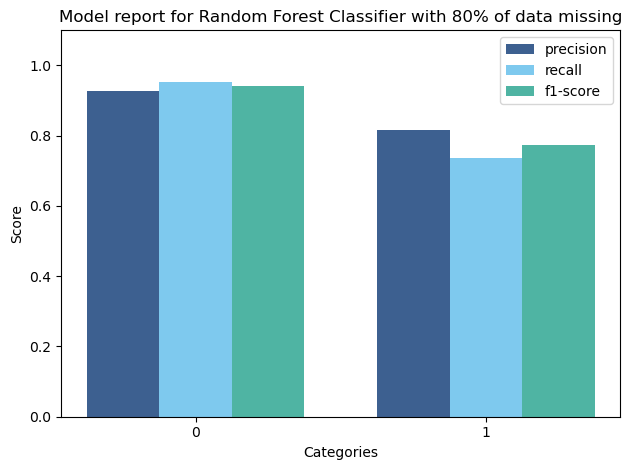

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     10533
           1       0.54      0.55      0.55      2967

    accuracy                           0.80     13500
   macro avg       0.71      0.71      0.71     13500
weighted avg       0.80      0.80      0.80     13500

Balanced accuracy:
0.7102218200643804
Feature importance ranking:
previous_loan_defaults_on_file    0.242636
loan_percent_income               0.194919
loan_int_rate                     0.160771
person_income                     0.131474
person_home_ownership             0.059999
loan_amnt                         0.040234
credit_score                      0.038536
cb_person_cred_hist_length        0.025511
person_age                        0.025048
person_education                  0.022479
loan_intent                       0.022140
person_emp_exp                    0.018208
person_gender                     0.018044
dtype: float64


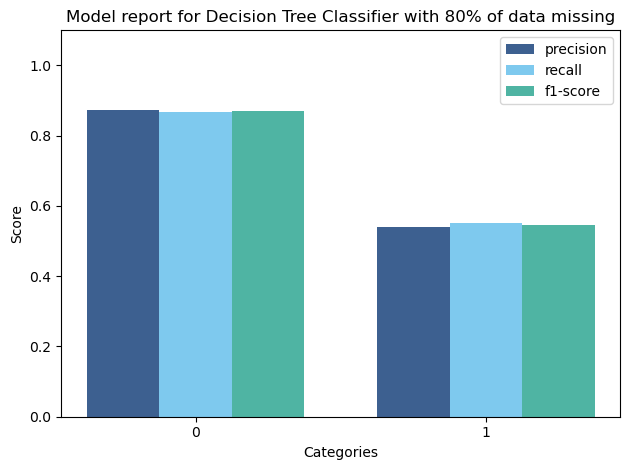

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     10533
           1       0.78      0.07      0.12      2967

    accuracy                           0.79     13500
   macro avg       0.78      0.53      0.50     13500
weighted avg       0.79      0.79      0.71     13500

Balanced accuracy:
0.530203164266727


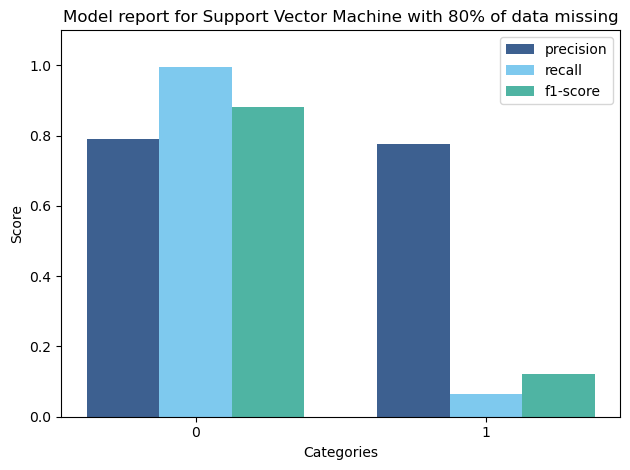

In [485]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(remove_entries,
                                       dirty_type = "missing",
                                       file_suffix = "missing")

In [486]:
def plot_model_accuracies(accuracies, title = "", filePrefix = "", yLabel = "", balanced = False):
    """
    Creates bar chart comparing accuracies of models grouped by model
    """
    models = ["RFC",
              "DTC",
              "SVM",
             ]
    
    x = np.arange(len(models))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')
    
    for portion, accuracy in accuracies.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, accuracy, width, label=portion)
        multiplier += 1

    # Plot models' accuracies with the original data
    if balanced:
        initial_accuracies = [balanced_accuracy_rfc, balanced_accuracy_dtc, balanced_accuracy_svm]
        # lineLabel = "Initial balanced accuracy"
    else:
        initial_accuracies = [dreport_rfc['accuracy'], dreport_dtc['accuracy'], dreport_svm['accuracy']]
        # lineLabel = "Initial accuracy"

    lineLabel = "Initial score"
    ax.hlines(initial_accuracies,
              [-(width/2), -(width/2) + 5 * width, -(width/2) + 10 * width],
              [width * 3.5, width * 8.5, width * 13.5],
              label=lineLabel
             )
    
    if balanced:
        ax.set_ylabel('Balanced accuracy')
    else:
        ax.set_ylabel('Accuracy')
    
    plotTitle = "Models'"
    if balanced:
        plotTitle = plotTitle + " balanced"
    plotTitle = plotTitle + " accuracies "
    if title != "":
        plotTitle = plotTitle + title
        ax.set_title(plotTitle)
    ax.set_xticks(x + width * 3 / 2, models)
    ax.legend(loc='upper left', ncols=5)
    ax.set_ylim(0, 1.1)

    if filePrefix != "":
        plt.savefig("images/" + filePrefix + ".svg")
    #     plt.savefig("images/" + filePrefix + ".png")

    plt.show()

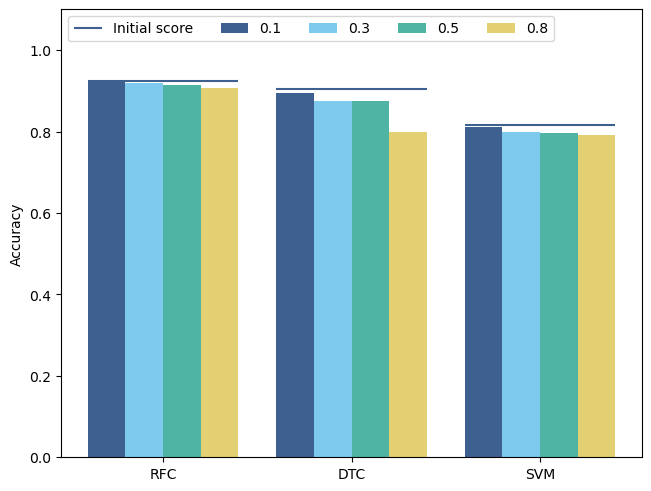

In [487]:
plot_model_accuracies(accuracies,
                      # title = "random missing data",
                      filePrefix = "report_missing")

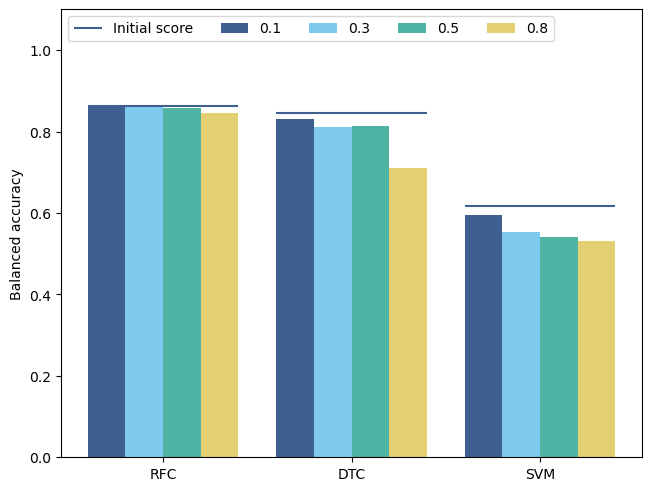

In [488]:
plot_model_accuracies(balanced_accuracies,
                      # title = "random missing data",
                      filePrefix = "report_missing_balanced",
                      balanced=True)

In [489]:
# dreport_svm = build_run_SVM(X_train, X_test, y_train, y_test)

#### Experimental imputer

Dirty portion: 0.1
Missing percentage: 10.044932844932845%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10533
           1       0.88      0.76      0.82      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.87      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8660668473497084
Feature importance ranking:
previous_loan_defaults_on_file    0.264013
loan_percent_income               0.186923
loan_int_rate                     0.159660
person_income                     0.125598
person_home_ownership             0.069967
loan_amnt                         0.048353
credit_score                      0.043264
loan_intent                       0.026643
person_age                        0.021386
person_emp_exp                    0.020088
cb_person_cred_hist_length        0.018506
person_education                  0.009993
person_ge

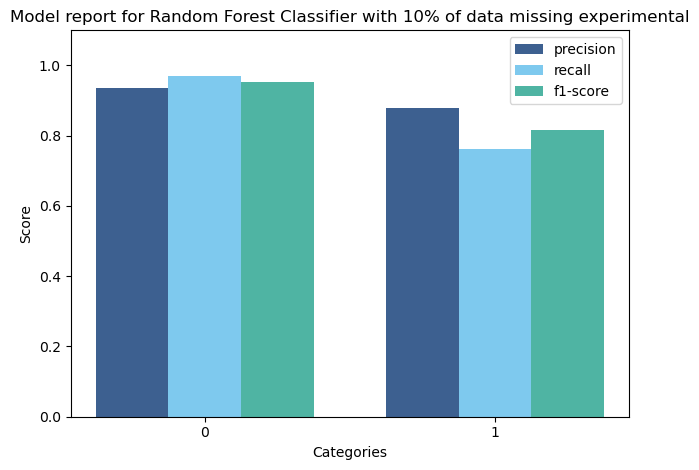

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     10533
           1       0.77      0.74      0.76      2967

    accuracy                           0.90     13500
   macro avg       0.85      0.84      0.85     13500
weighted avg       0.89      0.90      0.89     13500

Balanced accuracy:
0.8409219346928047
Feature importance ranking:
previous_loan_defaults_on_file    0.251836
loan_int_rate                     0.178333
loan_percent_income               0.168070
person_income                     0.150760
person_home_ownership             0.058419
credit_score                      0.053140
loan_amnt                         0.031448
loan_intent                       0.028109
person_emp_exp                    0.023083
cb_person_cred_hist_length        0.020408
person_age                        0.019423
person_education                  0.010473
person_gender                     0.006496
dtype: float64


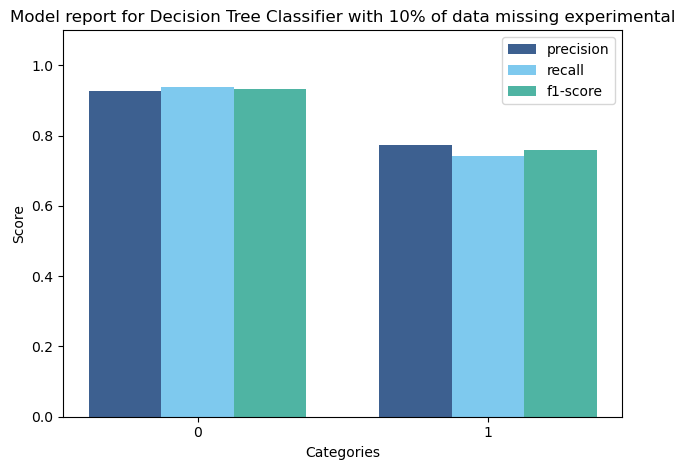

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     10533
           1       0.78      0.16      0.26      2967

    accuracy                           0.80     13500
   macro avg       0.79      0.57      0.57     13500
weighted avg       0.80      0.80      0.75     13500

Balanced accuracy:
0.5713482984816269


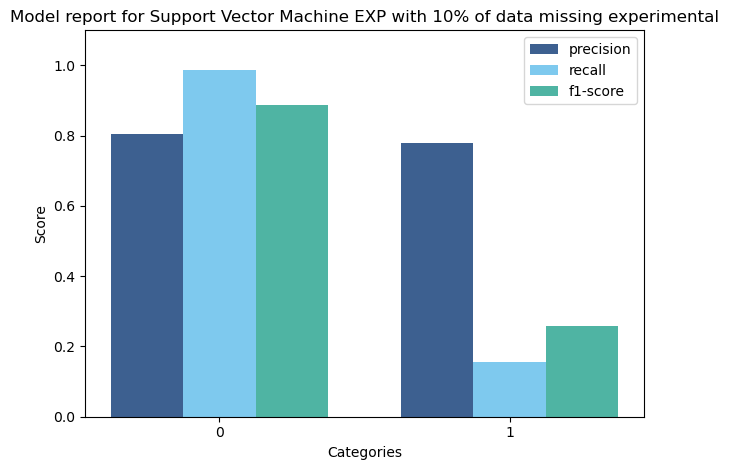

Dirty portion: 0.3
Missing percentage: 30.0991452991453%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.86      0.75      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8580847117590946
Feature importance ranking:
previous_loan_defaults_on_file    0.237083
loan_percent_income               0.180359
loan_int_rate                     0.154199
person_income                     0.131256
person_home_ownership             0.061270
loan_amnt                         0.055990
credit_score                      0.049067
person_age                        0.028330
person_emp_exp                    0.027015
loan_intent                       0.026101
cb_person_cred_hist_length        0.025766
person_education                  0.014151
person_gend

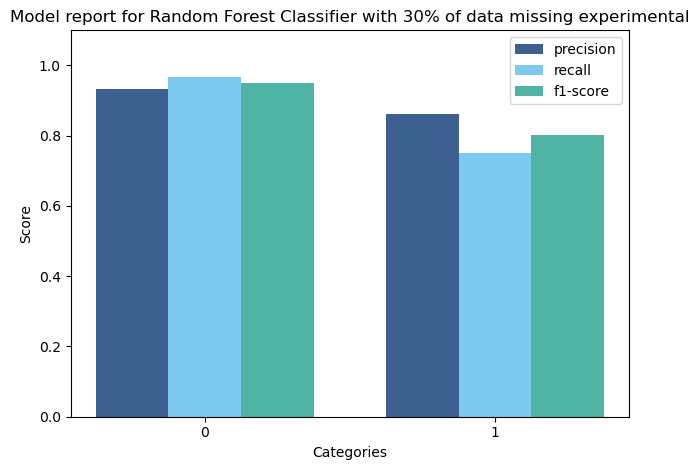

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10533
           1       0.76      0.70      0.73      2967

    accuracy                           0.89     13500
   macro avg       0.84      0.82      0.83     13500
weighted avg       0.88      0.89      0.88     13500

Balanced accuracy:
0.8177135905959574
Feature importance ranking:
previous_loan_defaults_on_file    0.220658
loan_int_rate                     0.163963
loan_percent_income               0.147260
person_income                     0.143673
loan_amnt                         0.069114
person_home_ownership             0.064662
credit_score                      0.046044
person_emp_exp                    0.032605
person_age                        0.031311
loan_intent                       0.027398
cb_person_cred_hist_length        0.025771
person_education                  0.014971
person_gender                     0.012570
dtype: float64


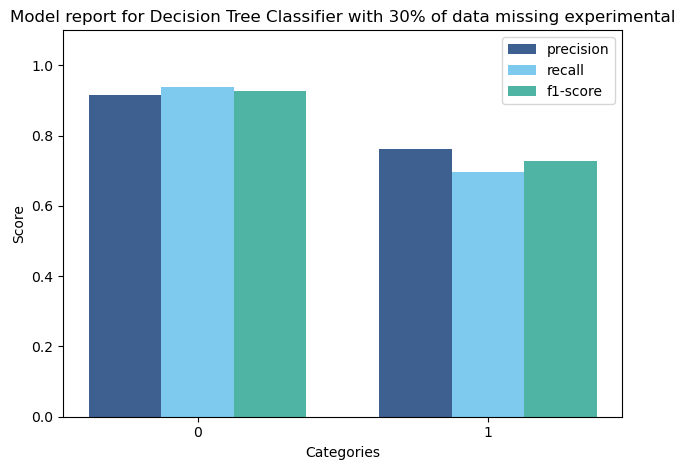

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.72      0.02      0.04      2967

    accuracy                           0.78     13500
   macro avg       0.75      0.51      0.46     13500
weighted avg       0.77      0.78      0.69     13500

Balanced accuracy:
0.5085613254390338


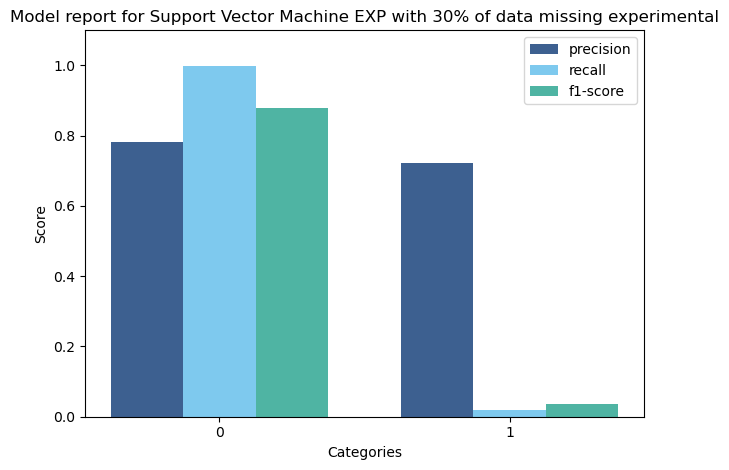

Dirty portion: 0.5
Missing percentage: 49.914041514041514%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10533
           1       0.83      0.77      0.80      2967

    accuracy                           0.91     13500
   macro avg       0.88      0.86      0.87     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8604678041577066
Feature importance ranking:
previous_loan_defaults_on_file    0.232275
loan_percent_income               0.199030
loan_int_rate                     0.153604
person_income                     0.125177
loan_amnt                         0.052260
person_home_ownership             0.052134
credit_score                      0.047353
person_age                        0.030960
person_emp_exp                    0.029019
cb_person_cred_hist_length        0.026812
loan_intent                       0.023945
person_education                  0.016045
person_ge

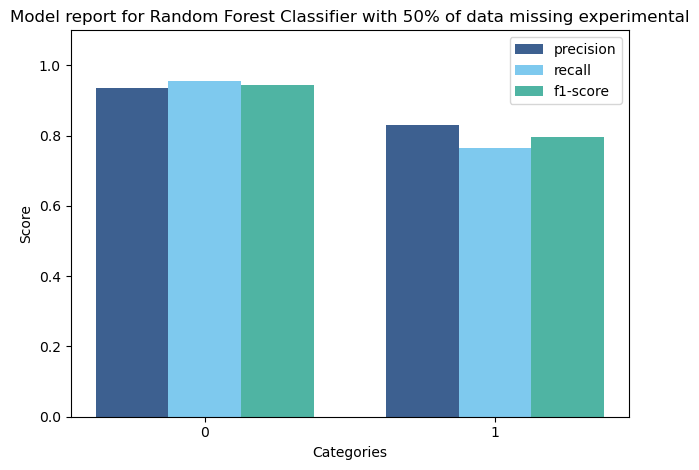

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     10533
           1       0.65      0.67      0.66      2967

    accuracy                           0.85     13500
   macro avg       0.78      0.78      0.78     13500
weighted avg       0.85      0.85      0.85     13500

Balanced accuracy:
0.7847242481307484
Feature importance ranking:
previous_loan_defaults_on_file    0.182266
loan_percent_income               0.174383
person_income                     0.164343
loan_int_rate                     0.161004
loan_amnt                         0.072740
person_home_ownership             0.047089
credit_score                      0.046008
person_age                        0.033384
loan_intent                       0.030535
person_emp_exp                    0.029123
cb_person_cred_hist_length        0.024744
person_education                  0.021159
person_gender                     0.013222
dtype: float64


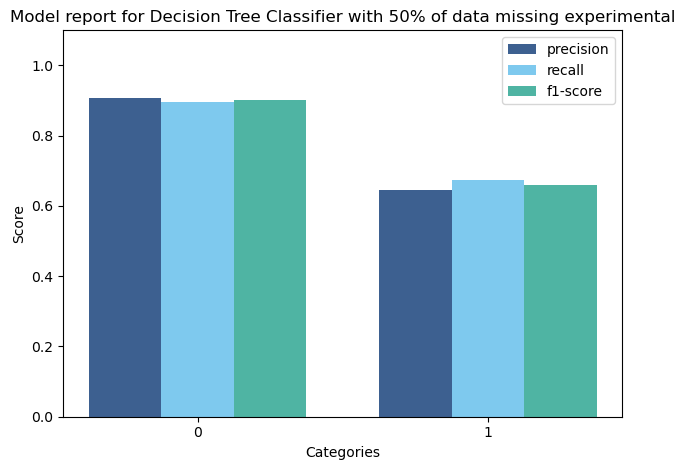

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.62      0.00      0.01      2967

    accuracy                           0.78     13500
   macro avg       0.70      0.50      0.44     13500
weighted avg       0.74      0.78      0.69     13500

Balanced accuracy:
0.5011108138445333


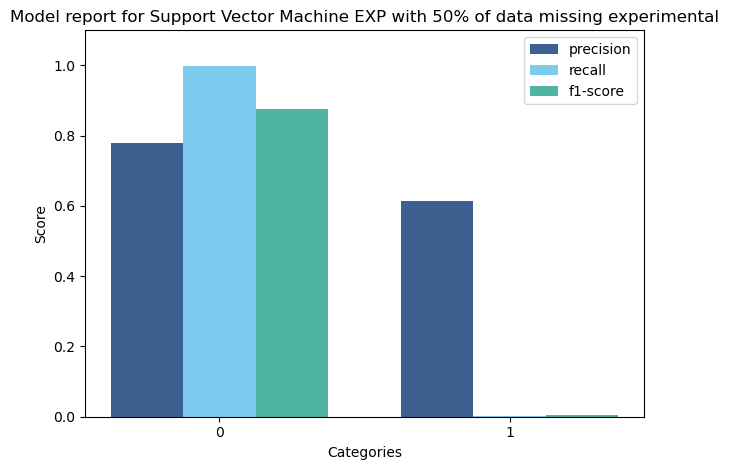

Dirty portion: 0.8
Missing percentage: 80.11233211233211%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10533
           1       0.85      0.71      0.77      2967

    accuracy                           0.91     13500
   macro avg       0.88      0.84      0.86     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8379287418414484
Feature importance ranking:
previous_loan_defaults_on_file    0.254562
loan_percent_income               0.194282
loan_int_rate                     0.152751
person_income                     0.141579
person_home_ownership             0.061646
loan_amnt                         0.047737
credit_score                      0.032648
person_age                        0.025379
person_emp_exp                    0.024530
cb_person_cred_hist_length        0.021763
loan_intent                       0.019992
person_education                  0.012944
person_gen

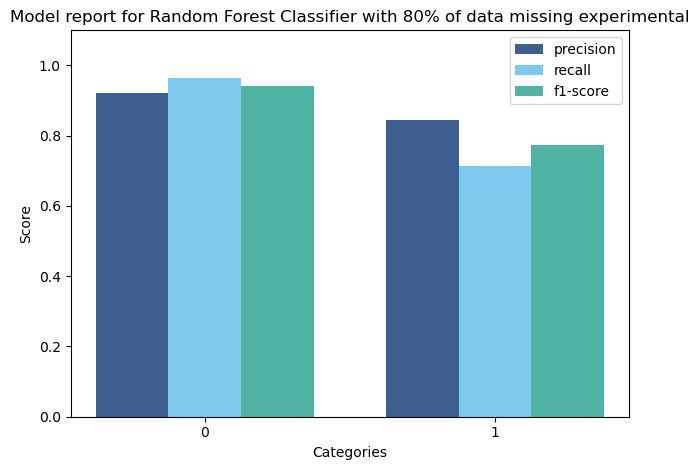

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     10533
           1       0.49      0.50      0.49      2967

    accuracy                           0.77     13500
   macro avg       0.67      0.67      0.67     13500
weighted avg       0.78      0.77      0.77     13500

Balanced accuracy:
0.6738405187528973
Feature importance ranking:
previous_loan_defaults_on_file    0.229416
loan_percent_income               0.203428
loan_int_rate                     0.156167
person_income                     0.148459
loan_amnt                         0.052146
person_home_ownership             0.050572
credit_score                      0.033937
loan_intent                       0.026762
person_emp_exp                    0.023512
person_age                        0.022326
cb_person_cred_hist_length        0.020940
person_education                  0.016563
person_gender                     0.015771
dtype: float64


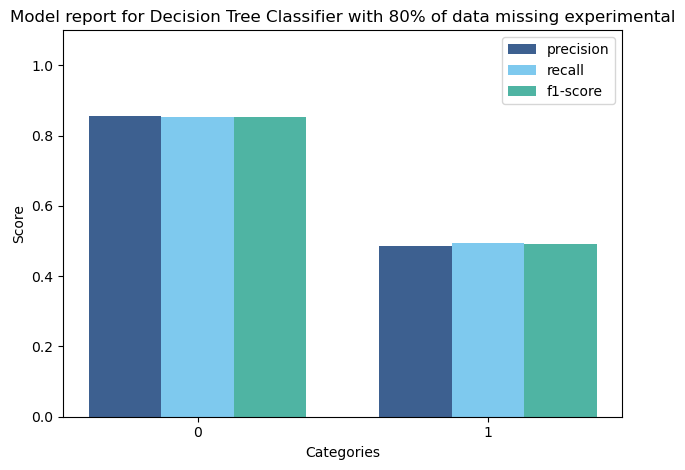

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     10533
           1       0.79      0.05      0.09      2967

    accuracy                           0.79     13500
   macro avg       0.79      0.52      0.49     13500
weighted avg       0.79      0.79      0.71     13500

Balanced accuracy:
0.5223420312126067


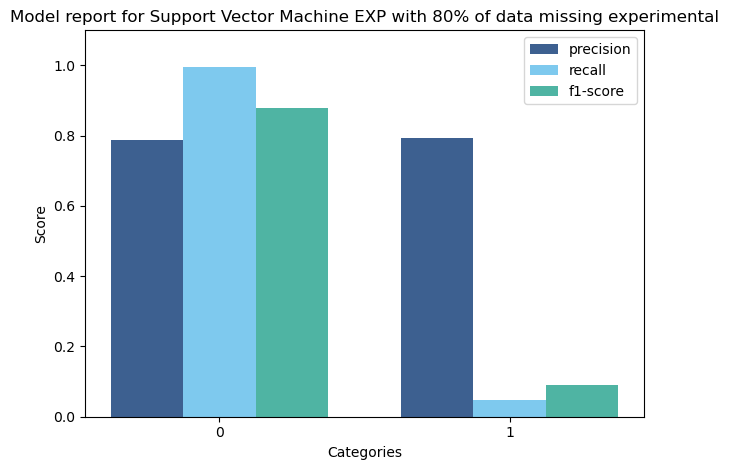

In [490]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(
    remove_entries,
    dirty_type = "missing experimental",
    file_suffix = "missing_exp",
    experimental = True
)

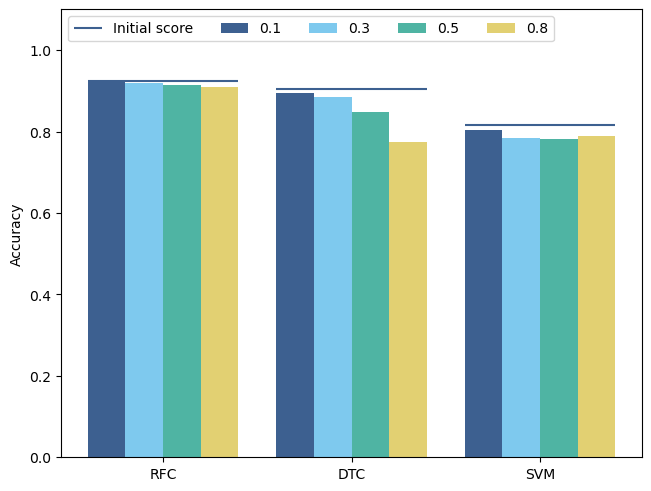

In [491]:
plot_model_accuracies(accuracies,
                      # title = "random missing data",
                      filePrefix = "report_missing_exp")

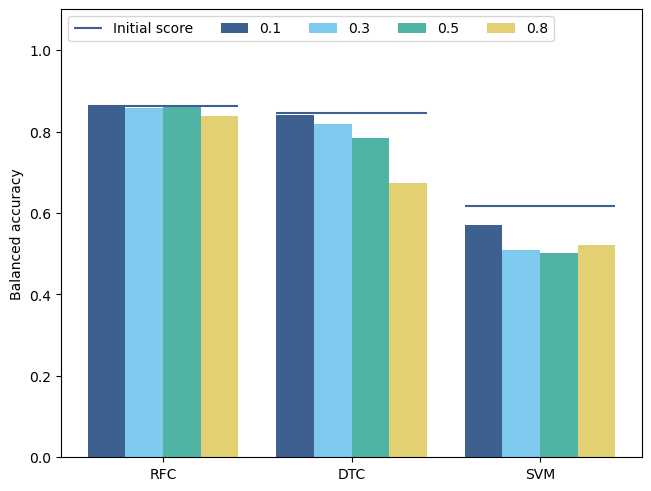

In [492]:
plot_model_accuracies(balanced_accuracies,
                      # title = "random missing data",
                      filePrefix = "report_missing_exp_balanced",
                      balanced=True)

### Based on feature importance

In [493]:
def modify_entries_proportional_to_importance(
    df,
    fraction,
    feature_importance,
    dirty_function,
    numerical_only = True
):
    """
    dirty_function gets the original df and the column name as input
    """
    # Normalize the importance scores so they sum up to 1
    total_importance = feature_importance.sum()
    normalized_importance = feature_importance / total_importance
    
    # Create a copy of the DataFrame to avoid modifying the original
    res = df.copy()
    
    # Calculate the number of entries to remove for each feature based on its importance
    num_entries_to_modify = int(df.size * fraction)
    remaining_entries_to_modify = num_entries_to_modify
    
    # Iterate over each feature based on its normalized importance
    while remaining_entries_to_modify > 0:
        for feature in normalized_importance.sort_values(ascending=False).index:
            if not numerical_only or feature not in categoricals:
                if remaining_entries_to_modify <= 0:
                    break
                
                # Calculate the number of entries to modify from this feature
                num_to_modify = min(int(len(res[feature].index) * normalized_importance[feature]), remaining_entries_to_modify)
                
                # Randomly select a subset of these indices
                random_indices = np.random.choice(res[feature].index, size=num_to_modify, replace=False)
                
                for idx in random_indices:
                    new_value = dirty_function(df, feature)
                    if df[feature].dtype == "int64" and new_value is not None:
                        new_value = int(new_value)
                    res.at[idx, feature] = new_value
                    
                # Update the number of remaining entries to remove
                remaining_entries_to_modify -= num_to_modify
    
    return res

In [494]:
# This is essentially the function from the previous cell but specialized for nulls
# It's a bit faster than the fancier version in the next cell
def remove_entries_proportional_to_importance(df, fraction, feature_importance):
    """
    Randomly sets a fraction of the dataframe values to None based on feature importance,
    giving higher priority to more important features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    fraction (float): The total fraction of entries to set to None across all features.
    model (BaseEstimator): A fitted scikit-learn model that supports feature importances.
    
    Returns:
    pd.DataFrame: A new DataFrame with some entries set to None.
    """    
    # Normalize the importance scores so they sum up to 1
    total_importance = feature_importance.sum()
    normalized_importance = feature_importance / total_importance
    
    # Create a copy of the DataFrame to avoid modifying the original
    df_random_nulls = df.copy()
    
    # Calculate the number of entries to remove for each feature based on its importance
    num_entries_to_remove = int(df.size * fraction)
    remaining_entries_to_remove = num_entries_to_remove
    
    # Iterate over each feature based on its normalized importance
    while remaining_entries_to_remove > 0:
        for feature in normalized_importance.sort_values(ascending=False).index:
            if remaining_entries_to_remove <= 0:
                break
            
            # Get the non-null values and their indices
            non_null_indices = df_random_nulls[feature].dropna().index
            
            # Calculate the number of entries to remove from this feature
            num_to_remove = min(int(len(non_null_indices) * normalized_importance[feature]), remaining_entries_to_remove)
            
            # Randomly select a subset of these indices
            random_indices = np.random.choice(non_null_indices, size=num_to_remove, replace=False)
            
            # Set the selected indices to None
            df_random_nulls.loc[random_indices, feature] = None
            
            # Update the number of remaining entries to remove
            remaining_entries_to_remove -= num_to_remove
    
    return df_random_nulls

In [495]:
# # This does work but it is a bit slower, so the old "hard coded" version is used.
# # But this is here to prove that yea you could do this in a more "modular" way
# def remove_entries_proportional_to_importance(df, fraction, feature_importance):
#     return modify_entries_proportional_to_importance(
#         df = df,
#         fraction = fraction,
#         feature_importance = feature_importance,
#         dirty_function = lambda df, feature: None,
#         numerical_only = False
#     )

#### Missing data visualization

In [497]:
X_missing_importance_10 = remove_entries_proportional_to_importance(X_train, 0.1, feature_importance_rfc)
X_missing_importance_30 = remove_entries_proportional_to_importance(X_train, 0.3, feature_importance_rfc)
X_missing_importance_50 = remove_entries_proportional_to_importance(X_train, 0.5, feature_importance_rfc)
X_missing_importance_80 = remove_entries_proportional_to_importance(X_train, 0.8, feature_importance_rfc)

In [600]:
missing_values_10 = X_missing_importance_10.isnull().sum().sort_values(ascending=False)
missing_values_30 = X_missing_importance_30.isnull().sum().sort_values(ascending=False)
missing_values_50 = X_missing_importance_50.isnull().sum().sort_values(ascending=False)
missing_values_80 = X_missing_importance_80.isnull().sum().sort_values(ascending=False)
print(missing_values_80)

total_missing_values = X_missing_importance_80.isnull().sum().sum()
print(str(100 * total_missing_values / X_missing_importance_80.size) + "%")

previous_loan_defaults_on_file    31497
loan_percent_income               31495
loan_int_rate                     31494
person_income                     31492
person_home_ownership             31389
loan_amnt                         30472
credit_score                      29653
loan_intent                       28120
person_age                        21711
person_emp_exp                    19741
cb_person_cred_hist_length        18995
person_education                  13707
person_gender                      7834
dtype: int64
80.0%


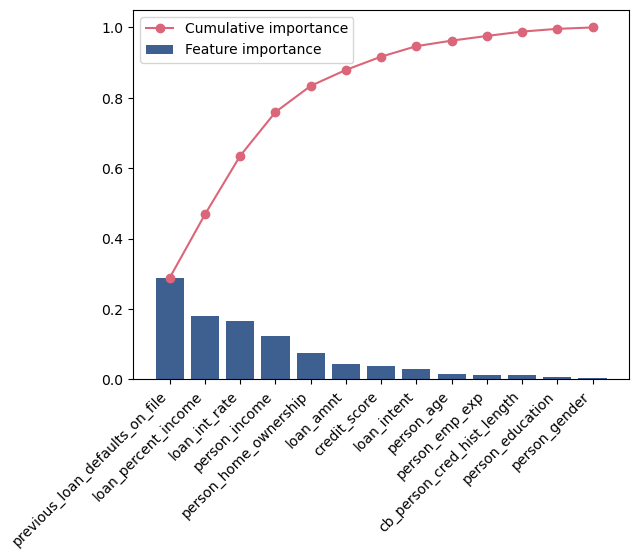

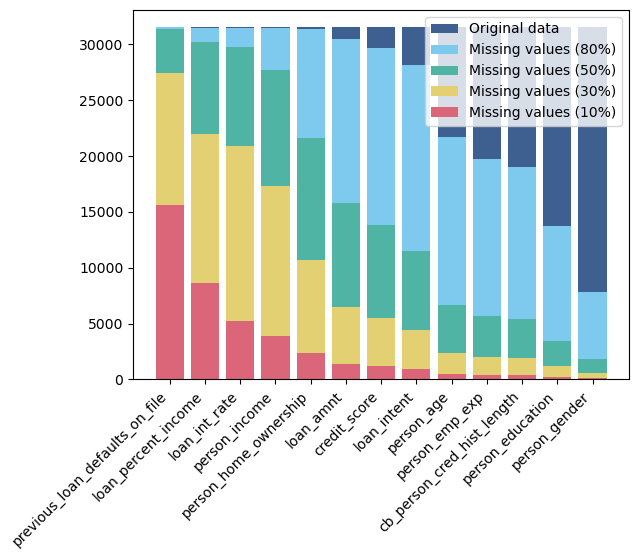

In [614]:
feature_importance_rfc_sorted = feature_importance_rfc.sort_values(ascending=False)
plt.bar(feature_importance_rfc_sorted.index, feature_importance_rfc_sorted, label="Feature importance")
plt.plot(feature_importance_rfc_sorted.cumsum(), marker='o', linestyle='-', color='#DB667A', label="Cumulative importance")
plt.xticks(rotation=45, ha="right")
plt.legend()
# plt.savefig("images/feature_importance.svg")
plt.show()

plt.bar(feature_importance_rfc_sorted.index, len(X_train), label="Original data")
plt.bar(feature_importance_rfc_sorted.index, missing_values_80, label="Missing values (80%)")
plt.bar(feature_importance_rfc_sorted.index, missing_values_50, label="Missing values (50%)")
plt.bar(feature_importance_rfc_sorted.index, missing_values_30, label="Missing values (30%)")
plt.bar(feature_importance_rfc_sorted.index, missing_values_10, label="Missing values (10%)")
plt.xticks(rotation=45, ha="right")
plt.legend()
# plt.savefig("images/missing_importance.svg")
plt.show()

#### Running models

Dirty portion: 0.1
Missing percentage: 10.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10533
           1       0.87      0.76      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8647471949346544
Feature importance ranking:
loan_percent_income               0.188433
loan_int_rate                     0.182490
person_income                     0.157507
previous_loan_defaults_on_file    0.149428
person_home_ownership             0.087679
loan_amnt                         0.071073
credit_score                      0.046838
loan_intent                       0.035476
person_age                        0.023871
person_emp_exp                    0.021484
cb_person_cred_hist_length        0.018863
person_education                  0.011197
person_gender          

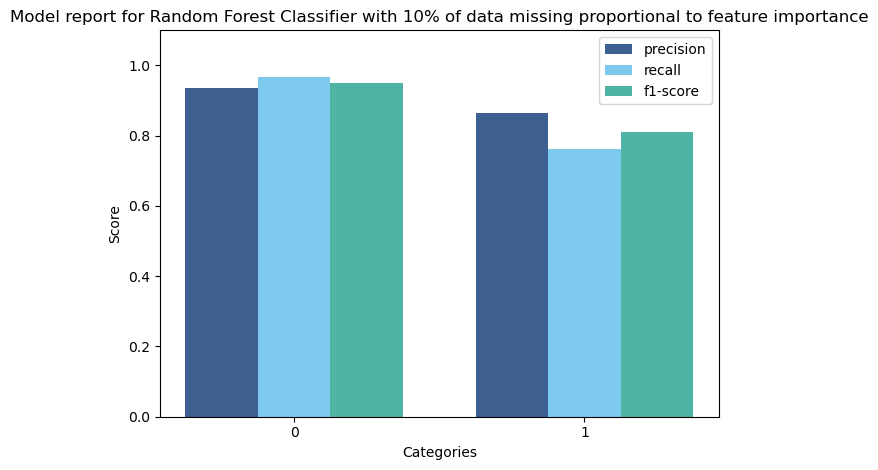

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     10533
           1       0.74      0.70      0.72      2967

    accuracy                           0.88     13500
   macro avg       0.83      0.82      0.82     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.8155917024034531
Feature importance ranking:
loan_percent_income               0.193803
loan_int_rate                     0.190103
person_income                     0.159948
person_home_ownership             0.113718
previous_loan_defaults_on_file    0.107634
loan_amnt                         0.052415
credit_score                      0.043814
loan_intent                       0.036223
person_age                        0.029214
cb_person_cred_hist_length        0.028723
person_emp_exp                    0.024271
person_education                  0.013029
person_gender                     0.007104
dtype: float64


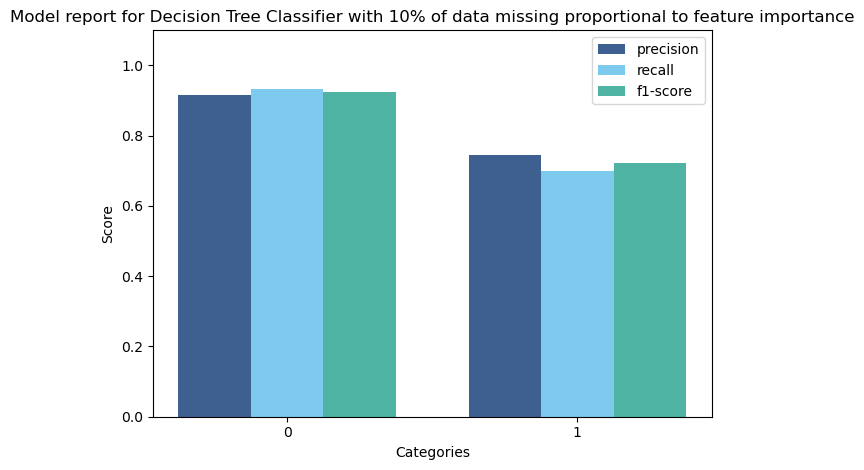

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     10533
           1       0.77      0.21      0.33      2967

    accuracy                           0.81     13500
   macro avg       0.79      0.60      0.61     13500
weighted avg       0.81      0.81      0.77     13500

Balanced accuracy:
0.596521961840379


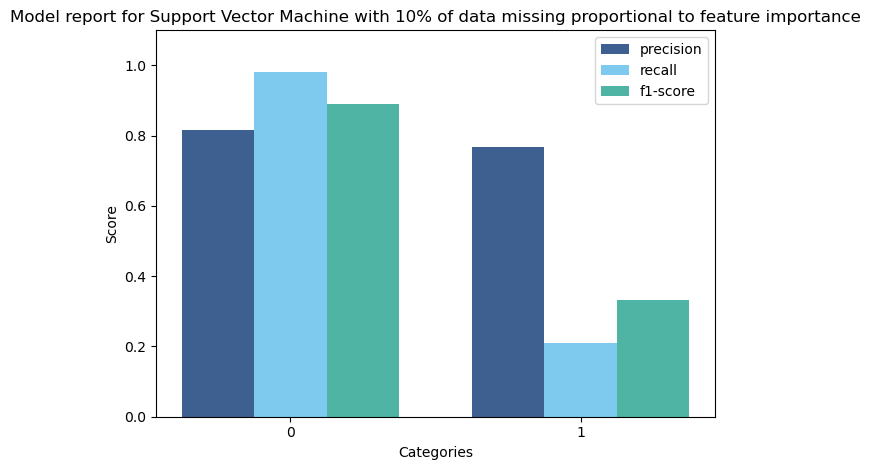

Dirty portion: 0.3
Missing percentage: 30.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10533
           1       0.87      0.71      0.78      2967

    accuracy                           0.91     13500
   macro avg       0.90      0.84      0.86     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8388448764761374
Feature importance ranking:
person_income                     0.183439
loan_percent_income               0.154987
loan_int_rate                     0.130563
loan_amnt                         0.110664
person_home_ownership             0.103778
credit_score                      0.064542
previous_loan_defaults_on_file    0.060709
loan_intent                       0.046391
person_age                        0.042760
person_emp_exp                    0.039233
cb_person_cred_hist_length        0.034930
person_education                  0.018635
person_gender          

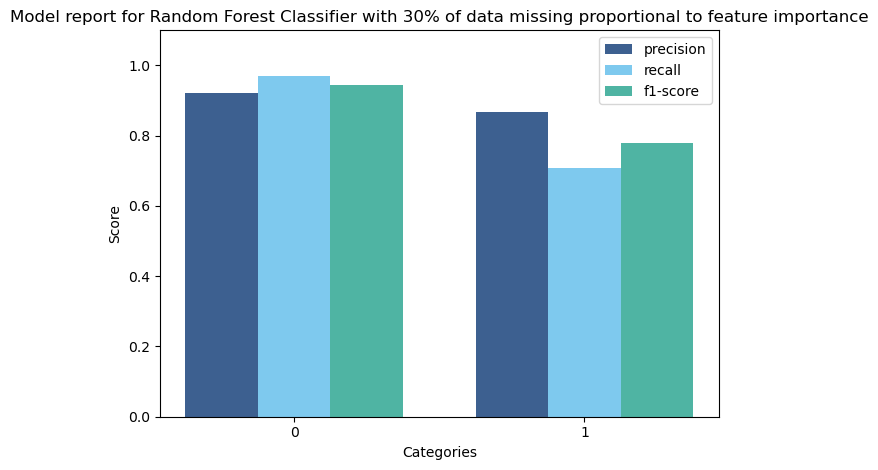

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     10533
           1       0.61      0.66      0.63      2967

    accuracy                           0.83     13500
   macro avg       0.76      0.77      0.76     13500
weighted avg       0.84      0.83      0.84     13500

Balanced accuracy:
0.7698328245083078
Feature importance ranking:
person_income                     0.171730
loan_percent_income               0.154032
loan_int_rate                     0.145637
loan_amnt                         0.113810
person_home_ownership             0.094458
previous_loan_defaults_on_file    0.077145
credit_score                      0.056390
loan_intent                       0.047554
person_age                        0.044594
person_emp_exp                    0.038752
cb_person_cred_hist_length        0.027394
person_education                  0.019544
person_gender                     0.008961
dtype: float64


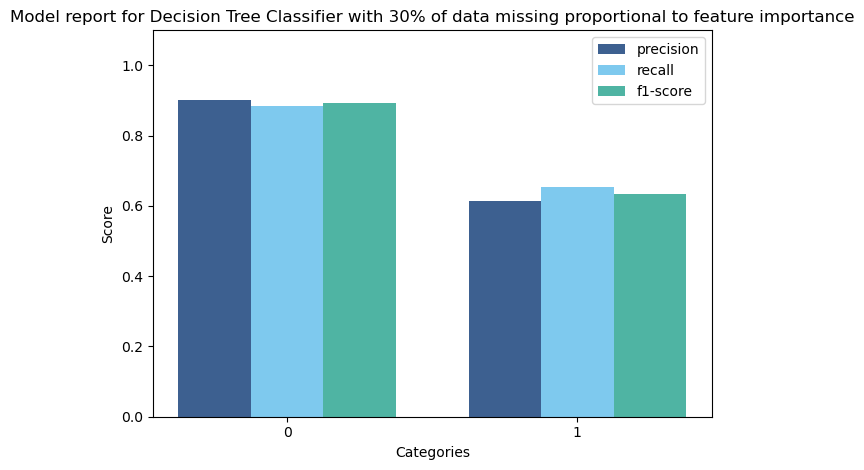

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10533
           1       0.79      0.14      0.24      2967

    accuracy                           0.80     13500
   macro avg       0.80      0.57      0.57     13500
weighted avg       0.80      0.80      0.75     13500

Balanced accuracy:
0.5670522044588643


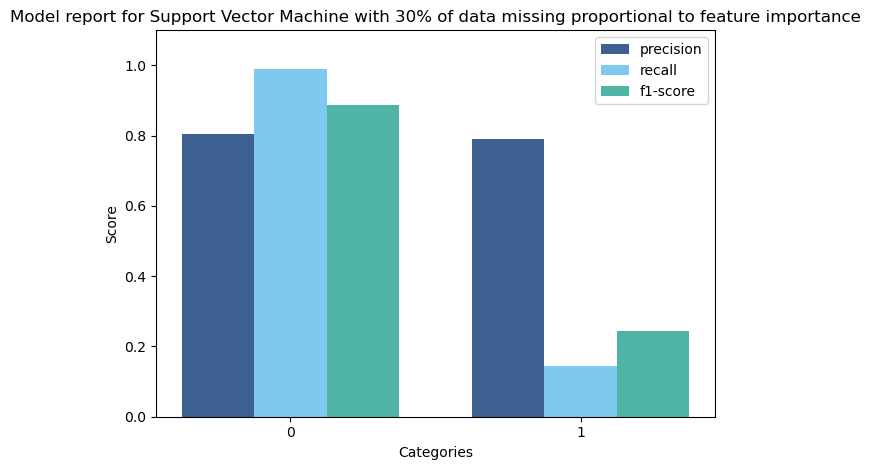

Dirty portion: 0.5
Missing percentage: 50.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     10533
           1       0.83      0.61      0.70      2967

    accuracy                           0.89     13500
   macro avg       0.86      0.79      0.82     13500
weighted avg       0.88      0.89      0.88     13500

Balanced accuracy:
0.787605222049014
Feature importance ranking:
loan_amnt                         0.152354
person_income                     0.123325
credit_score                      0.112452
person_home_ownership             0.108991
person_age                        0.086948
person_emp_exp                    0.083685
loan_intent                       0.077148
cb_person_cred_hist_length        0.075422
loan_int_rate                     0.059791
loan_percent_income               0.048899
person_education                  0.043138
person_gender                     0.024068
previous_loan_defaults_o

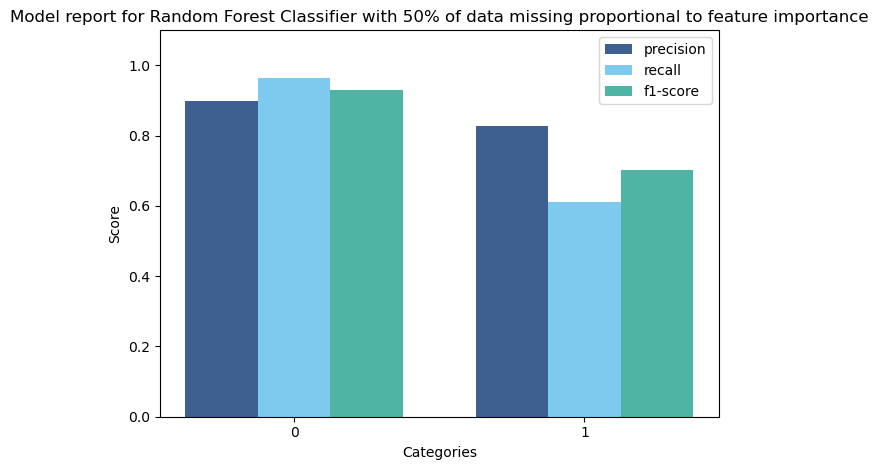

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.68      0.77     10533
           1       0.37      0.67      0.48      2967

    accuracy                           0.68     13500
   macro avg       0.62      0.67      0.62     13500
weighted avg       0.77      0.68      0.70     13500

Balanced accuracy:
0.6743947977260931
Feature importance ranking:
loan_amnt                         0.140363
person_income                     0.140293
person_home_ownership             0.111469
credit_score                      0.103534
person_age                        0.087647
loan_intent                       0.077243
cb_person_cred_hist_length        0.070570
person_emp_exp                    0.068502
loan_int_rate                     0.063071
loan_percent_income               0.058695
person_education                  0.045490
person_gender                     0.026246
previous_loan_defaults_on_file    0.006877
dtype: float64


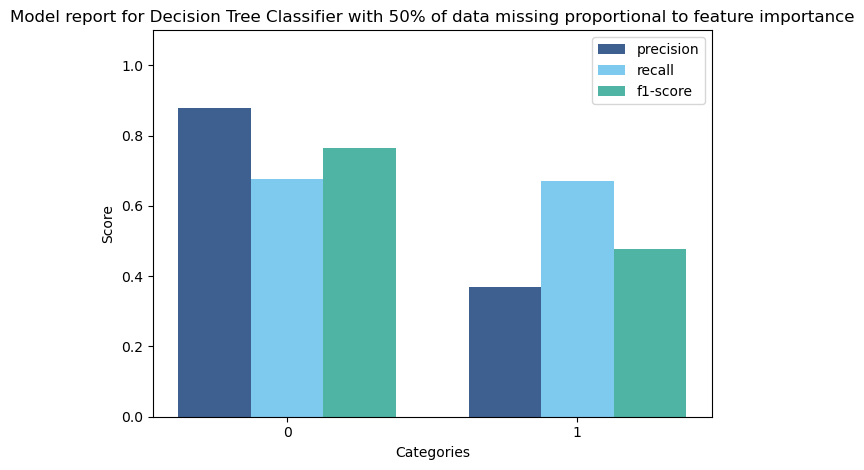

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10533
           1       0.83      0.10      0.19      2967

    accuracy                           0.80     13500
   macro avg       0.81      0.55      0.54     13500
weighted avg       0.80      0.80      0.73     13500

Balanced accuracy:
0.5493717707658063


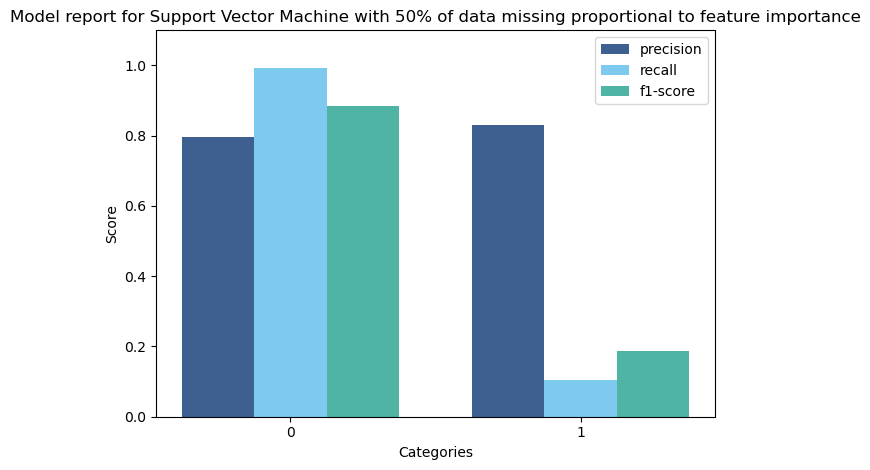

Dirty portion: 0.8
Missing percentage: 80.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5
Feature importance ranking:
cb_person_cred_hist_length        0.188810
person_age                        0.177301
person_emp_exp                    0.166718
person_education                  0.114403
credit_score                      0.112051
loan_amnt                         0.082710
loan_intent                       0.081344
person_gender                     0.070247
person_home_ownership             0.005605
person_income                     0.000387
loan_percent_income               0.000246
loan_int_rate                     0.000175
previous_loan_defaults_on_file    0.00

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

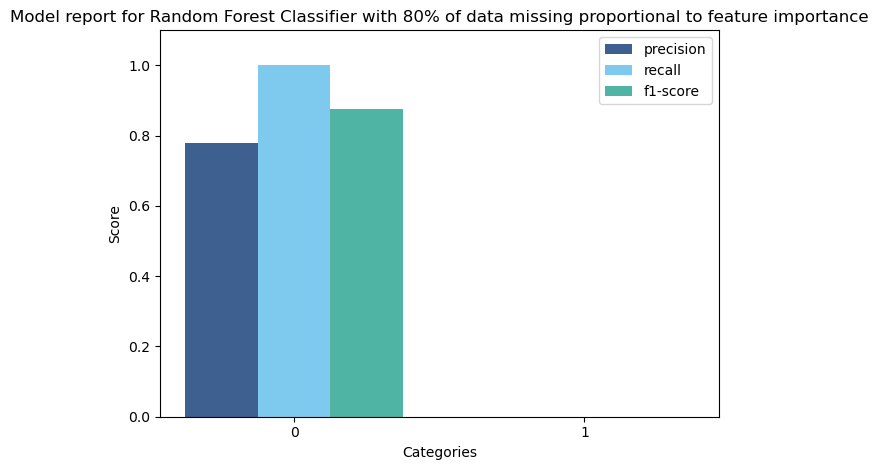

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.53      0.64     10533
           1       0.24      0.52      0.32      2967

    accuracy                           0.53     13500
   macro avg       0.52      0.52      0.48     13500
weighted avg       0.67      0.53      0.57     13500

Balanced accuracy:
0.524194315578263
Feature importance ranking:
person_age                        0.168013
cb_person_cred_hist_length        0.164658
person_education                  0.156262
loan_amnt                         0.139224
credit_score                      0.099732
person_gender                     0.095644
person_emp_exp                    0.090978
loan_intent                       0.077893
person_home_ownership             0.005159
previous_loan_defaults_on_file    0.002437
person_income                     0.000000
loan_int_rate                     0.000000
loan_percent_income               0.000000
dtype: float64


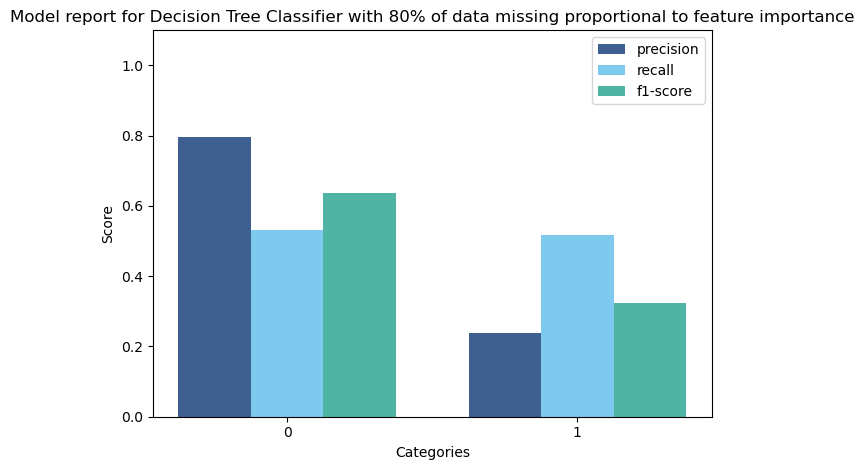

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88     10533
           1       0.73      0.08      0.14      2967

    accuracy                           0.79     13500
   macro avg       0.76      0.54      0.51     13500
weighted avg       0.78      0.79      0.72     13500

Balanced accuracy:
0.5350879037109717


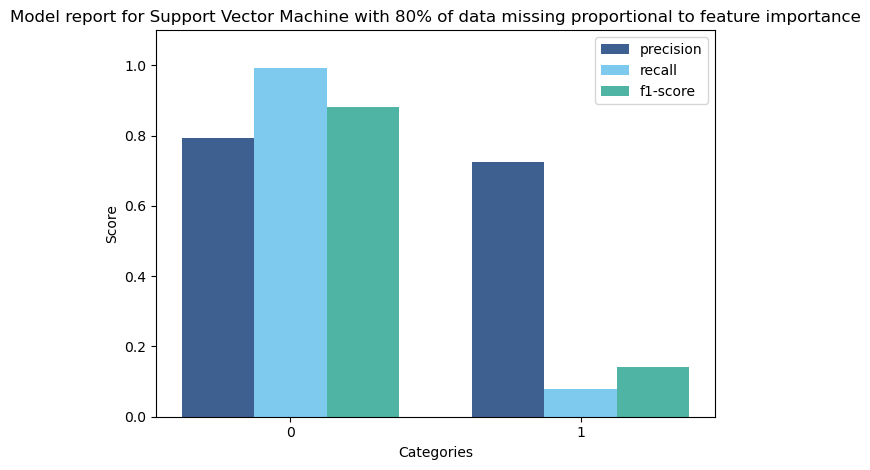

In [594]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(remove_entries_proportional_to_importance,
                                   feature_importance = feature_importance_rfc,
                                   dirty_type = "missing proportional to feature importance",
                                   file_suffix = "missing_importance")

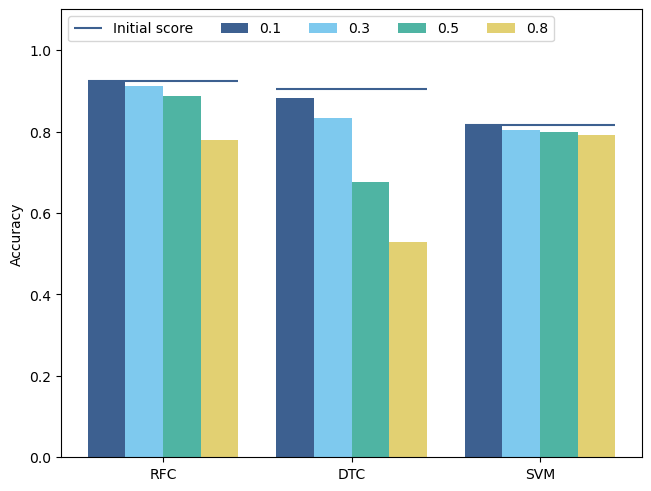

In [595]:
plot_model_accuracies(accuracies,
                      # title = "missing data proportional to feature importance",
                      filePrefix = "report_missing_importance")

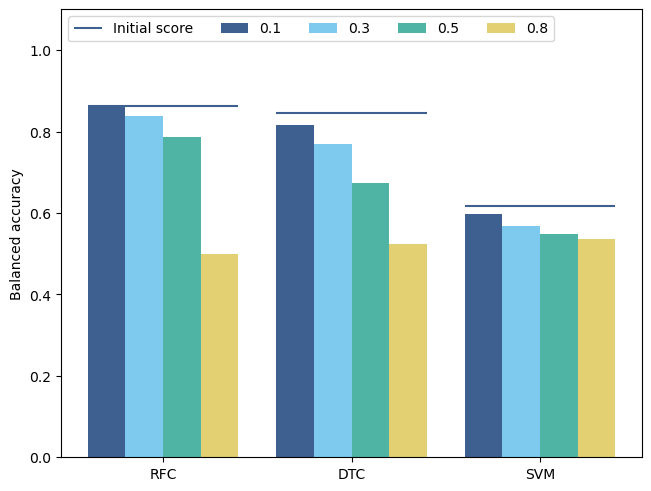

In [596]:
plot_model_accuracies(balanced_accuracies,
                      # title = "missing data proportional to feature importance",
                      filePrefix = "report_missing_importance_balanced",
                      balanced=True)

#### Experimental imputer

Dirty portion: 0.1
Missing percentage: 10.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.87      0.75      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8583766345781956
Feature importance ranking:
loan_percent_income               0.185092
loan_int_rate                     0.181821
person_income                     0.156148
previous_loan_defaults_on_file    0.152363
person_home_ownership             0.090680
loan_amnt                         0.070469
credit_score                      0.047302
loan_intent                       0.034951
person_age                        0.023143
person_emp_exp                    0.022213
cb_person_cred_hist_length        0.019172
person_education                  0.011306
person_gender          

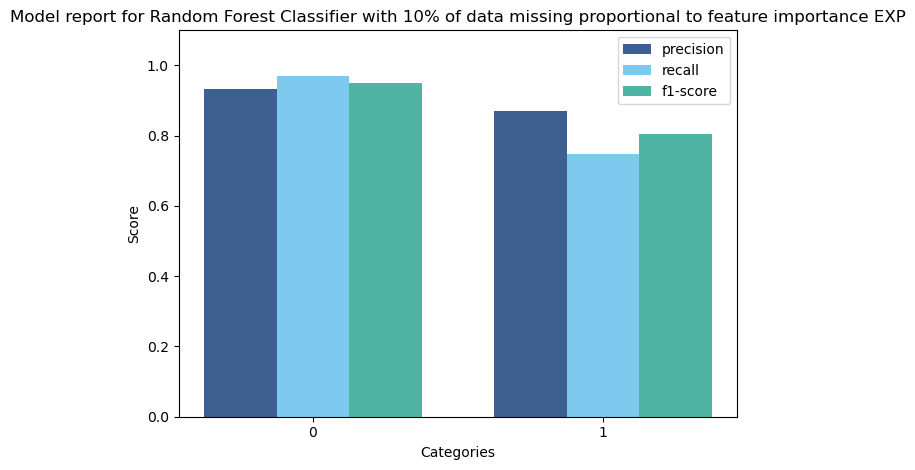

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     10533
           1       0.75      0.71      0.73      2967

    accuracy                           0.88     13500
   macro avg       0.83      0.82      0.83     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.8229069081072852
Feature importance ranking:
loan_int_rate                     0.186233
person_income                     0.176578
previous_loan_defaults_on_file    0.146564
loan_percent_income               0.140048
loan_amnt                         0.082064
person_home_ownership             0.069949
credit_score                      0.052678
loan_intent                       0.050561
person_emp_exp                    0.027717
person_age                        0.024127
cb_person_cred_hist_length        0.022405
person_education                  0.014510
person_gender                     0.006566
dtype: float64


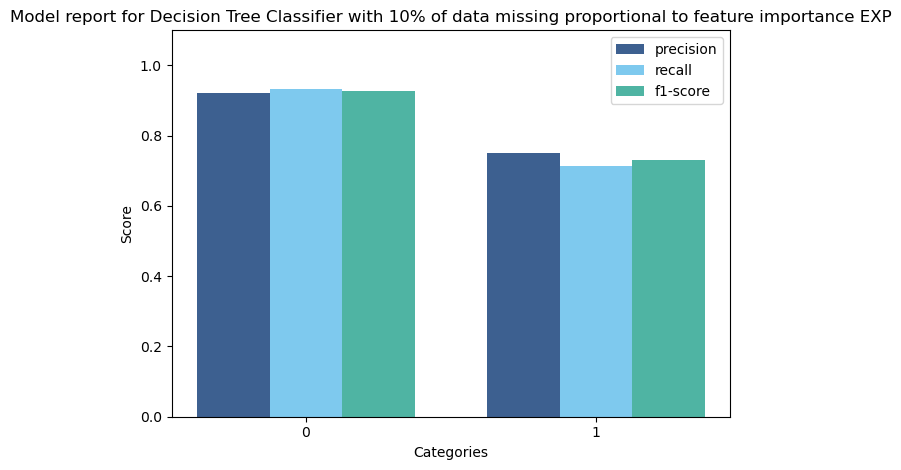

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     10533
           1       0.78      0.18      0.29      2967

    accuracy                           0.81     13500
   macro avg       0.79      0.58      0.59     13500
weighted avg       0.80      0.81      0.76     13500

Balanced accuracy:
0.5806525343767679


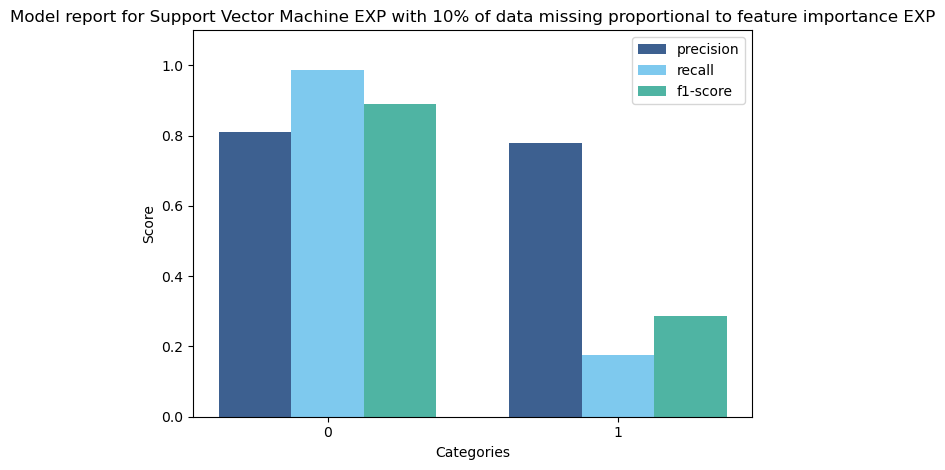

Dirty portion: 0.3
Missing percentage: 30.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     10533
           1       0.85      0.73      0.79      2967

    accuracy                           0.91     13500
   macro avg       0.89      0.85      0.87     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8471451417025618
Feature importance ranking:
person_income                     0.174396
loan_percent_income               0.152520
loan_int_rate                     0.144863
person_home_ownership             0.105962
loan_amnt                         0.104704
credit_score                      0.065500
previous_loan_defaults_on_file    0.062891
loan_intent                       0.045060
person_age                        0.042310
person_emp_exp                    0.039088
cb_person_cred_hist_length        0.034643
person_education                  0.019415
person_gender          

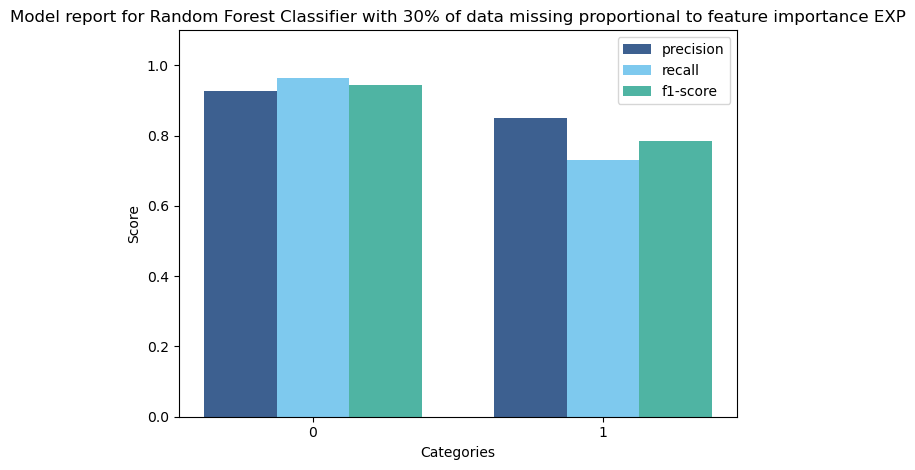

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     10533
           1       0.58      0.70      0.63      2967

    accuracy                           0.82     13500
   macro avg       0.74      0.78      0.76     13500
weighted avg       0.84      0.82      0.83     13500

Balanced accuracy:
0.7774377931287646
Feature importance ranking:
person_income                     0.173930
loan_int_rate                     0.150628
loan_percent_income               0.138384
loan_amnt                         0.112872
person_home_ownership             0.094368
previous_loan_defaults_on_file    0.071096
credit_score                      0.064177
loan_intent                       0.048816
person_age                        0.041535
person_emp_exp                    0.039081
cb_person_cred_hist_length        0.035638
person_education                  0.019273
person_gender                     0.010202
dtype: float64


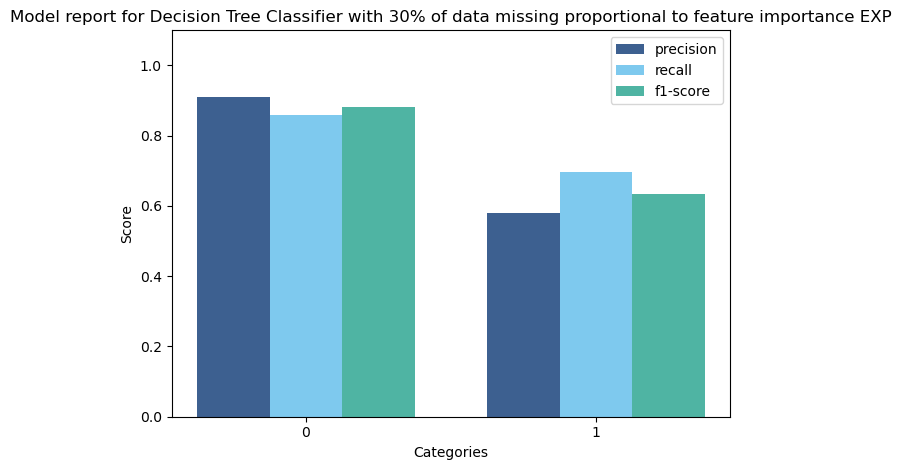

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.69      0.01      0.02      2967

    accuracy                           0.78     13500
   macro avg       0.73      0.51      0.45     13500
weighted avg       0.76      0.78      0.69     13500

Balanced accuracy:
0.5051386959775992


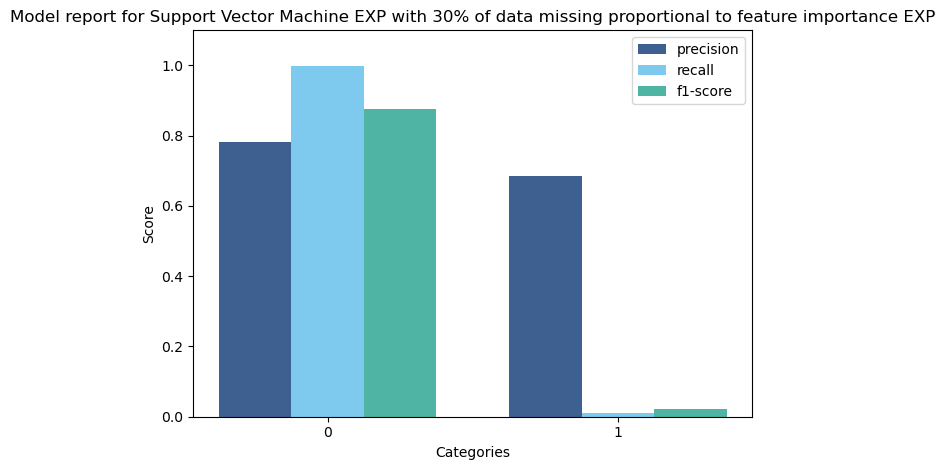

Dirty portion: 0.5
Missing percentage: 50.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93     10533
           1       0.86      0.54      0.66      2967

    accuracy                           0.88     13500
   macro avg       0.87      0.76      0.79     13500
weighted avg       0.88      0.88      0.87     13500

Balanced accuracy:
0.7577271951016868
Feature importance ranking:
loan_amnt                         0.154127
person_income                     0.123115
person_home_ownership             0.119200
credit_score                      0.109549
person_age                        0.087847
person_emp_exp                    0.081580
loan_intent                       0.077498
cb_person_cred_hist_length        0.076962
loan_percent_income               0.050775
loan_int_rate                     0.049396
person_education                  0.045073
person_gender                     0.022639
previous_loan_defaults_

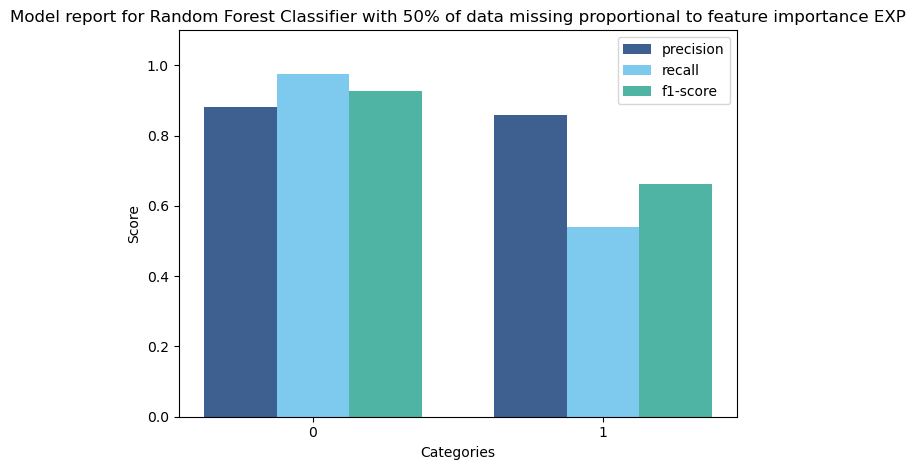

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83     10533
           1       0.42      0.49      0.45      2967

    accuracy                           0.74     13500
   macro avg       0.64      0.65      0.64     13500
weighted avg       0.76      0.74      0.75     13500

Balanced accuracy:
0.6497756053318681
Feature importance ranking:
loan_amnt                         0.130556
person_income                     0.129344
person_home_ownership             0.121687
credit_score                      0.100434
person_age                        0.097341
loan_intent                       0.088433
person_emp_exp                    0.077400
cb_person_cred_hist_length        0.070424
loan_percent_income               0.055385
loan_int_rate                     0.054064
person_education                  0.044281
person_gender                     0.030250
previous_loan_defaults_on_file    0.000402
dtype: float64


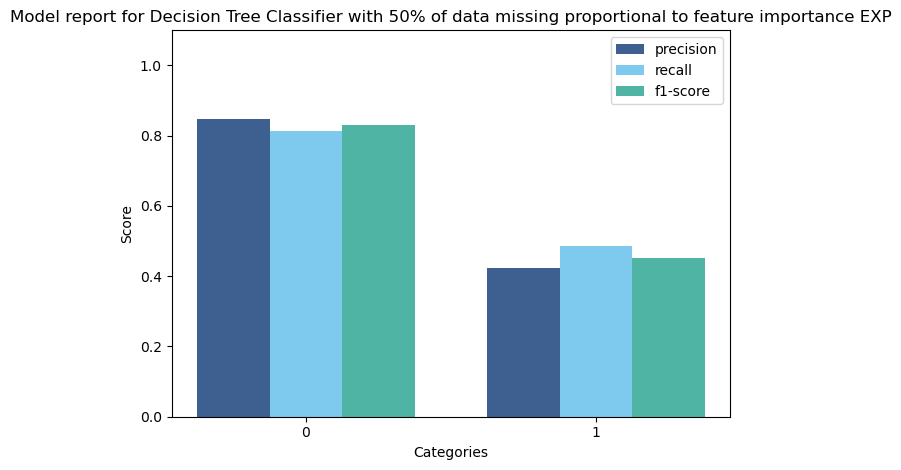

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.38      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.58      0.50      0.44     13500
weighted avg       0.69      0.78      0.68     13500

Balanced accuracy:
0.5004628431017083


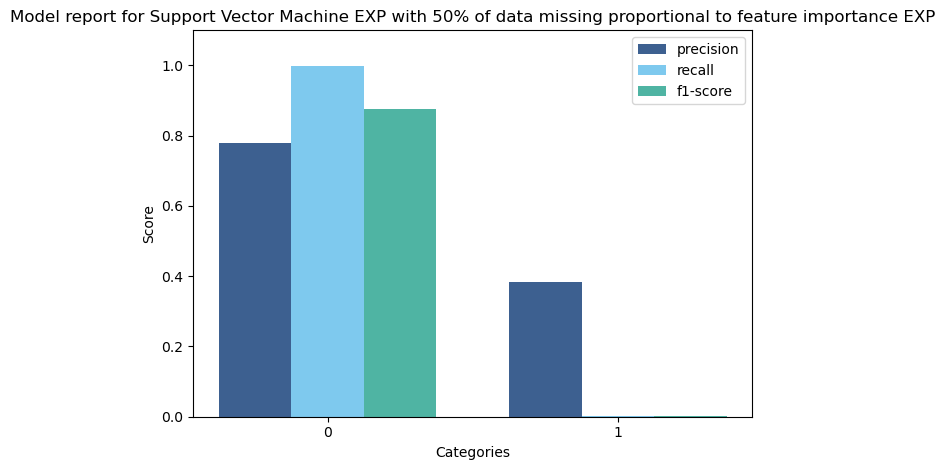

Dirty portion: 0.8
Missing percentage: 80.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5
Feature importance ranking:
person_emp_exp                    0.187912
person_age                        0.172800
cb_person_cred_hist_length        0.156540
credit_score                      0.119441
person_education                  0.111736
loan_intent                       0.094819
loan_amnt                         0.077111
person_gender                     0.072604
person_home_ownership             0.006769
loan_int_rate                     0.000117
person_income                     0.000098
loan_percent_income               0.000055
previous_loan_defaults_on_file    0.00

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

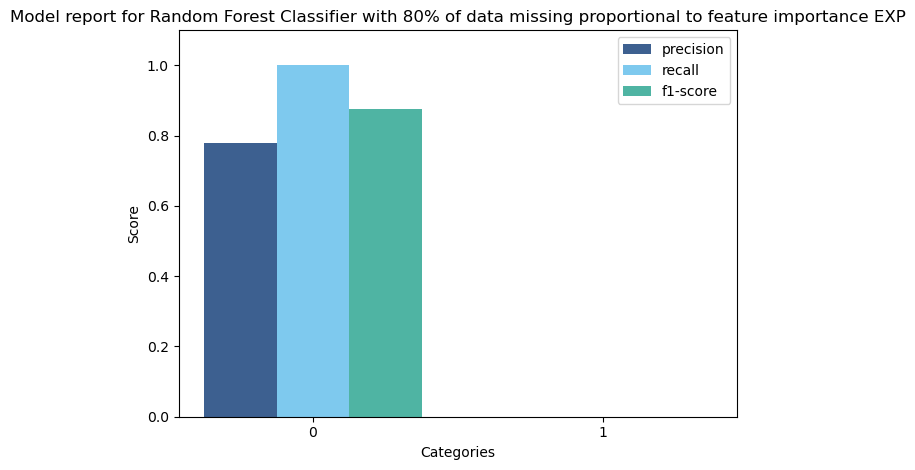

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     10533
           1       0.26      0.19      0.22      2967

    accuracy                           0.71     13500
   macro avg       0.52      0.52      0.52     13500
weighted avg       0.67      0.71      0.69     13500

Balanced accuracy:
0.5185857688153664
Feature importance ranking:
cb_person_cred_hist_length        0.168948
person_emp_exp                    0.156662
credit_score                      0.129951
person_age                        0.118378
loan_intent                       0.113934
person_gender                     0.111925
person_education                  0.100238
loan_amnt                         0.082466
person_home_ownership             0.014491
person_income                     0.002512
loan_int_rate                     0.000496
loan_percent_income               0.000000
previous_loan_defaults_on_file    0.000000
dtype: float64


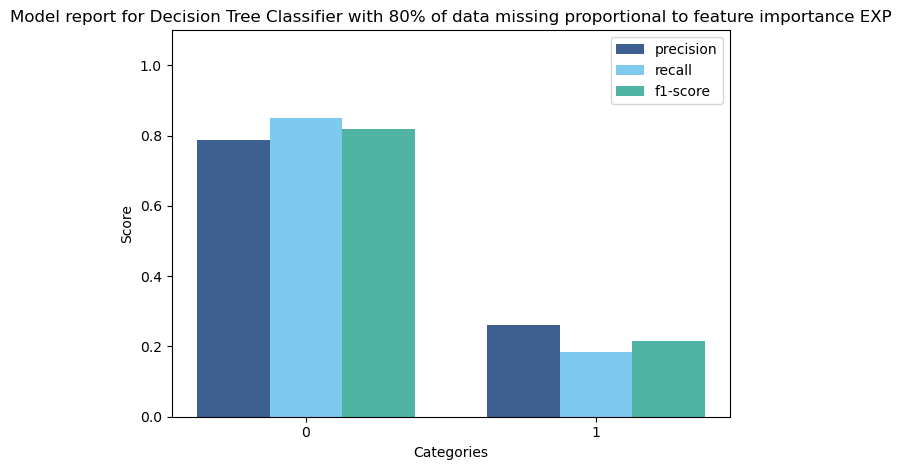

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

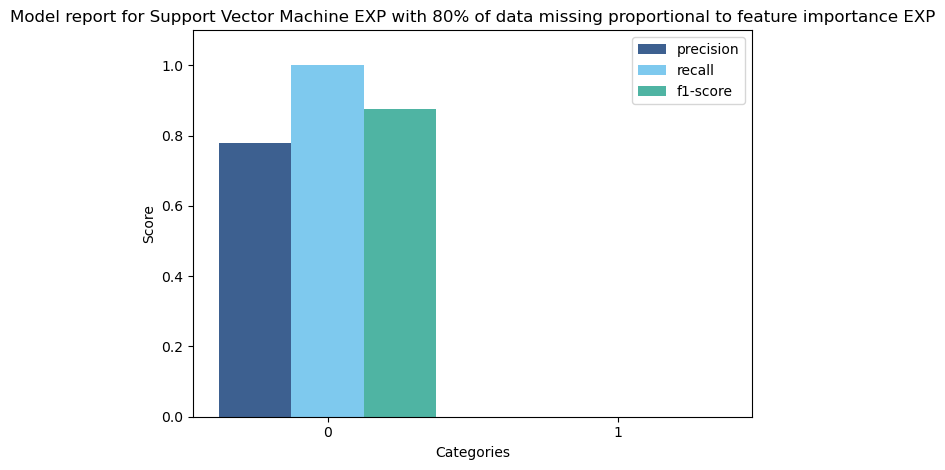

In [503]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(remove_entries_proportional_to_importance,
                                   feature_importance = feature_importance_rfc,
                                   dirty_type = "missing proportional to feature importance EXP",
                                   file_suffix = "missing_importance_exp",
                                   experimental = True)

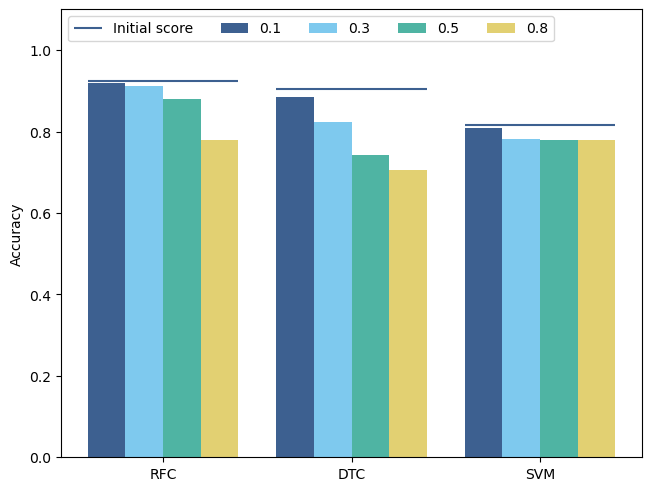

In [504]:
plot_model_accuracies(accuracies,
                      # title = "missing data proportional to feature importance",
                      filePrefix = "report_missing_importance_exp")

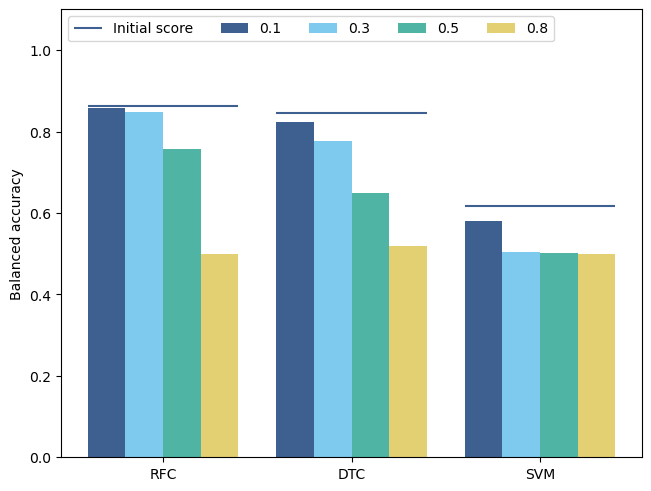

In [505]:
plot_model_accuracies(balanced_accuracies,
                      # title = "missing data proportional to feature importance",
                      filePrefix = "report_missing_importance_exp_balanced",
                      balanced=True)

### Based on feature importance - reversed

In [506]:
feature_importance_rfc.sort_values()

person_gender                     0.003928
person_education                  0.007805
cb_person_cred_hist_length        0.012434
person_emp_exp                    0.013252
person_age                        0.015702
loan_intent                       0.029774
credit_score                      0.037677
loan_amnt                         0.045335
person_home_ownership             0.074358
person_income                     0.124047
loan_int_rate                     0.166373
loan_percent_income               0.180007
previous_loan_defaults_on_file    0.289309
dtype: float64

In [507]:
inverted_feature_importances = 1 - feature_importance_rfc

# Normalize the inverted feature importances
inverted_feature_importances /= np.sum(inverted_feature_importances)

inverted_feature_importances.sort_values()

previous_loan_defaults_on_file    0.059224
loan_percent_income               0.068333
loan_int_rate                     0.069469
person_income                     0.072996
person_home_ownership             0.077137
loan_amnt                         0.079555
credit_score                      0.080194
loan_intent                       0.080852
person_age                        0.082025
person_emp_exp                    0.082229
cb_person_cred_hist_length        0.082297
person_education                  0.082683
person_gender                     0.083006
dtype: float64

#### Running models

Dirty portion: 0.1
Missing percentage: 10.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10533
           1       0.88      0.76      0.82      2967

    accuracy                           0.93     13500
   macro avg       0.91      0.87      0.89     13500
weighted avg       0.92      0.93      0.92     13500

Balanced accuracy:
0.8669046975190976
Feature importance ranking:
previous_loan_defaults_on_file    0.270704
loan_percent_income               0.181923
loan_int_rate                     0.163603
person_income                     0.123524
person_home_ownership             0.068880
loan_amnt                         0.048818
credit_score                      0.043153
loan_intent                       0.026308
person_age                        0.020509
person_emp_exp                    0.019451
cb_person_cred_hist_length        0.018144
person_education                  0.009470
person_gender          

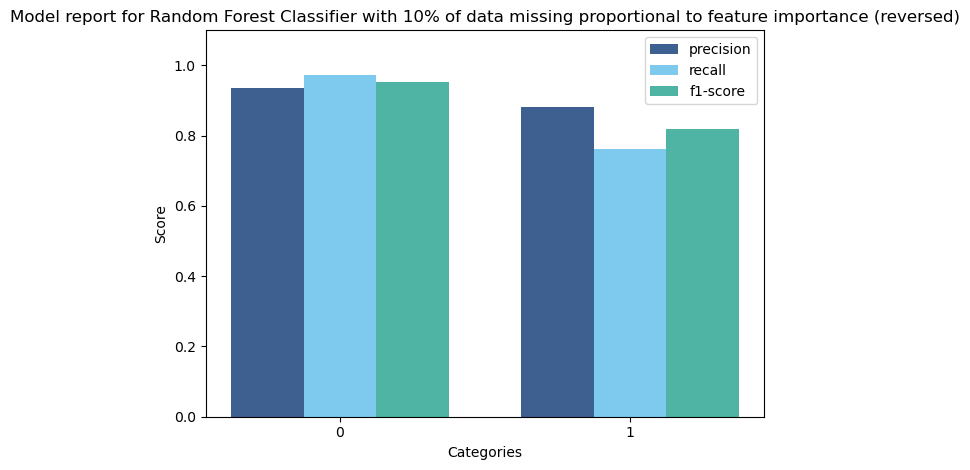

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     10533
           1       0.79      0.72      0.75      2967

    accuracy                           0.90     13500
   macro avg       0.86      0.83      0.84     13500
weighted avg       0.89      0.90      0.89     13500

Balanced accuracy:
0.832370064826833
Feature importance ranking:
previous_loan_defaults_on_file    0.244282
loan_int_rate                     0.187304
person_income                     0.154399
loan_percent_income               0.137966
person_home_ownership             0.054337
credit_score                      0.050182
loan_amnt                         0.049134
loan_intent                       0.033249
person_age                        0.025049
person_emp_exp                    0.023031
cb_person_cred_hist_length        0.020580
person_education                  0.012571
person_gender                     0.007916
dtype: float64


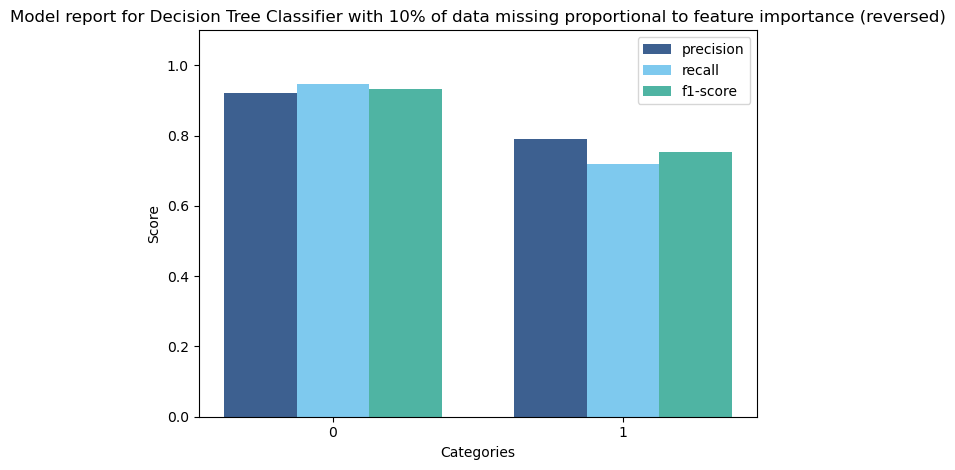

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     10533
           1       0.76      0.22      0.34      2967

    accuracy                           0.81     13500
   macro avg       0.79      0.60      0.61     13500
weighted avg       0.80      0.81      0.77     13500

Balanced accuracy:
0.5991542109890654


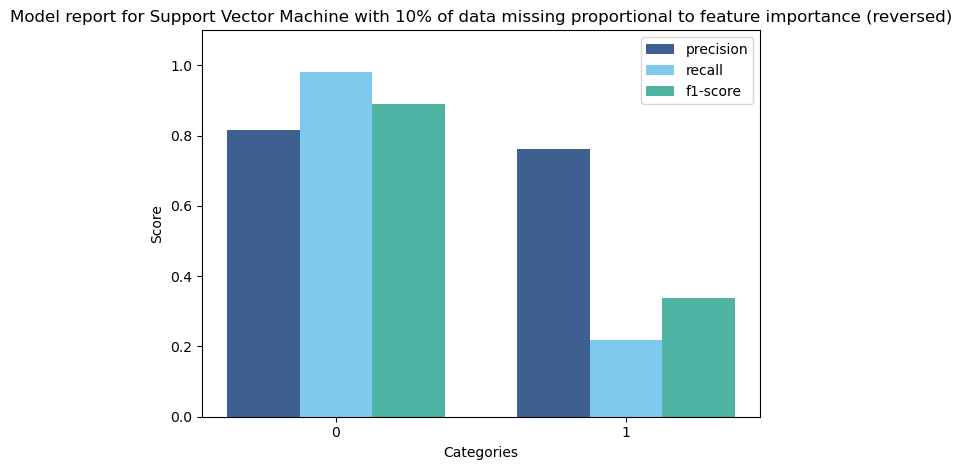

Dirty portion: 0.3
Missing percentage: 30.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.86      0.75      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8595064555645183
Feature importance ranking:
previous_loan_defaults_on_file    0.267833
loan_percent_income               0.180933
loan_int_rate                     0.152824
person_income                     0.124980
person_home_ownership             0.062937
credit_score                      0.047711
loan_amnt                         0.046757
person_emp_exp                    0.025066
person_age                        0.024108
cb_person_cred_hist_length        0.023030
loan_intent                       0.022543
person_education                  0.012631
person_gender          

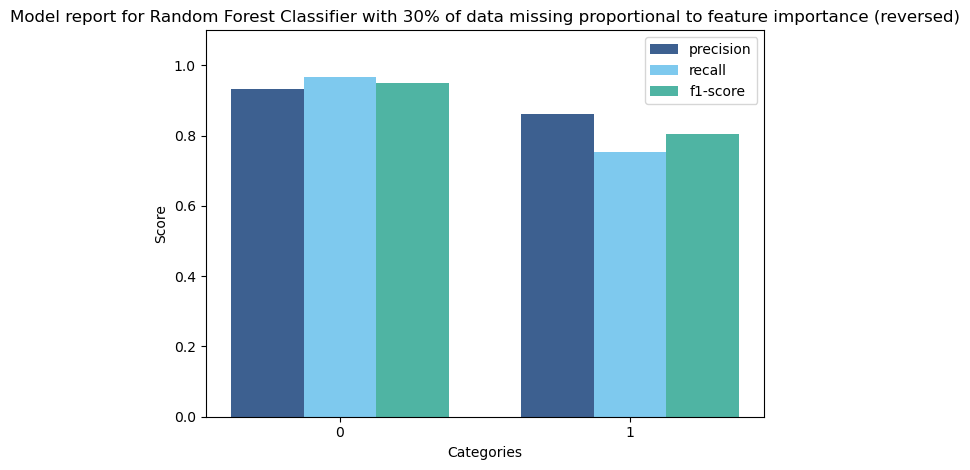

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     10533
           1       0.73      0.72      0.72      2967

    accuracy                           0.88     13500
   macro avg       0.83      0.82      0.82     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.8216845952971531
Feature importance ranking:
previous_loan_defaults_on_file    0.200546
loan_percent_income               0.189906
loan_int_rate                     0.169149
person_income                     0.144628
person_home_ownership             0.077151
credit_score                      0.049917
loan_amnt                         0.040115
person_age                        0.029060
person_emp_exp                    0.025601
cb_person_cred_hist_length        0.025560
loan_intent                       0.024127
person_education                  0.015122
person_gender                     0.009118
dtype: float64


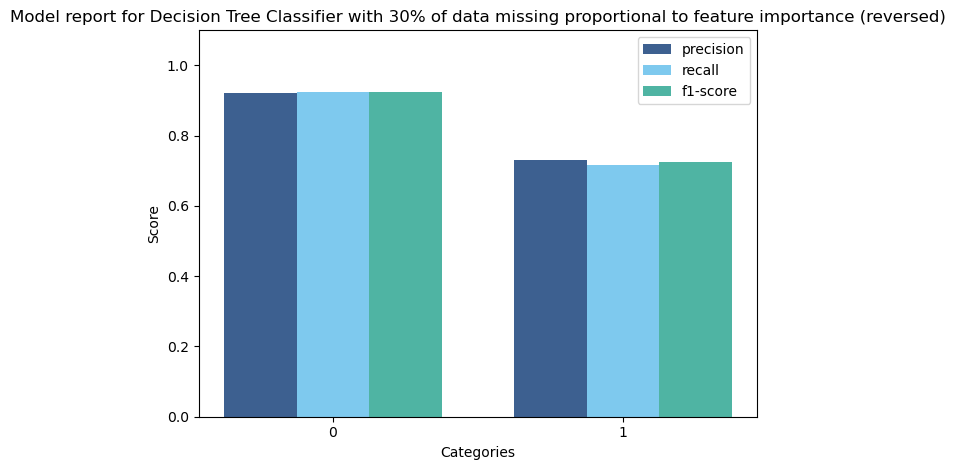

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     10533
           1       0.81      0.12      0.20      2967

    accuracy                           0.80     13500
   macro avg       0.80      0.55      0.54     13500
weighted avg       0.80      0.80      0.74     13500

Balanced accuracy:
0.5544891077078088


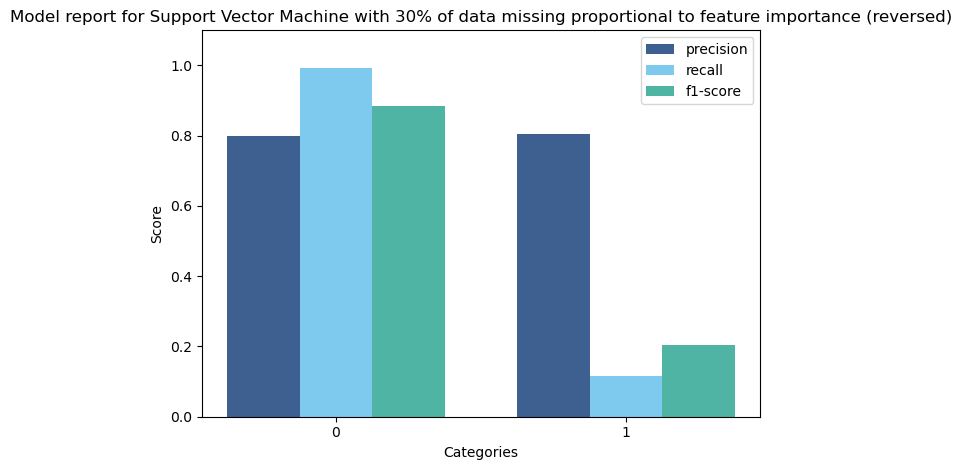

Dirty portion: 0.5
Missing percentage: 50.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10533
           1       0.83      0.77      0.80      2967

    accuracy                           0.91     13500
   macro avg       0.88      0.86      0.87     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8611323821506811
Feature importance ranking:
previous_loan_defaults_on_file    0.273753
loan_percent_income               0.178792
loan_int_rate                     0.149034
person_income                     0.130590
person_home_ownership             0.052181
loan_amnt                         0.049375
credit_score                      0.041794
person_age                        0.027168
person_emp_exp                    0.025995
cb_person_cred_hist_length        0.024713
loan_intent                       0.021911
person_education                  0.014299
person_gender          

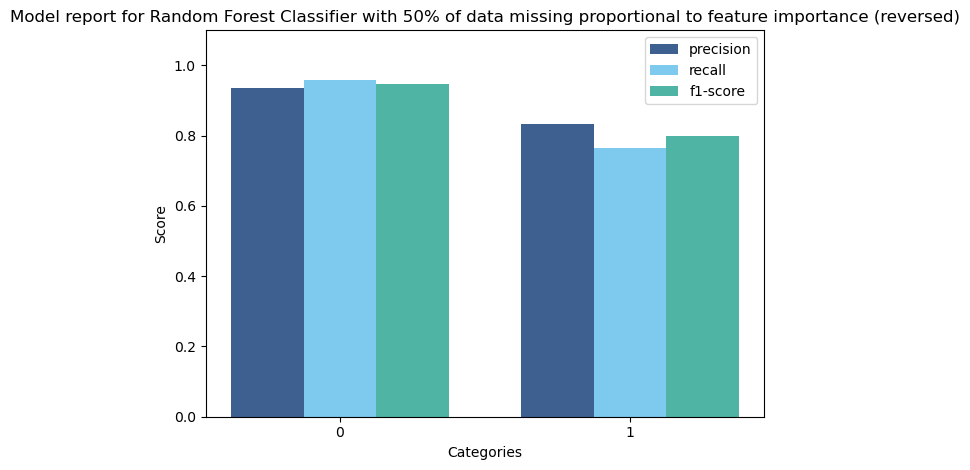

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89     10533
           1       0.60      0.67      0.63      2967

    accuracy                           0.83     13500
   macro avg       0.75      0.77      0.76     13500
weighted avg       0.84      0.83      0.83     13500

Balanced accuracy:
0.7720402928366978
Feature importance ranking:
previous_loan_defaults_on_file    0.257235
loan_percent_income               0.161910
loan_int_rate                     0.147904
person_income                     0.137773
loan_amnt                         0.061943
credit_score                      0.046652
person_home_ownership             0.037017
person_emp_exp                    0.029917
person_age                        0.029842
cb_person_cred_hist_length        0.028071
loan_intent                       0.026714
person_education                  0.020021
person_gender                     0.015003
dtype: float64


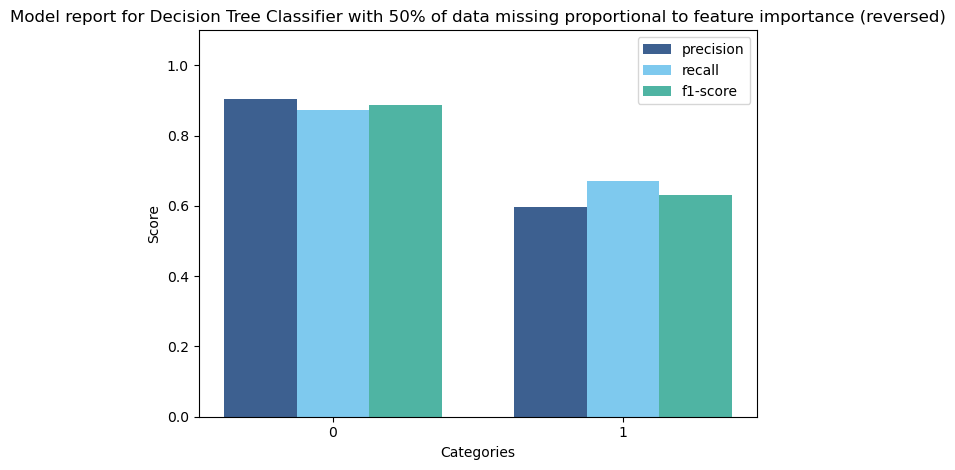

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     10533
           1       0.85      0.08      0.15      2967

    accuracy                           0.80     13500
   macro avg       0.82      0.54      0.52     13500
weighted avg       0.81      0.80      0.72     13500

Balanced accuracy:
0.5392462919514258


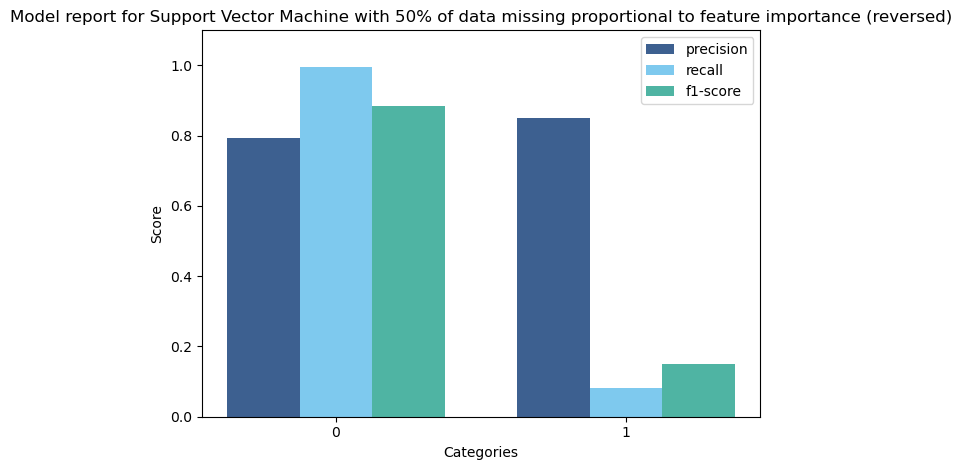

Dirty portion: 0.8
Missing percentage: 80.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10533
           1       0.86      0.67      0.75      2967

    accuracy                           0.90     13500
   macro avg       0.89      0.82      0.85     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8198756529745168
Feature importance ranking:
previous_loan_defaults_on_file    0.317135
loan_percent_income               0.185194
loan_int_rate                     0.152138
person_income                     0.123186
person_home_ownership             0.050604
loan_amnt                         0.042391
credit_score                      0.034046
person_age                        0.023472
person_emp_exp                    0.020460
cb_person_cred_hist_length        0.016584
loan_intent                       0.015626
person_education                  0.010166
person_gender          

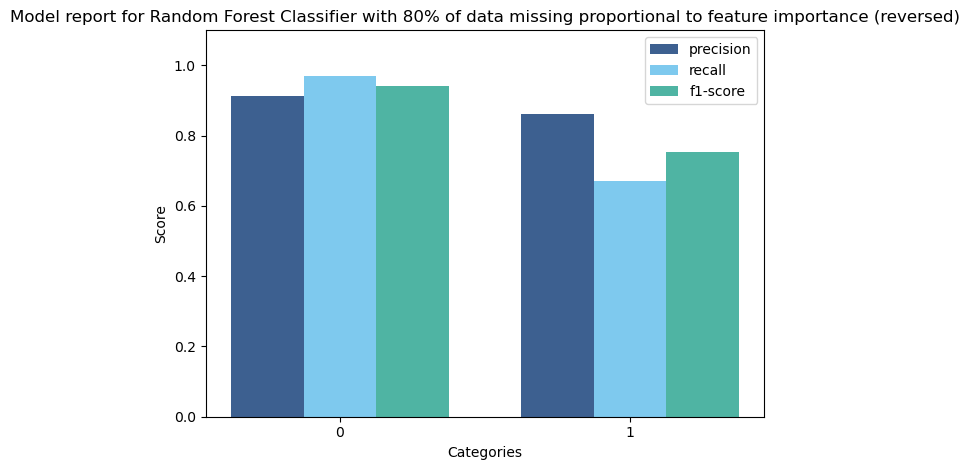

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86     10533
           1       0.51      0.67      0.58      2967

    accuracy                           0.79     13500
   macro avg       0.71      0.75      0.72     13500
weighted avg       0.81      0.79      0.80     13500

Balanced accuracy:
0.7456327971879413
Feature importance ranking:
previous_loan_defaults_on_file    0.276879
loan_percent_income               0.185881
loan_int_rate                     0.149802
person_income                     0.142478
person_home_ownership             0.053115
loan_amnt                         0.046983
credit_score                      0.030559
person_age                        0.027441
loan_intent                       0.021225
cb_person_cred_hist_length        0.018885
person_education                  0.017319
person_emp_exp                    0.016681
person_gender                     0.012750
dtype: float64


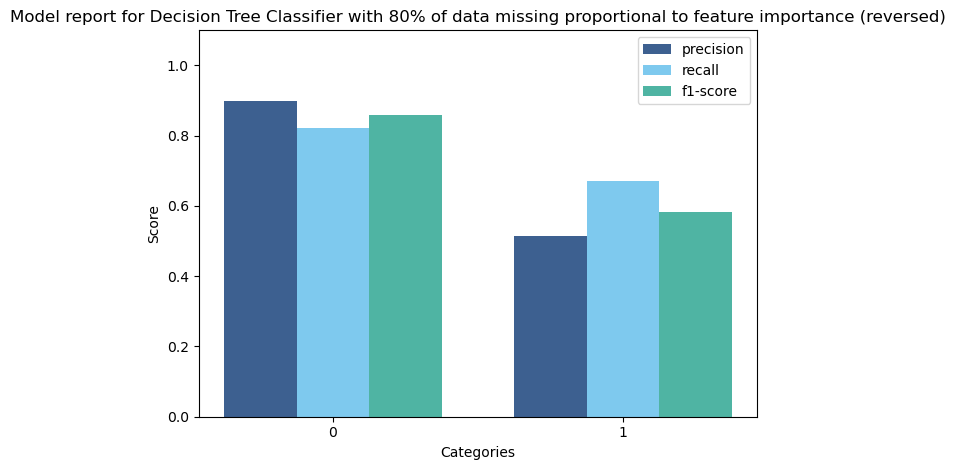

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     10533
           1       0.81      0.07      0.12      2967

    accuracy                           0.79     13500
   macro avg       0.80      0.53      0.50     13500
weighted avg       0.79      0.79      0.71     13500

Balanced accuracy:
0.5305093424421701


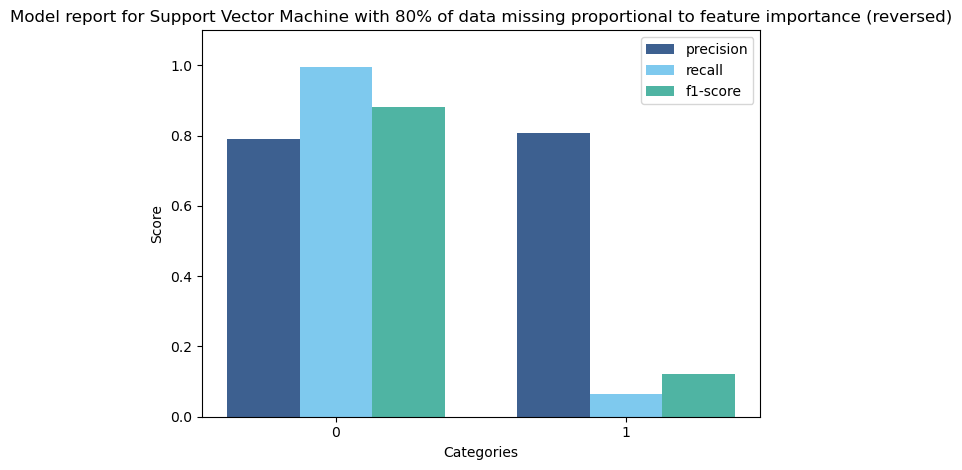

In [508]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(remove_entries_proportional_to_importance,
                                   feature_importance = inverted_feature_importances,
                                   dirty_type = "missing proportional to feature importance (reversed)",
                                   file_suffix = "missing_importance_reversed")

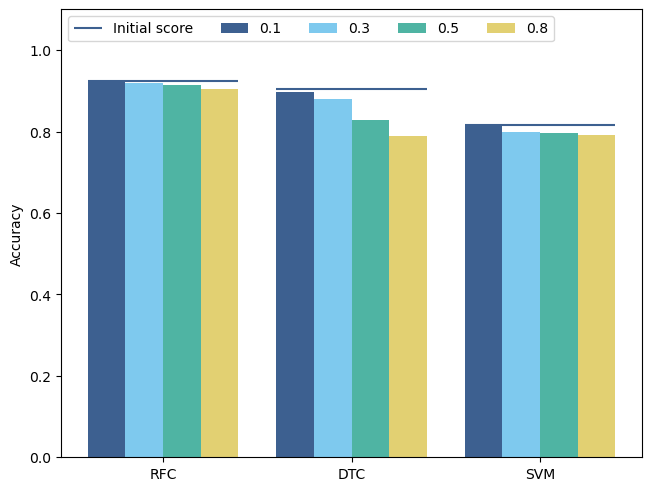

In [509]:
plot_model_accuracies(accuracies,
                      # title = "missing data proportional to reversed feature importance",
                      filePrefix = "report_missing_importance_reversed")

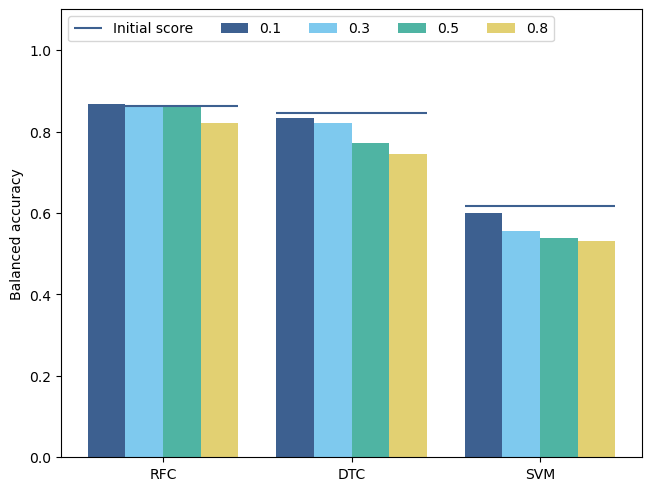

In [510]:
plot_model_accuracies(balanced_accuracies,
                      # title = "on missing data proportional to reversed feature importance",
                      filePrefix = "report_missing_importance_reversed_balanced",
                      balanced=True)

#### Experimental imputer

Dirty portion: 0.1
Missing percentage: 10.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.76      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8648658455773405
Feature importance ranking:
previous_loan_defaults_on_file    0.271519
loan_percent_income               0.181487
loan_int_rate                     0.163739
person_income                     0.127249
person_home_ownership             0.068914
loan_amnt                         0.048423
credit_score                      0.041928
loan_intent                       0.025064
person_age                        0.020119
person_emp_exp                    0.019462
cb_person_cred_hist_length        0.017395
person_education                  0.009381
person_gender          

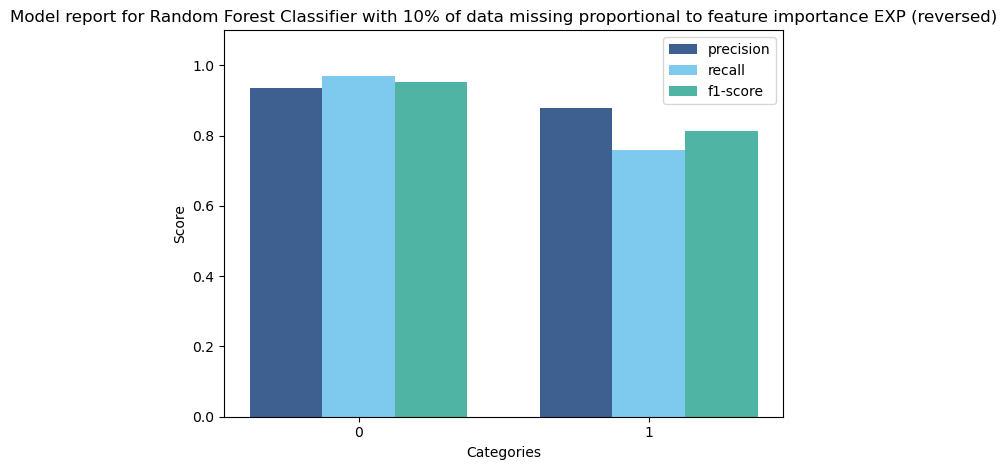

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     10533
           1       0.79      0.72      0.75      2967

    accuracy                           0.90     13500
   macro avg       0.86      0.83      0.84     13500
weighted avg       0.89      0.90      0.89     13500

Balanced accuracy:
0.831828889261992
Feature importance ranking:
previous_loan_defaults_on_file    0.263488
loan_percent_income               0.197437
loan_int_rate                     0.179430
person_income                     0.130842
credit_score                      0.042591
person_home_ownership             0.039852
loan_amnt                         0.035056
person_age                        0.024244
person_emp_exp                    0.023513
loan_intent                       0.023158
cb_person_cred_hist_length        0.021344
person_education                  0.011704
person_gender                     0.007343
dtype: float64


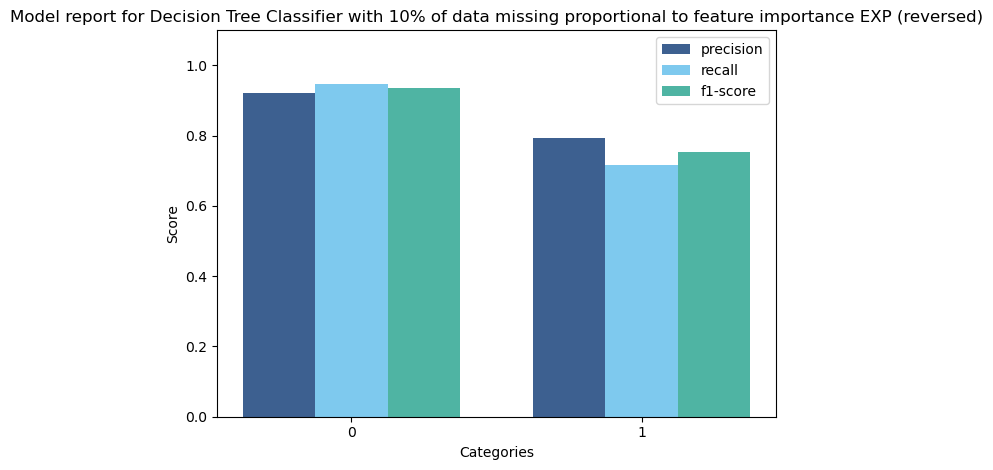

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10533
           1       0.78      0.19      0.31      2967

    accuracy                           0.81     13500
   macro avg       0.79      0.59      0.60     13500
weighted avg       0.80      0.81      0.76     13500

Balanced accuracy:
0.5881030459712683


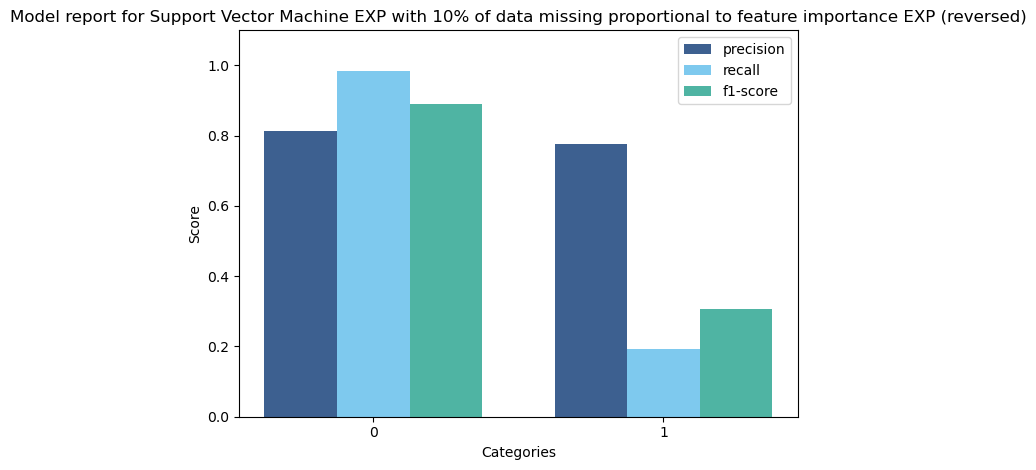

Dirty portion: 0.3
Missing percentage: 30.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     10533
           1       0.86      0.77      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.87      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8651554645004669
Feature importance ranking:
previous_loan_defaults_on_file    0.266453
loan_percent_income               0.178922
loan_int_rate                     0.154707
person_income                     0.124065
person_home_ownership             0.058206
loan_amnt                         0.051571
credit_score                      0.049279
person_age                        0.025540
person_emp_exp                    0.024321
loan_intent                       0.022583
cb_person_cred_hist_length        0.022516
person_education                  0.013153
person_gender          

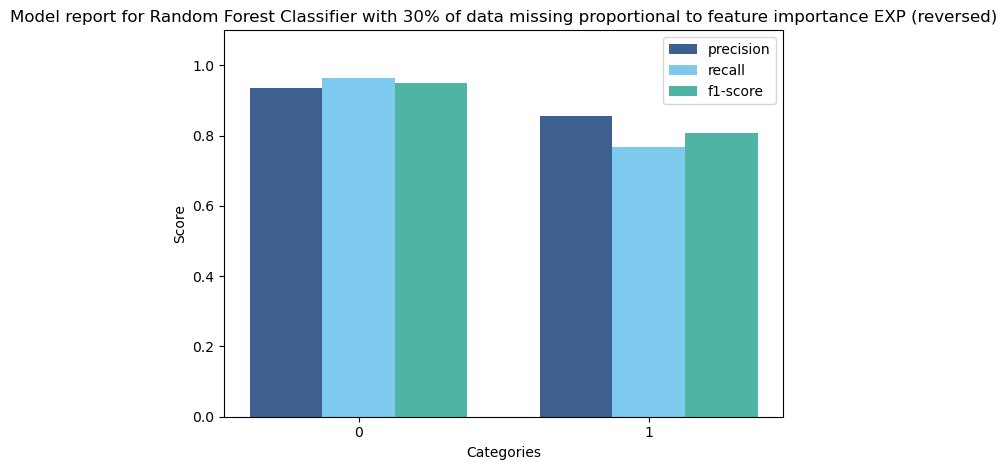

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     10533
           1       0.74      0.69      0.71      2967

    accuracy                           0.88     13500
   macro avg       0.83      0.81      0.82     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.809783676647432
Feature importance ranking:
previous_loan_defaults_on_file    0.214790
loan_int_rate                     0.173222
loan_percent_income               0.169384
person_income                     0.144367
person_home_ownership             0.068960
loan_amnt                         0.057241
credit_score                      0.046174
person_emp_exp                    0.030425
person_age                        0.025958
cb_person_cred_hist_length        0.022439
loan_intent                       0.020542
person_education                  0.014223
person_gender                     0.012274
dtype: float64


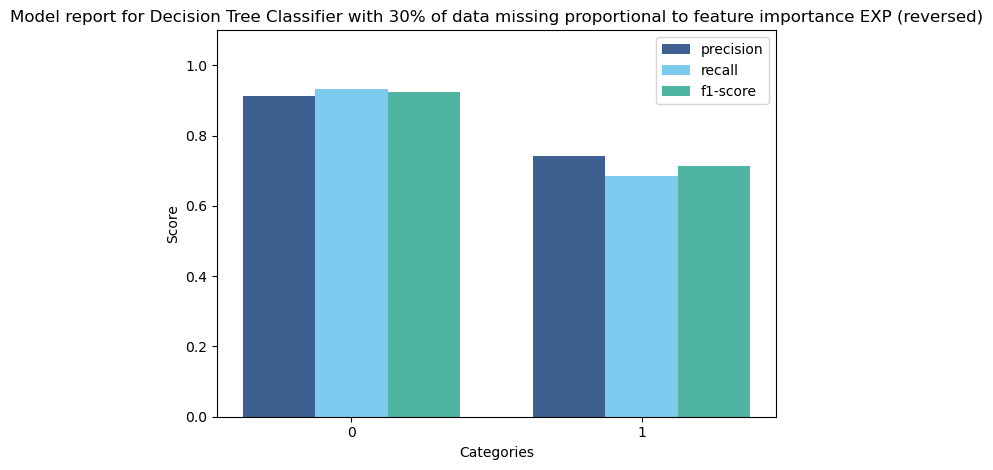

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.70      0.03      0.05      2967

    accuracy                           0.78     13500
   macro avg       0.74      0.51      0.47     13500
weighted avg       0.77      0.78      0.70     13500

Balanced accuracy:
0.5119887066859157


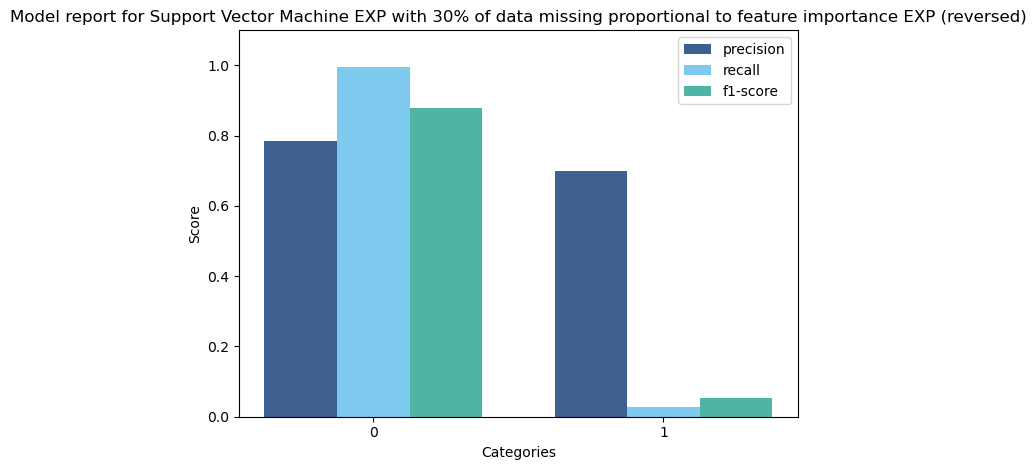

Dirty portion: 0.5
Missing percentage: 50.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     10533
           1       0.85      0.75      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.89      0.86      0.87     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8584360078973714
Feature importance ranking:
previous_loan_defaults_on_file    0.269762
loan_percent_income               0.191845
loan_int_rate                     0.146362
person_income                     0.126392
person_home_ownership             0.051984
loan_amnt                         0.046634
credit_score                      0.042917
person_age                        0.027496
person_emp_exp                    0.024877
cb_person_cred_hist_length        0.024684
loan_intent                       0.021886
person_education                  0.014621
person_gender          

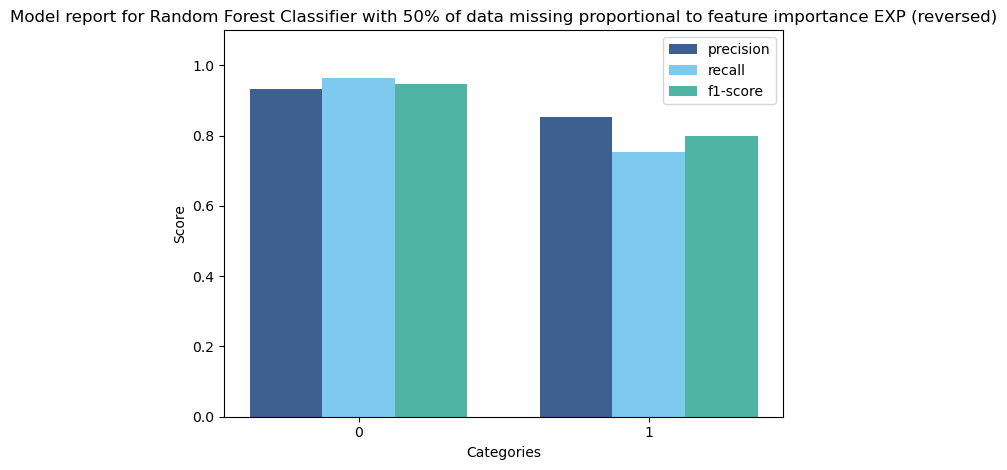

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     10533
           1       0.66      0.66      0.66      2967

    accuracy                           0.85     13500
   macro avg       0.78      0.78      0.78     13500
weighted avg       0.85      0.85      0.85     13500

Balanced accuracy:
0.7809929926043979
Feature importance ranking:
previous_loan_defaults_on_file    0.249639
loan_int_rate                     0.160166
loan_percent_income               0.153966
person_income                     0.134990
loan_amnt                         0.051415
credit_score                      0.049701
person_home_ownership             0.049556
cb_person_cred_hist_length        0.032876
person_emp_exp                    0.031797
person_age                        0.029075
loan_intent                       0.025263
person_education                  0.019395
person_gender                     0.012161
dtype: float64


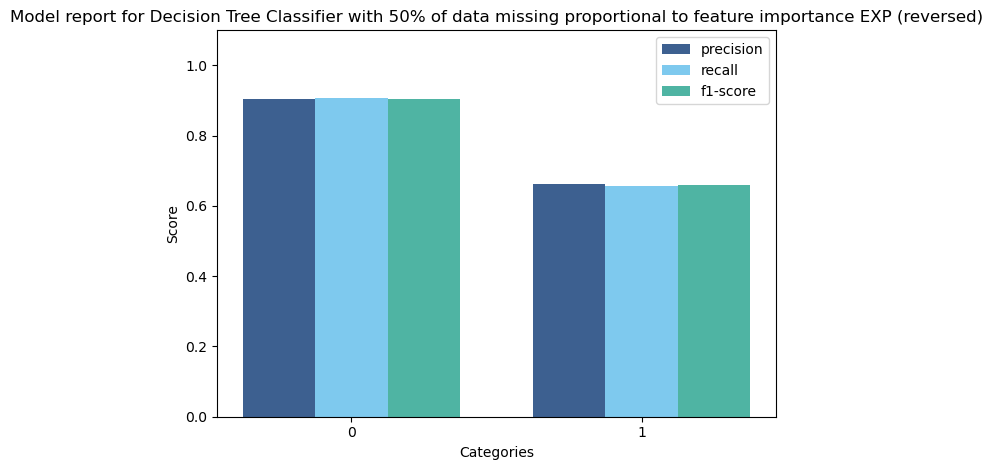

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.71      0.01      0.03      2967

    accuracy                           0.78     13500
   macro avg       0.75      0.51      0.45     13500
weighted avg       0.77      0.78      0.69     13500

Balanced accuracy:
0.5062708688577293


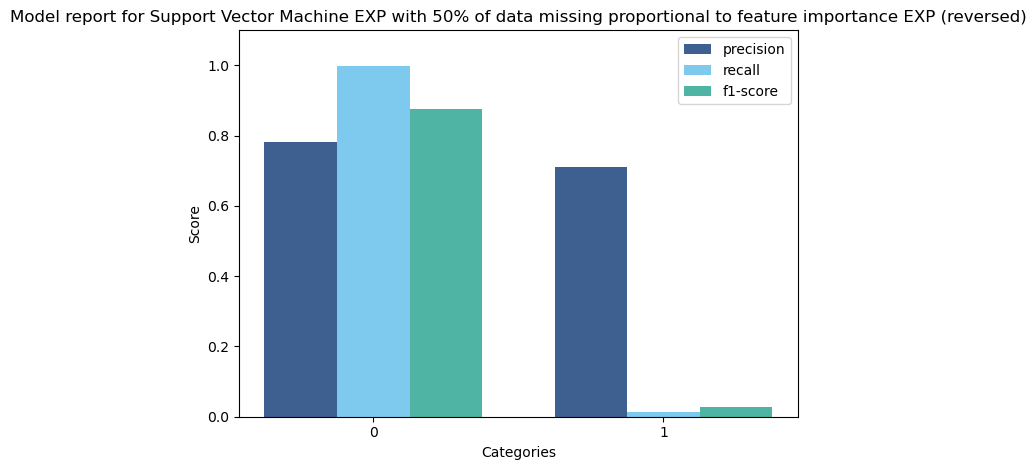

Dirty portion: 0.8
Missing percentage: 80.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10533
           1       0.81      0.75      0.78      2967

    accuracy                           0.91     13500
   macro avg       0.87      0.85      0.86     13500
weighted avg       0.90      0.91      0.91     13500

Balanced accuracy:
0.8509215151917461
Feature importance ranking:
previous_loan_defaults_on_file    0.304094
loan_percent_income               0.181015
loan_int_rate                     0.165886
person_income                     0.131305
person_home_ownership             0.045597
loan_amnt                         0.038292
credit_score                      0.035430
person_emp_exp                    0.022709
person_age                        0.021262
cb_person_cred_hist_length        0.018758
loan_intent                       0.016412
person_education                  0.010769
person_gender          

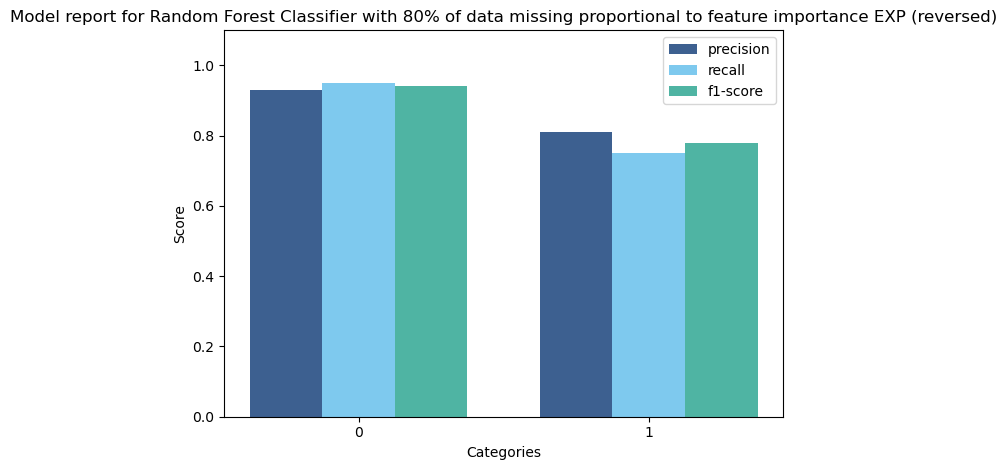

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     10533
           1       0.49      0.64      0.56      2967

    accuracy                           0.78     13500
   macro avg       0.69      0.73      0.70     13500
weighted avg       0.80      0.78      0.79     13500

Balanced accuracy:
0.7273377032480229
Feature importance ranking:
previous_loan_defaults_on_file    0.257528
loan_percent_income               0.191153
loan_int_rate                     0.163040
person_income                     0.156630
person_home_ownership             0.044302
loan_amnt                         0.034023
credit_score                      0.030836
person_age                        0.023543
cb_person_cred_hist_length        0.023476
person_emp_exp                    0.023290
loan_intent                       0.022875
person_education                  0.016315
person_gender                     0.012988
dtype: float64


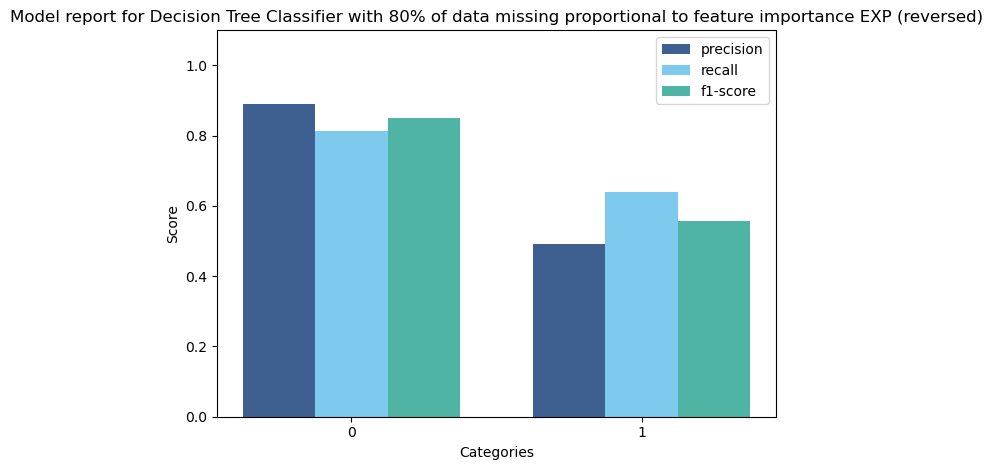

/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.50      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.64      0.50      0.44     13500
weighted avg       0.72      0.78      0.68     13500

Balanced accuracy:
0.5002421010686525


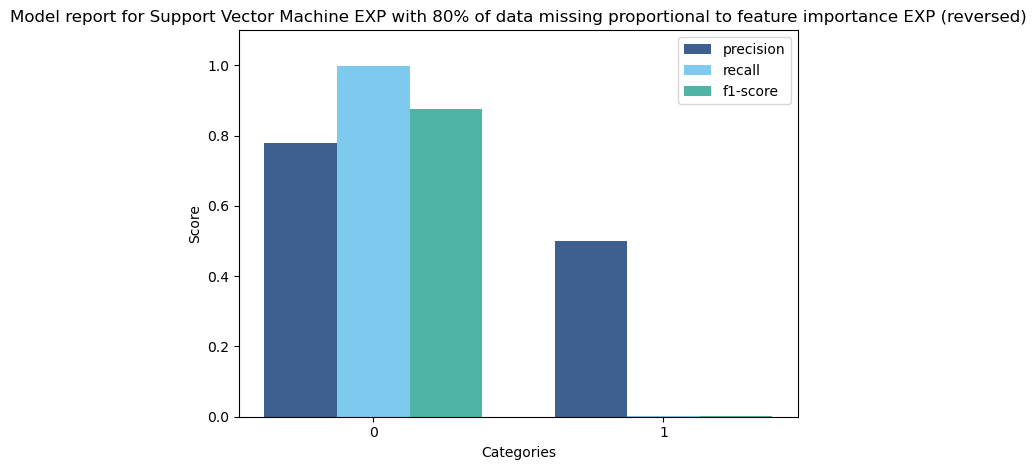

In [511]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(remove_entries_proportional_to_importance,
                                   feature_importance = inverted_feature_importances,
                                   dirty_type = "missing proportional to feature importance EXP (reversed)",
                                   file_suffix = "missing_importance_reversed_exp",
                                   experimental = True)

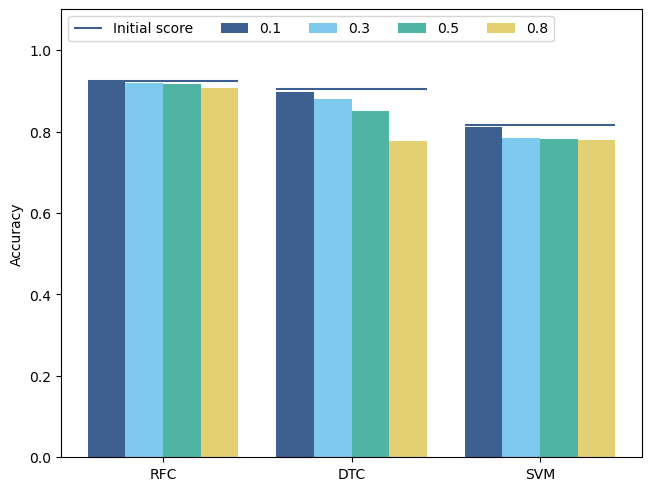

In [512]:
plot_model_accuracies(accuracies,
                      # title = "missing data proportional to reversed feature importance EXP",
                      filePrefix = "report_missing_importance_reversed_exp")

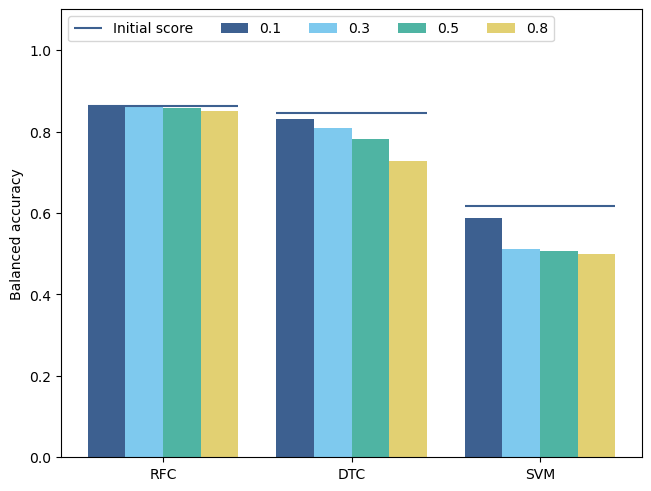

In [513]:
plot_model_accuracies(balanced_accuracies,
                      # title = "on missing data proportional to reversed feature importance EXP",
                      filePrefix = "report_missing_importance_reversed_exp_balanced",
                      balanced=True)

## Inconsistent data

### Same data with different target

In [515]:
def duplicate_records_with_modified_loan_status(X_in, y_in, portion):
    X = X_in.copy()
    y = y_in.copy()
    X['loan_status'] = y
    df = X
    
    # # Calculate the number of records to duplicate
    # num_records_to_duplicate = int(len(df) * portion)
    
    # # Randomly sample records to duplicate
    # records_to_duplicate = df.sample(n=num_records_to_duplicate, random_state=0)
    records_to_duplicate = df.sample(frac=portion, random_state=0)
    
    # Create a copy of the selected records and modify the loan_status column to the opposite value
    duplicated_records = records_to_duplicate.copy()
    # duplicated_records['loan_status'] = duplicated_records['loan_status'].cat.codes.apply(lambda x: 1 - x).astype('category')
    # duplicated_records['loan_status'] = duplicated_records['loan_status'].apply(lambda x: not x).astype('bool')
    duplicated_records['loan_status'] = duplicated_records['loan_status'].apply(lambda x: 0 if x == 1 else 1).astype('category')
    
    # Concatenate original dataframe with duplicated records
    # res = pd.concat([df, duplicated_records], ignore_index=True)
    res = pd.concat([df, duplicated_records])
    
    return get_XY(res)

#### Running models

Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.76      0.82      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.87      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8652194936094245
Feature importance ranking:
previous_loan_defaults_on_file    0.232785
loan_percent_income               0.165957
loan_int_rate                     0.161760
person_income                     0.131145
person_home_ownership             0.064294
loan_amnt                         0.058729
credit_score                      0.057434
loan_intent                       0.033034
person_age                        0.026186
person_emp_exp                    0.024754
cb_person_cred_hist_length        0.022472
person_education                  0.014651
person_gender           

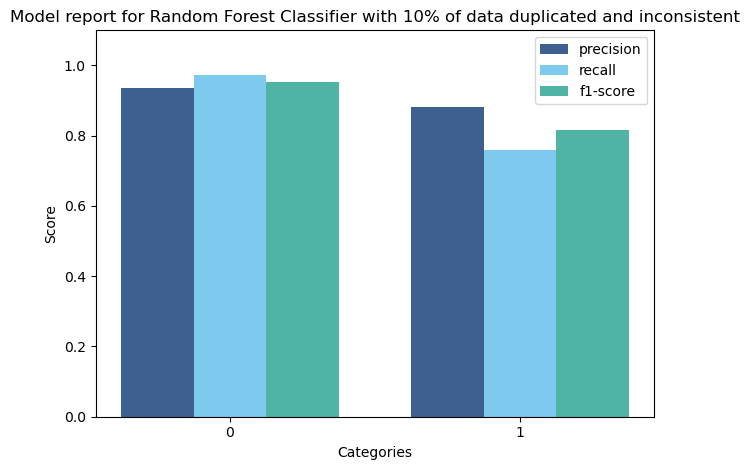

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     10533
           1       0.80      0.66      0.73      2967

    accuracy                           0.89     13500
   macro avg       0.86      0.81      0.83     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8096577303341599
Feature importance ranking:
previous_loan_defaults_on_file    0.243409
loan_percent_income               0.183474
loan_int_rate                     0.176787
person_income                     0.138852
person_home_ownership             0.050457
credit_score                      0.044610
loan_amnt                         0.041650
loan_intent                       0.030988
person_age                        0.025143
person_emp_exp                    0.023392
cb_person_cred_hist_length        0.020587
person_education                  0.014693
person_gender                     0.005959
dtype: float64


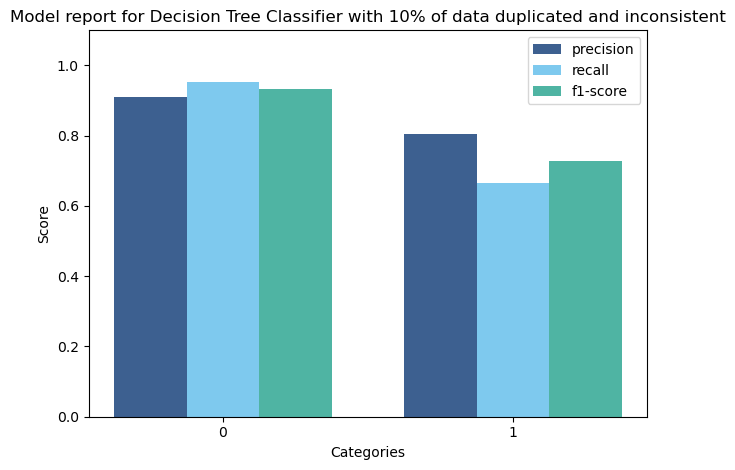

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     10533
           1       0.75      0.24      0.36      2967

    accuracy                           0.82     13500
   macro avg       0.78      0.61      0.63     13500
weighted avg       0.80      0.82      0.78     13500

Balanced accuracy:
0.608809743022483


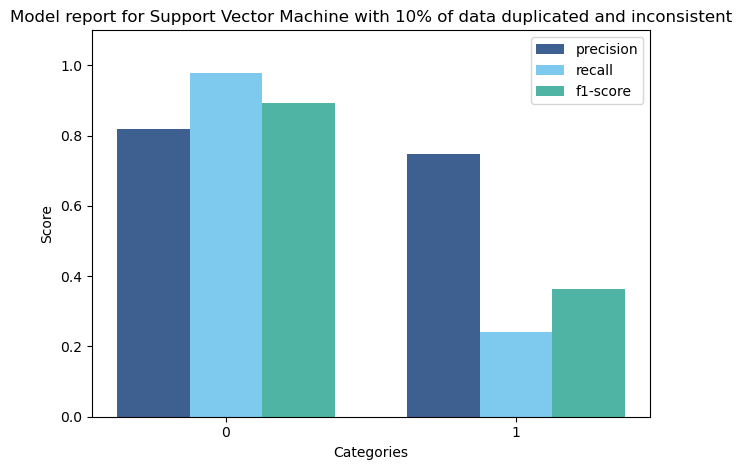

Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.75      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8631972489178168
Feature importance ranking:
previous_loan_defaults_on_file    0.154187
loan_int_rate                     0.152142
loan_percent_income               0.140954
person_income                     0.138069
credit_score                      0.086004
loan_amnt                         0.076158
person_home_ownership             0.050065
person_age                        0.045210
person_emp_exp                    0.043517
loan_intent                       0.039275
cb_person_cred_hist_length        0.037843
person_education                  0.024010
person_gender           

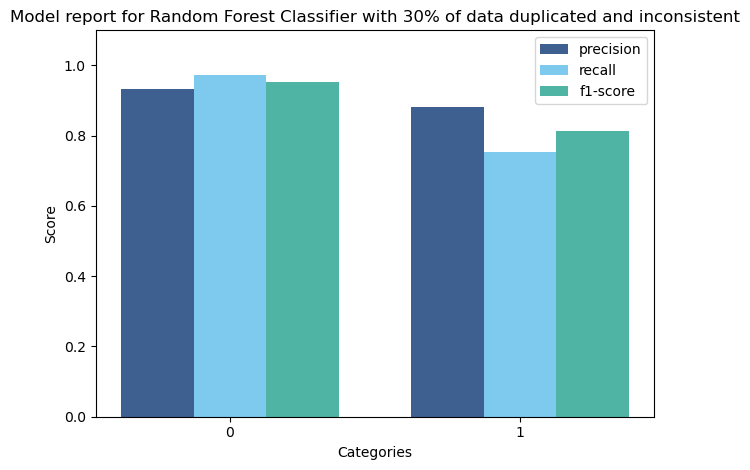

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     10533
           1       0.78      0.63      0.70      2967

    accuracy                           0.88     13500
   macro avg       0.84      0.79      0.81     13500
weighted avg       0.87      0.88      0.87     13500

Balanced accuracy:
0.7885428597127982
Feature importance ranking:
previous_loan_defaults_on_file    0.182189
loan_percent_income               0.164275
loan_int_rate                     0.163981
person_income                     0.136107
credit_score                      0.074051
loan_amnt                         0.058591
person_home_ownership             0.042427
loan_intent                       0.040381
person_age                        0.039550
person_emp_exp                    0.035262
cb_person_cred_hist_length        0.032599
person_education                  0.018676
person_gender                     0.011913
dtype: float64


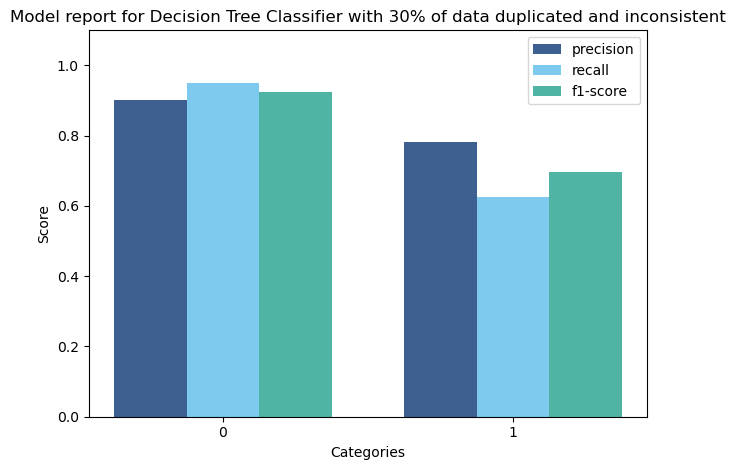

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     10533
           1       0.78      0.20      0.32      2967

    accuracy                           0.81     13500
   macro avg       0.79      0.59      0.61     13500
weighted avg       0.81      0.81      0.77     13500

Balanced accuracy:
0.5930209999158118


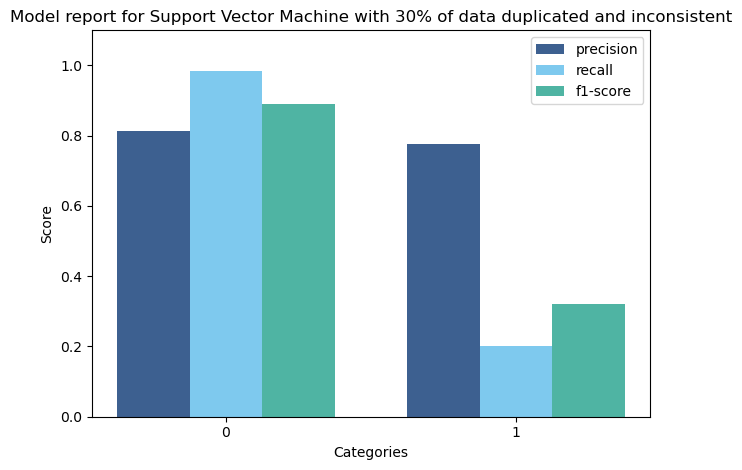

Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.75      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8603110432357759
Feature importance ranking:
loan_int_rate                     0.146901
person_income                     0.144574
loan_percent_income               0.119647
credit_score                      0.111741
loan_amnt                         0.092851
previous_loan_defaults_on_file    0.086682
person_age                        0.059688
person_emp_exp                    0.058411
cb_person_cred_hist_length        0.051285
loan_intent                       0.043848
person_home_ownership             0.034803
person_education                  0.033359
person_gender           

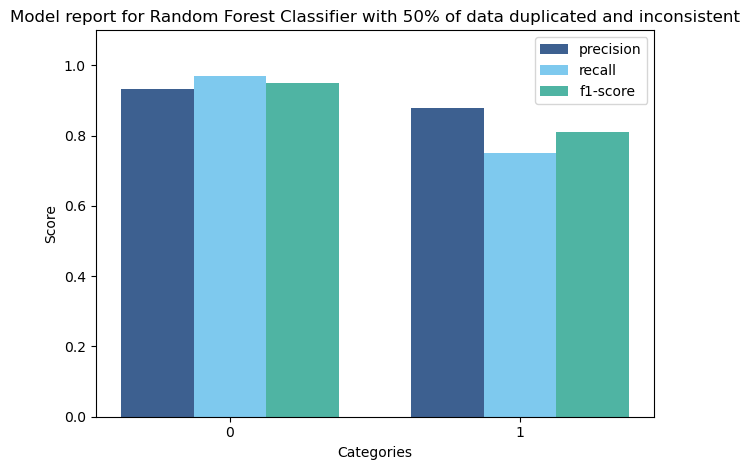

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     10533
           1       0.82      0.60      0.69      2967

    accuracy                           0.88     13500
   macro avg       0.86      0.78      0.81     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.7825377548552928
Feature importance ranking:
person_income                     0.195253
loan_int_rate                     0.153274
previous_loan_defaults_on_file    0.139636
loan_percent_income               0.096033
credit_score                      0.089050
loan_amnt                         0.075365
person_emp_exp                    0.053100
person_age                        0.052092
person_home_ownership             0.040045
cb_person_cred_hist_length        0.036484
loan_intent                       0.034810
person_education                  0.023769
person_gender                     0.011090
dtype: float64


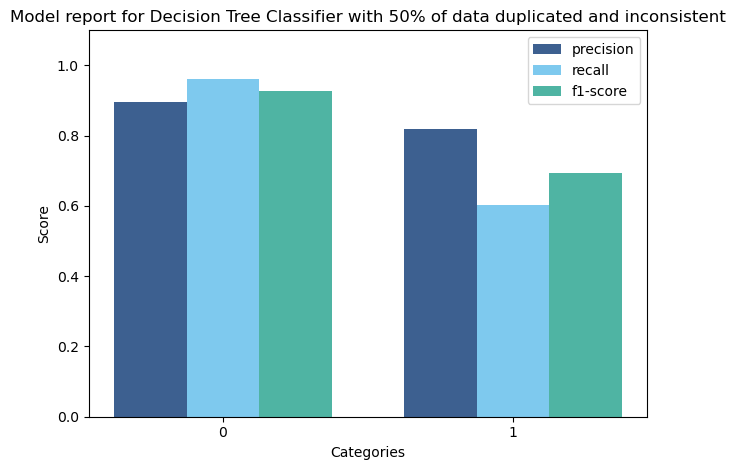

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     10533
           1       0.80      0.16      0.26      2967

    accuracy                           0.81     13500
   macro avg       0.80      0.57      0.57     13500
weighted avg       0.80      0.81      0.75     13500

Balanced accuracy:
0.5723973871131771


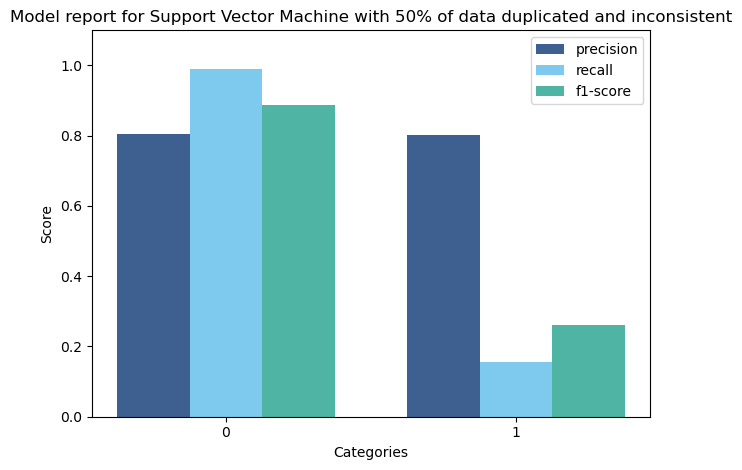

Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10533
           1       0.82      0.73      0.77      2967

    accuracy                           0.90     13500
   macro avg       0.87      0.84      0.85     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8410761037317643
Feature importance ranking:
person_income                     0.153143
loan_int_rate                     0.140392
credit_score                      0.137309
loan_amnt                         0.108832
loan_percent_income               0.097136
person_age                        0.073049
person_emp_exp                    0.072647
cb_person_cred_hist_length        0.063276
loan_intent                       0.051545
person_education                  0.040698
person_home_ownership             0.021318
previous_loan_defaults_on_file    0.020823
person_gender           

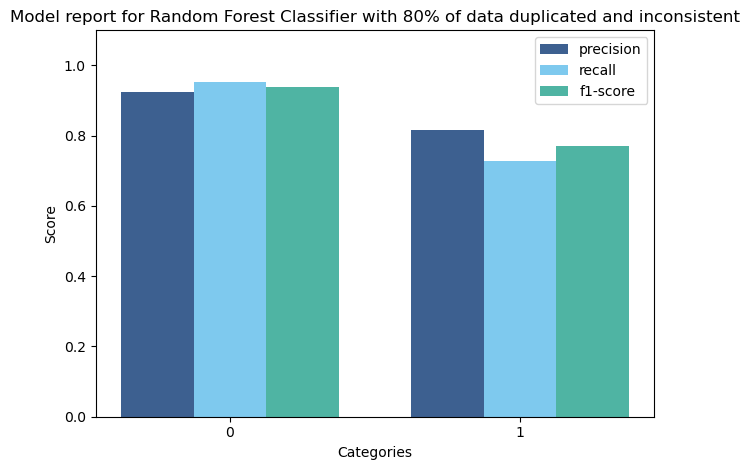

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     10533
           1       0.75      0.50      0.60      2967

    accuracy                           0.85     13500
   macro avg       0.81      0.73      0.76     13500
weighted avg       0.84      0.85      0.84     13500

Balanced accuracy:
0.7276286661104678
Feature importance ranking:
person_income                     0.161513
loan_int_rate                     0.136053
credit_score                      0.112618
loan_amnt                         0.098447
loan_percent_income               0.089358
cb_person_cred_hist_length        0.074807
person_emp_exp                    0.068263
previous_loan_defaults_on_file    0.066762
person_age                        0.061019
loan_intent                       0.048215
person_education                  0.039366
person_home_ownership             0.025044
person_gender                     0.018534
dtype: float64


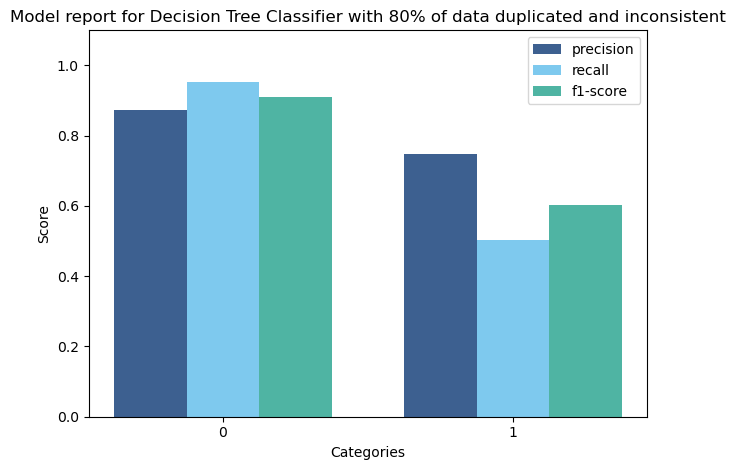

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     10533
           1       0.86      0.06      0.11      2967

    accuracy                           0.79     13500
   macro avg       0.83      0.53      0.50     13500
weighted avg       0.81      0.79      0.71     13500

Balanced accuracy:
0.5292940853134599


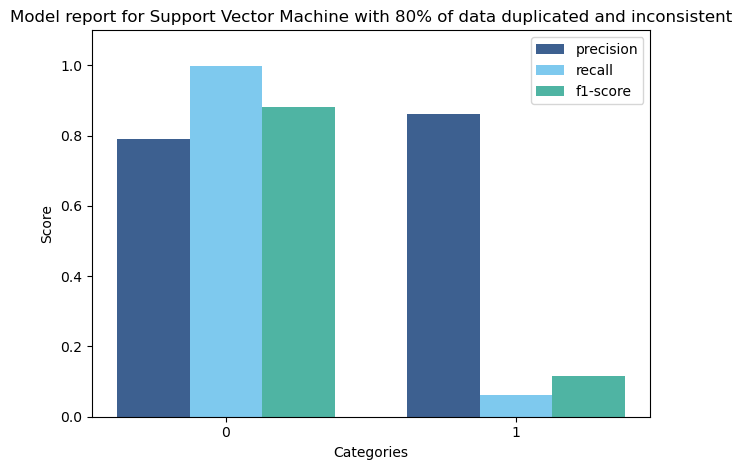

In [522]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(duplicate_records_with_modified_loan_status,
                                   modifies_target = True,
                                   dirty_type = "duplicated and inconsistent",
                                   file_suffix = "duplicated_inconsistent")

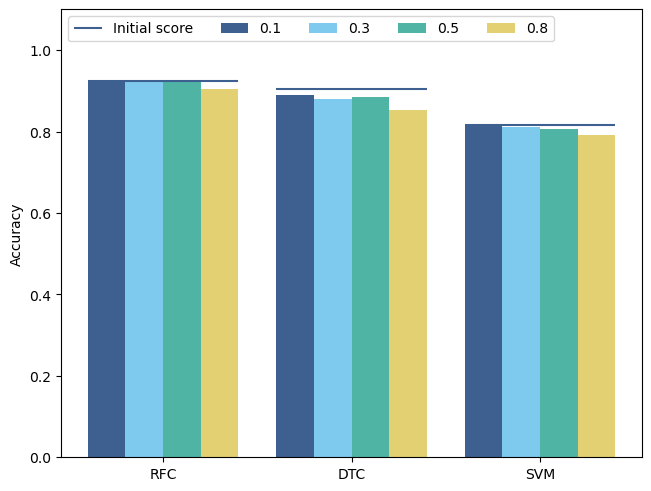

In [523]:
plot_model_accuracies(accuracies,
                      # title = " records duplicated and made inconsistent",
                      filePrefix = "report_duplicated_inconsistent")

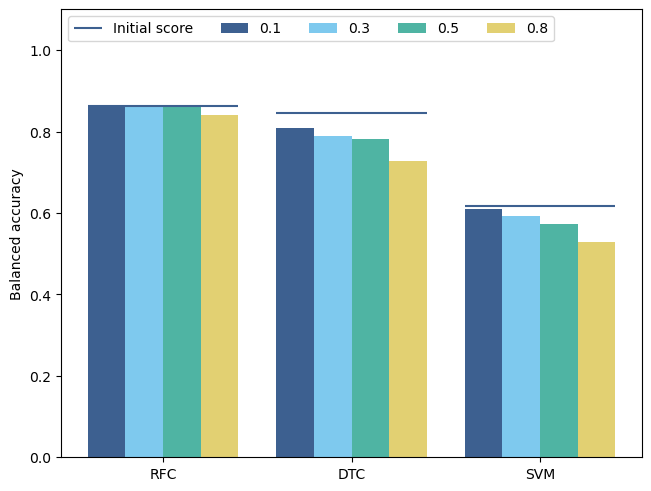

In [524]:
plot_model_accuracies(balanced_accuracies,
                      # title = "records duplicated and made inconsistent",
                      filePrefix = "report_duplicated_inconsistent_balanced",
                      balanced=True)

### Internal inconsistencies

In [525]:
def introduce_internal_inconsistencies(df, portion):
    """
    In this case, portion represent the percentage of rows to modify, not the percentage of cells!
    """
    df_inconst = df.copy()
    num_rows_to_modify = int(len(df_inconst) * portion)
    
    indices_to_modify = df_inconst.sample(n=num_rows_to_modify).index
    
    for idx in indices_to_modify:
        option = rand.choice(3)
        if option == 0: # Younger than work experience
            age = df_inconst.loc[idx, 'person_age']
            df_inconst.at[idx, 'person_emp_exp'] = age + age * rand.random()
        elif option == 1: # Younger than credit history
            age = df_inconst.loc[idx, 'person_age']
            df_inconst.at[idx, 'cb_person_cred_hist_length'] = age + age * rand.random()
        elif option == 2: # Low age given education
            if df_inconst.loc[idx, 'person_education'] == 'High school':
                df_inconst.at[idx, 'person_age'] = rand.choice(15) + 1
            elif df_inconst.loc[idx, 'person_education'] == 'Associate':
                df_inconst.at[idx, 'person_age'] = rand.choice(17) + 1
            elif df_inconst.loc[idx, 'person_education'] == 'Bachelor':
                df_inconst.at[idx, 'person_age'] = rand.choice(19) + 1
            elif df_inconst.loc[idx, 'person_education'] == 'Master':
                df_inconst.at[idx, 'person_age'] = rand.choice(20) + 1
            elif df_inconst.loc[idx, 'person_education'] == 'Doctorate':
                df_inconst.at[idx, 'person_age'] = rand.choice(22) + 1
            
    
    return df_inconst

#### Running models

/var/folders/24/1bbyrjmj1g75kz77ld7x6r6w0000gn/T/ipykernel_13973/2607348057.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29.270840739326502' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_inconst.at[idx, 'person_emp_exp'] = age + age * rand.random()


Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.76      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8635129306641547
Feature importance ranking:
previous_loan_defaults_on_file    0.287416
loan_percent_income               0.184797
loan_int_rate                     0.168333
person_income                     0.122802
person_home_ownership             0.072523
loan_amnt                         0.043533
credit_score                      0.037369
loan_intent                       0.029008
person_age                        0.015436
person_emp_exp                    0.014288
cb_person_cred_hist_length        0.013237
person_education                  0.007484
person_gender           

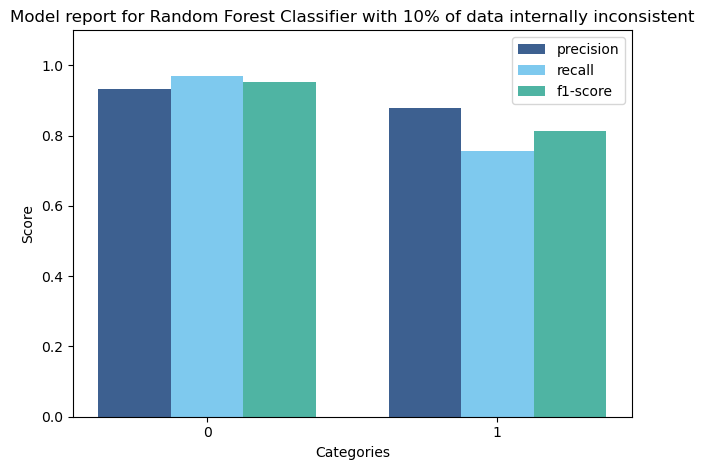

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     10533
           1       0.83      0.75      0.79      2967

    accuracy                           0.91     13500
   macro avg       0.88      0.85      0.87     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8542800195485574
Feature importance ranking:
previous_loan_defaults_on_file    0.289848
loan_int_rate                     0.192662
loan_percent_income               0.178915
person_income                     0.135407
person_home_ownership             0.048183
credit_score                      0.037081
loan_intent                       0.033249
loan_amnt                         0.023491
person_age                        0.016775
cb_person_cred_hist_length        0.016470
person_emp_exp                    0.015611
person_education                  0.008450
person_gender                     0.003856
dtype: float64


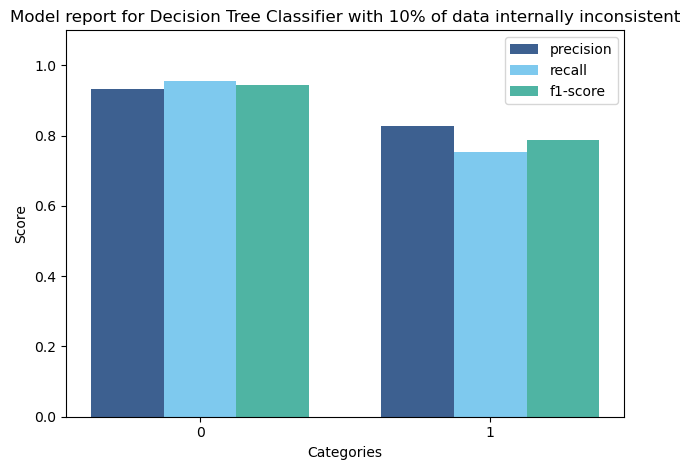

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10533
           1       0.74      0.26      0.38      2967

    accuracy                           0.82     13500
   macro avg       0.78      0.62      0.64     13500
weighted avg       0.80      0.82      0.78     13500

Balanced accuracy:
0.6161748184745962


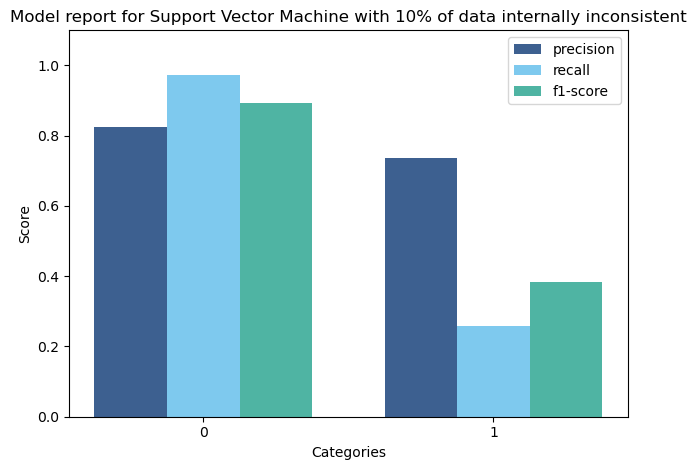

/var/folders/24/1bbyrjmj1g75kz77ld7x6r6w0000gn/T/ipykernel_13973/2607348057.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.823484300088346' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_inconst.at[idx, 'person_emp_exp'] = age + age * rand.random()


Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.76      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8641134315503387
Feature importance ranking:
previous_loan_defaults_on_file    0.291683
loan_percent_income               0.173209
loan_int_rate                     0.165541
person_income                     0.127887
person_home_ownership             0.071651
loan_amnt                         0.046510
credit_score                      0.037406
loan_intent                       0.028154
person_age                        0.016040
person_emp_exp                    0.015975
cb_person_cred_hist_length        0.014479
person_education                  0.007614
person_gender           

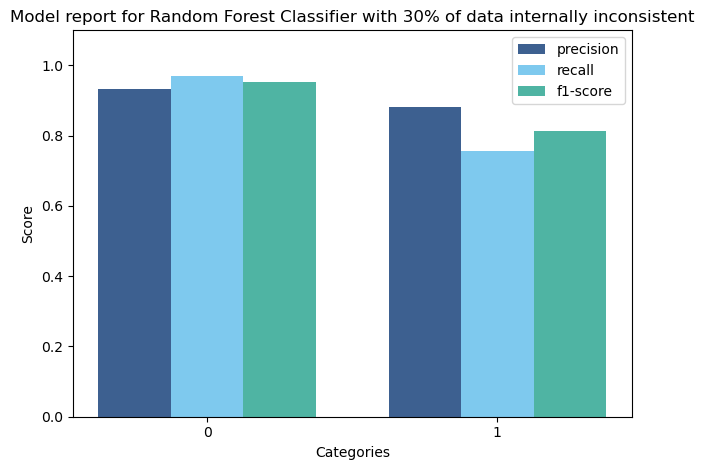

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10533
           1       0.81      0.73      0.76      2967

    accuracy                           0.90     13500
   macro avg       0.87      0.84      0.85     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8379715559083076
Feature importance ranking:
loan_percent_income               0.252845
previous_loan_defaults_on_file    0.225228
loan_int_rate                     0.182331
person_income                     0.130376
person_home_ownership             0.060835
credit_score                      0.032536
loan_amnt                         0.026671
loan_intent                       0.025895
person_age                        0.020513
person_emp_exp                    0.019017
cb_person_cred_hist_length        0.014092
person_education                  0.007061
person_gender                     0.002600
dtype: float64


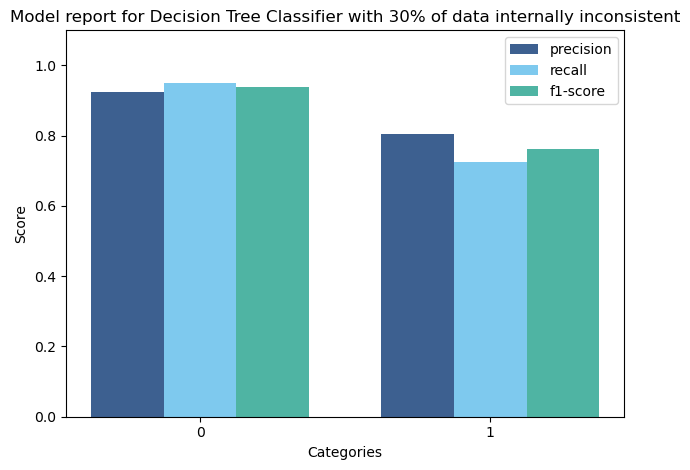

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10533
           1       0.74      0.26      0.38      2967

    accuracy                           0.82     13500
   macro avg       0.78      0.62      0.64     13500
weighted avg       0.80      0.82      0.78     13500

Balanced accuracy:
0.6161748184745962


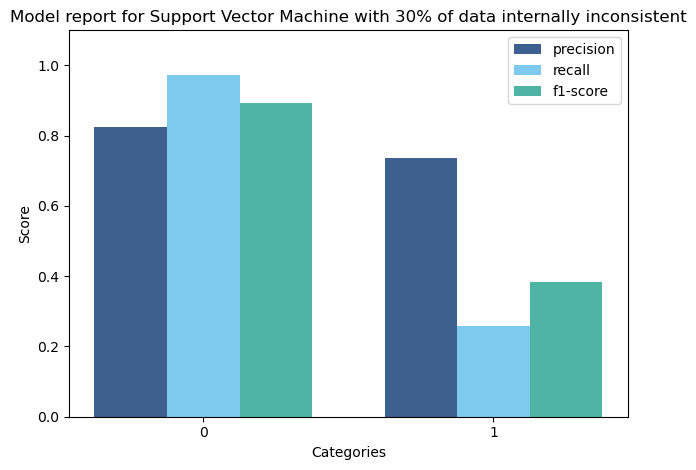

/var/folders/24/1bbyrjmj1g75kz77ld7x6r6w0000gn/T/ipykernel_13973/2607348057.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.348902452838274' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_inconst.at[idx, 'person_emp_exp'] = age + age * rand.random()


Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.89      0.76      0.82      2967

    accuracy                           0.93     13500
   macro avg       0.91      0.87      0.88     13500
weighted avg       0.92      0.93      0.92     13500

Balanced accuracy:
0.8650201106119657
Feature importance ranking:
previous_loan_defaults_on_file    0.287218
loan_percent_income               0.179448
loan_int_rate                     0.164592
person_income                     0.123368
person_home_ownership             0.071551
loan_amnt                         0.045982
credit_score                      0.037639
loan_intent                       0.029629
person_age                        0.017277
person_emp_exp                    0.016499
cb_person_cred_hist_length        0.015577
person_education                  0.007377
person_gender           

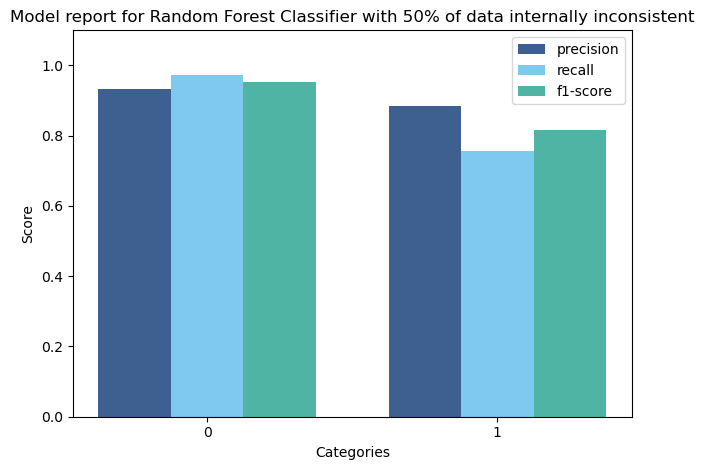

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     10533
           1       0.82      0.73      0.77      2967

    accuracy                           0.91     13500
   macro avg       0.87      0.84      0.86     13500
weighted avg       0.90      0.91      0.90     13500

Balanced accuracy:
0.8418878430801092
Feature importance ranking:
previous_loan_defaults_on_file    0.218076
loan_int_rate                     0.182775
person_income                     0.164095
loan_percent_income               0.126736
loan_amnt                         0.099304
person_home_ownership             0.077770
credit_score                      0.032859
loan_intent                       0.030010
person_age                        0.021233
person_emp_exp                    0.017764
cb_person_cred_hist_length        0.017720
person_education                  0.007822
person_gender                     0.003835
dtype: float64


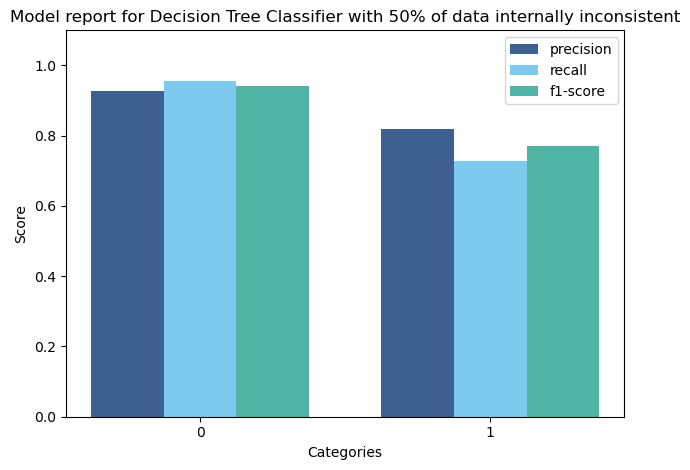

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10533
           1       0.74      0.26      0.38      2967

    accuracy                           0.82     13500
   macro avg       0.78      0.62      0.64     13500
weighted avg       0.80      0.82      0.78     13500

Balanced accuracy:
0.616006298083629


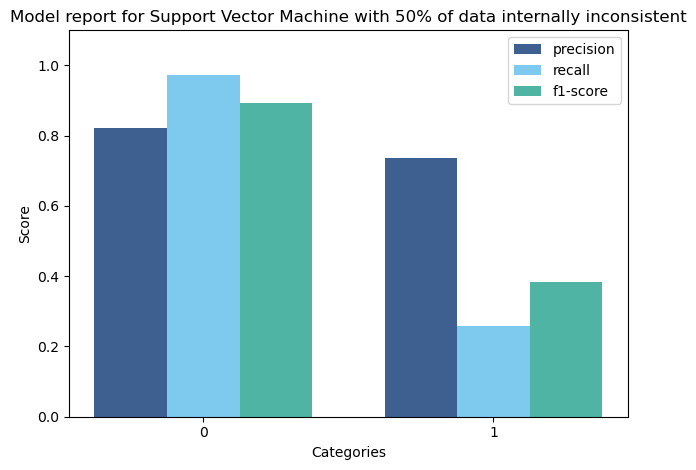

/var/folders/24/1bbyrjmj1g75kz77ld7x6r6w0000gn/T/ipykernel_13973/2607348057.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '65.90821643359968' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_inconst.at[idx, 'person_emp_exp'] = age + age * rand.random()


Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10533
           1       0.88      0.76      0.82      2967

    accuracy                           0.93     13500
   macro avg       0.91      0.87      0.89     13500
weighted avg       0.92      0.93      0.92     13500

Balanced accuracy:
0.866615126593804
Feature importance ranking:
previous_loan_defaults_on_file    0.290077
loan_percent_income               0.174358
loan_int_rate                     0.163917
person_income                     0.124869
person_home_ownership             0.073131
loan_amnt                         0.045911
credit_score                      0.037495
loan_intent                       0.028485
person_emp_exp                    0.017276
person_age                        0.017142
cb_person_cred_hist_length        0.016342
person_education                  0.007414
person_gender            

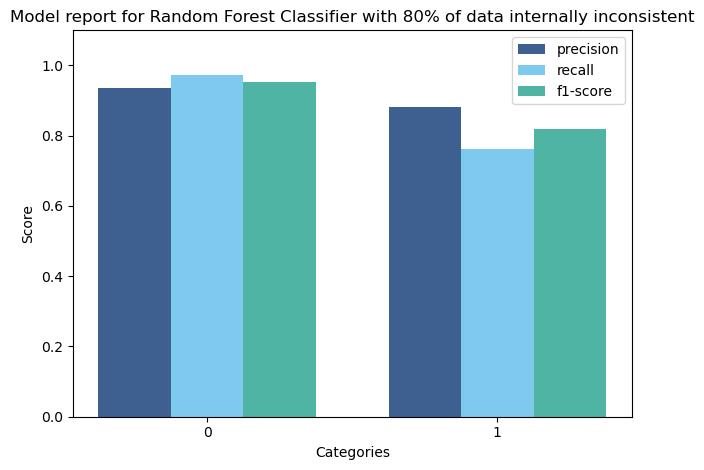

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     10533
           1       0.81      0.75      0.77      2967

    accuracy                           0.90     13500
   macro avg       0.87      0.85      0.86     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8477077722986652
Feature importance ranking:
previous_loan_defaults_on_file    0.252355
loan_int_rate                     0.192444
person_income                     0.173282
loan_amnt                         0.089217
loan_percent_income               0.084420
person_home_ownership             0.063173
credit_score                      0.042052
loan_intent                       0.031402
person_emp_exp                    0.021945
person_age                        0.020970
cb_person_cred_hist_length        0.015926
person_education                  0.009140
person_gender                     0.003675
dtype: float64


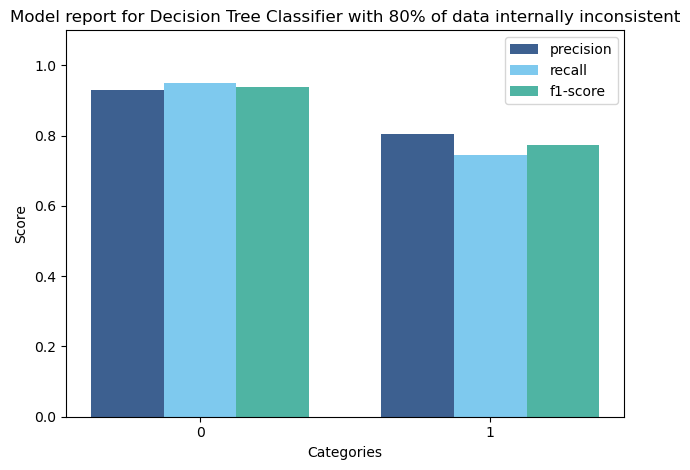

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     10533
           1       0.74      0.26      0.38      2967

    accuracy                           0.82     13500
   macro avg       0.78      0.62      0.64     13500
weighted avg       0.80      0.82      0.78     13500

Balanced accuracy:
0.6161748184745962


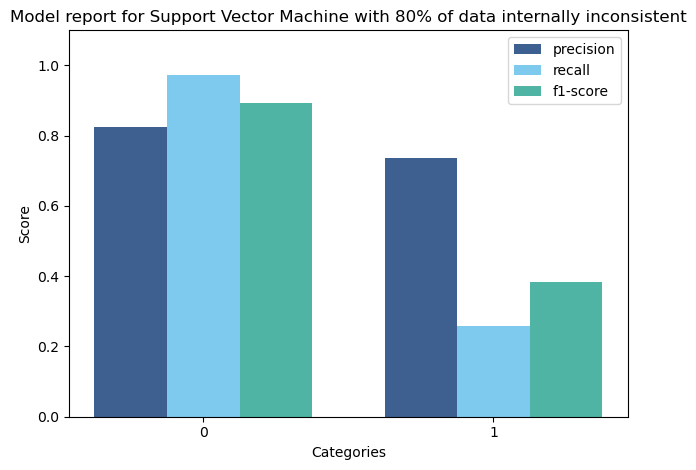

In [526]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(introduce_internal_inconsistencies,
                                   dirty_type = "internally inconsistent",
                                   file_suffix = "internally_inconsistent")

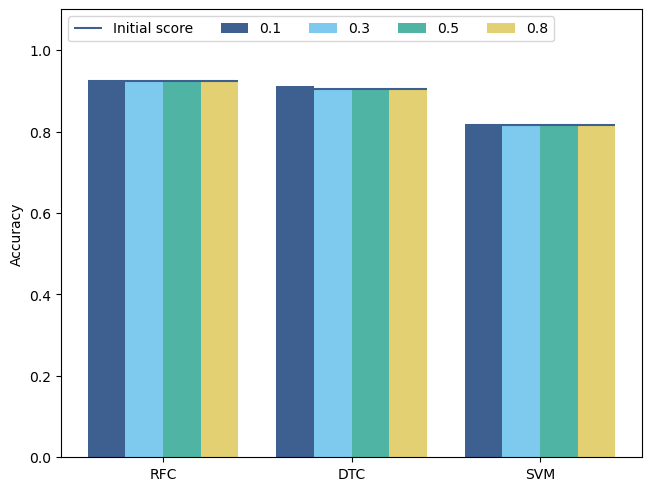

In [527]:
plot_model_accuracies(accuracies,
                      # title = "internally inconsistent records",
                      filePrefix = "report_internally_inconsistent")

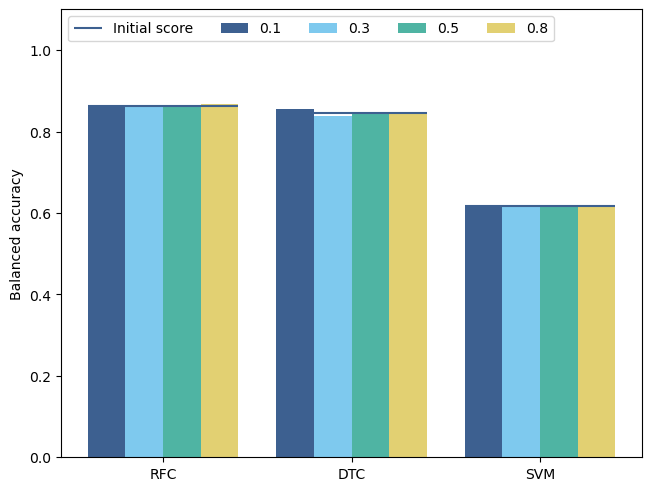

In [528]:
plot_model_accuracies(balanced_accuracies,
                      # title = "internally inconsistent records",
                      filePrefix = "report_internally_inconsistent_balanced",
                      balanced=True)

## Outliers

### At random

In [529]:
def introduce_outliers(df, portion):
    """
    Introduces outliers into a DataFrame.

    Parameters:
    - df: pandas.DataFrame
        The input DataFrame.
    - portion: float
        A value between 0 and 1 representing the fraction of NUMERICAL cells to be modified as outliers.

    Returns:
    - pandas.DataFrame
        A DataFrame with a portion of NUMERICAL cells replaced by outlier values.
    """     
    # Isolate numerical columns
    numericals = df.drop(columns=categoricals[0:5])
    num_outliers = int(numericals.size * portion)
    
    # Create a mask where each element has a probability `portion` of being True
    mask = np.random.rand(*numericals.shape) < portion
    
    tmp = numericals.copy()

    # This logic works, but it is kinda slow...
    for idx in tmp.index:
        for col in numericals.columns:
            # old
            # tmp[col] = numericals[col].mean() + rand.random() * 3 * numericals[col].std()
            # tmp[col] = 666 - tmp[col]
            # tmp[col] = numericals[col].median() + rand.random() * 10 * numericals[col].std() - tmp[col]

            # Add or subtract, kinda meh
            # This is noise rather than outliers tho
            # if rand.choice(2) == 0:
            #     modifier = numericals[col].median() + rand.random() * 10 * numericals[col].std()
            # else:
            #     modifier = numericals[col].median() - rand.random() * 10 * numericals[col].std()

            # Actual outliers
            if rand.choice(2) == 0:
                modifier = numericals[col].median() + 3 * numericals[col].std() + rand.random() * 30 * numericals[col].std()
            else:
                modifier = numericals[col].median() - 3 * numericals[col].std() - rand.random() * 30 * numericals[col].std()
            
            tmp.at[idx, col] = int(modifier - numericals.loc[idx, col])

    tmp = tmp * mask
    df_outliers = pd.concat([tmp + numericals, df[categoricals[0:5]]], axis=1)
    
    return df_outliers[df.columns]

#### Outliers visualization

In [530]:
X_out = introduce_outliers(X_train, 0.1)

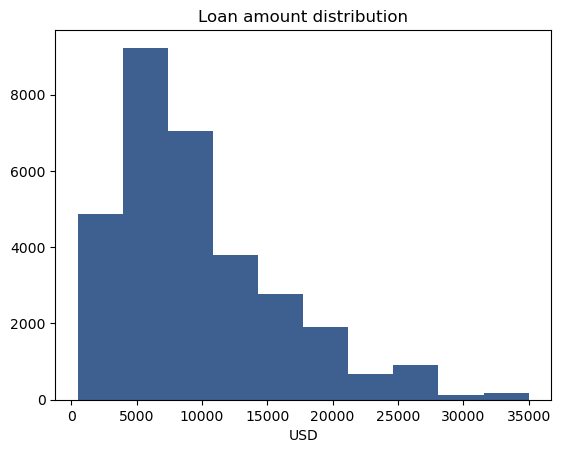

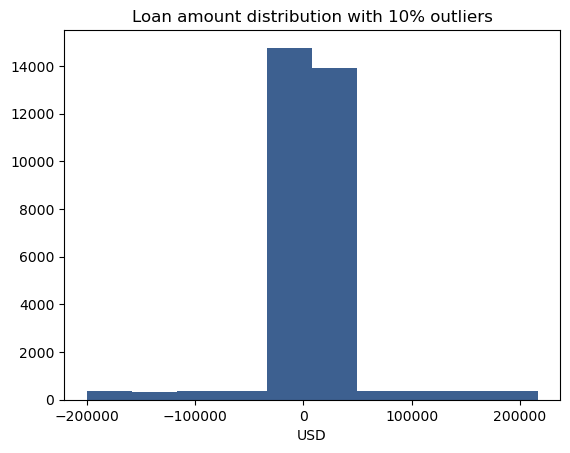

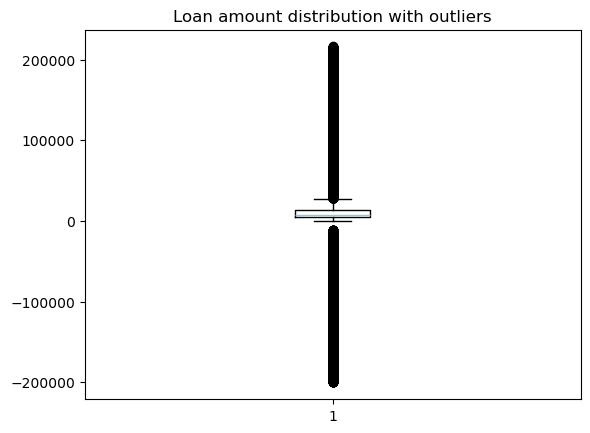

In [531]:
# X, y = get_XY(data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
plt.hist(X_train['loan_amnt'])
plt.title("Loan amount distribution")
plt.xlabel("USD")
plt.savefig("images/loan_amount_distribution.svg")
plt.show()

plt.hist(X_out['loan_amnt'])
plt.title("Loan amount distribution with 10% outliers")
plt.xlabel("USD")
plt.savefig("images/loan_amount_distribution_10_outliers.svg")
plt.show()

plt.boxplot(X_out['loan_amnt'])
plt.xticks()
plt.title("Loan amount distribution with outliers")
plt.show()
# X_out

#### Running models

Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.89      0.76      0.82      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8639828774451176
Feature importance ranking:
previous_loan_defaults_on_file    0.317492
loan_percent_income               0.169691
loan_int_rate                     0.145268
person_income                     0.109078
person_home_ownership             0.075544
loan_amnt                         0.044400
credit_score                      0.040140
loan_intent                       0.030362
person_age                        0.018875
person_emp_exp                    0.018080
cb_person_cred_hist_length        0.017414
person_education                  0.009309
person_gender           

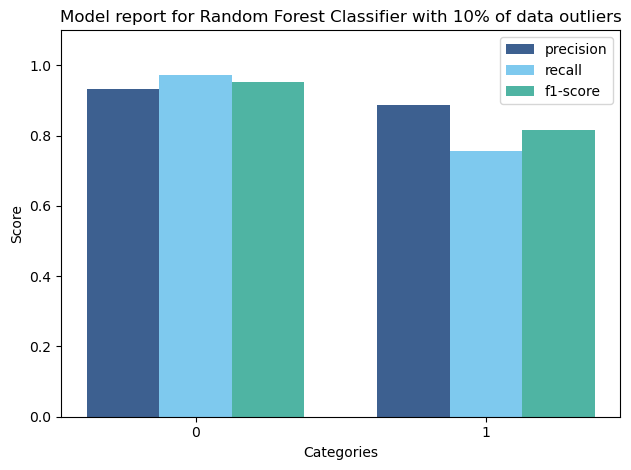

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10533
           1       0.82      0.72      0.77      2967

    accuracy                           0.90     13500
   macro avg       0.87      0.84      0.85     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8391392951825438
Feature importance ranking:
previous_loan_defaults_on_file    0.284818
loan_int_rate                     0.182262
person_income                     0.127677
loan_percent_income               0.107227
loan_amnt                         0.068163
person_home_ownership             0.050660
loan_intent                       0.050637
credit_score                      0.039641
person_emp_exp                    0.024039
person_age                        0.023693
cb_person_cred_hist_length        0.023596
person_education                  0.012990
person_gender                     0.004597
dtype: float64


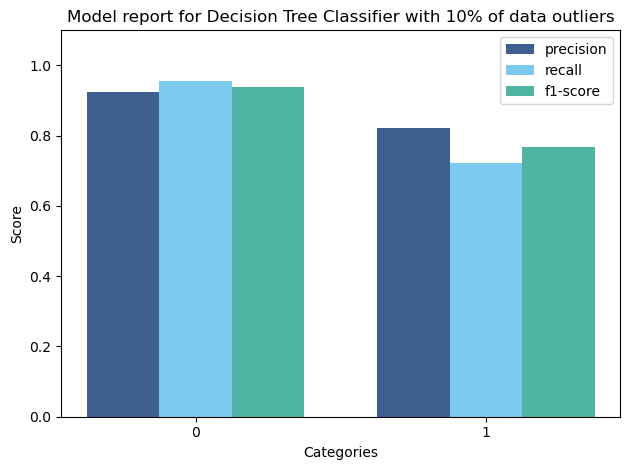

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

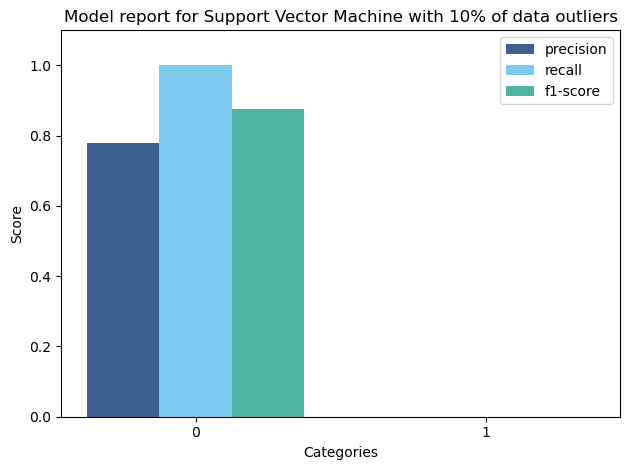

Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.88      0.75      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8614811824016522
Feature importance ranking:
previous_loan_defaults_on_file    0.343350
loan_percent_income               0.158628
loan_int_rate                     0.117614
person_income                     0.084100
person_home_ownership             0.075791
loan_amnt                         0.046087
credit_score                      0.043332
loan_intent                       0.029704
person_age                        0.029280
person_emp_exp                    0.028059
cb_person_cred_hist_length        0.026420
person_education                  0.011633
person_gender           

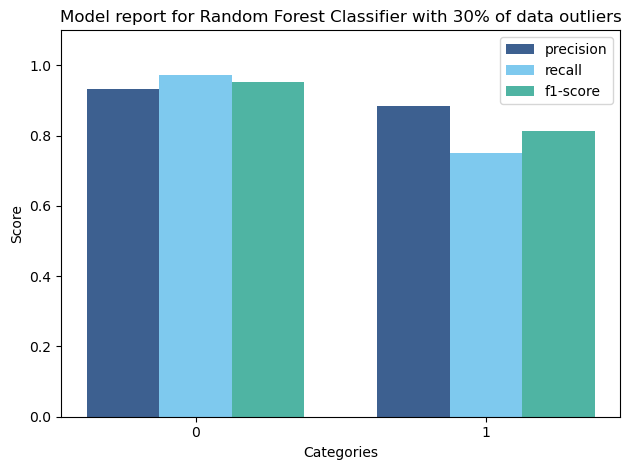

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10533
           1       0.77      0.71      0.74      2967

    accuracy                           0.89     13500
   macro avg       0.84      0.83      0.83     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8250501553353863
Feature importance ranking:
previous_loan_defaults_on_file    0.288938
loan_percent_income               0.170767
loan_int_rate                     0.104724
person_income                     0.089767
person_home_ownership             0.079592
loan_amnt                         0.061452
credit_score                      0.052971
person_emp_exp                    0.035196
person_age                        0.033710
cb_person_cred_hist_length        0.033441
loan_intent                       0.029407
person_education                  0.013804
person_gender                     0.006231
dtype: float64


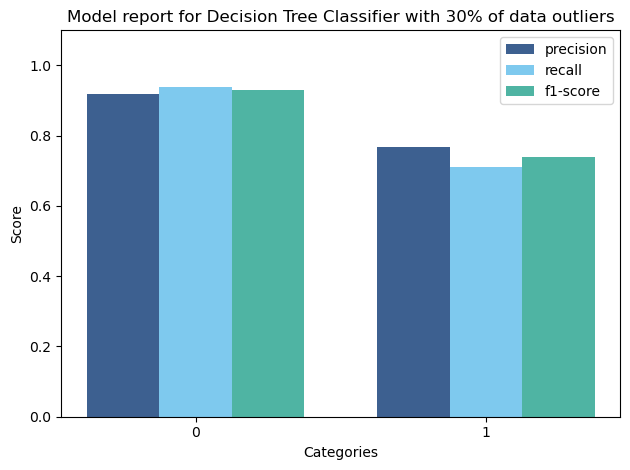

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

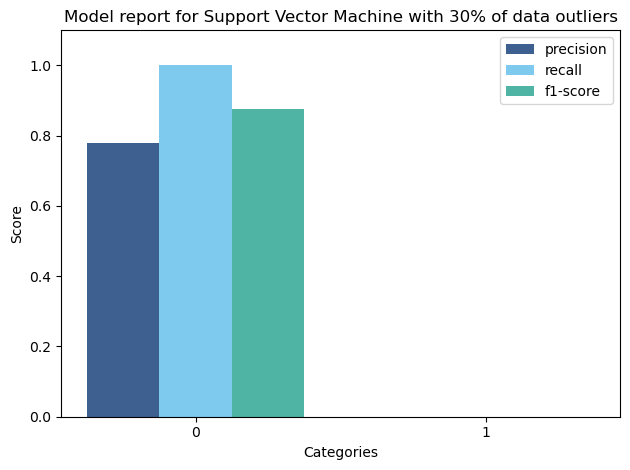

Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.87      0.75      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8571115556990371
Feature importance ranking:
previous_loan_defaults_on_file    0.366990
loan_percent_income               0.140478
loan_int_rate                     0.093146
person_home_ownership             0.078785
person_income                     0.073930
loan_amnt                         0.048100
credit_score                      0.044209
person_emp_exp                    0.036186
person_age                        0.035301
cb_person_cred_hist_length        0.033865
loan_intent                       0.029743
person_education                  0.013058
person_gender           

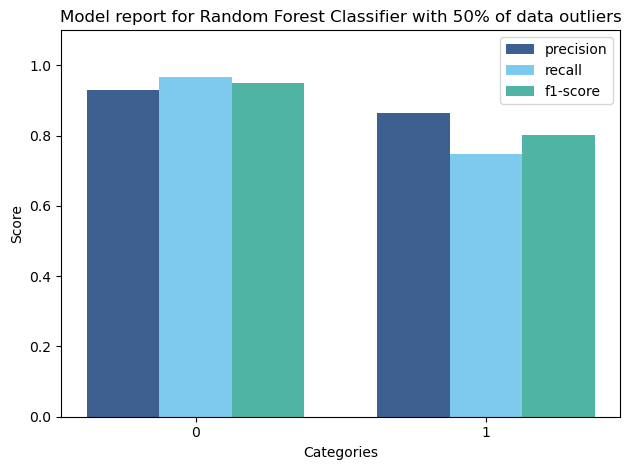

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10533
           1       0.76      0.74      0.75      2967

    accuracy                           0.89     13500
   macro avg       0.84      0.83      0.84     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8346036439762672
Feature importance ranking:
previous_loan_defaults_on_file    0.288982
loan_percent_income               0.191291
loan_int_rate                     0.094213
person_home_ownership             0.078189
person_income                     0.069964
loan_amnt                         0.052249
credit_score                      0.047906
person_age                        0.042224
person_emp_exp                    0.041991
cb_person_cred_hist_length        0.038080
loan_intent                       0.033283
person_education                  0.014534
person_gender                     0.007094
dtype: float64


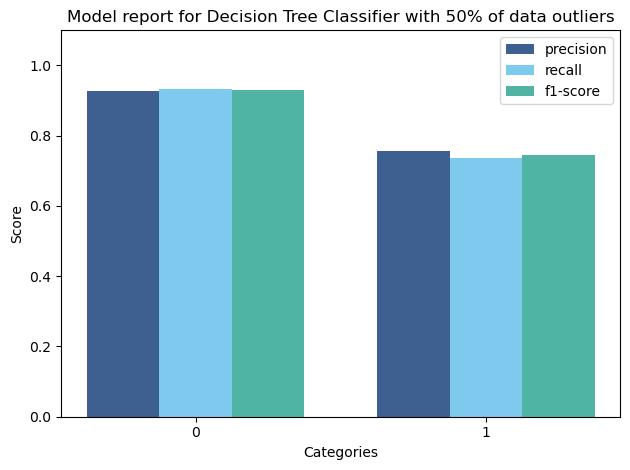

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

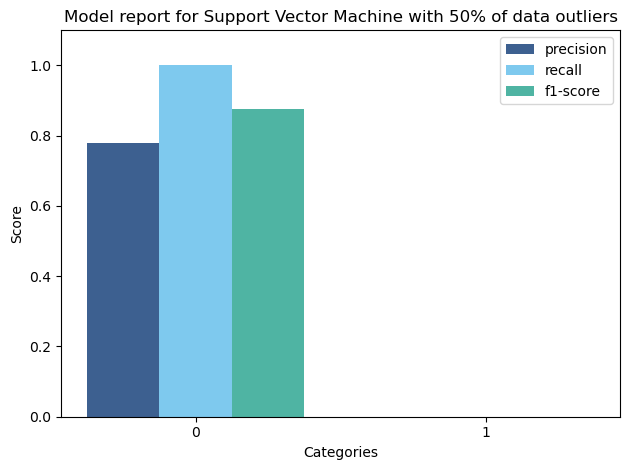

Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10533
           1       0.85      0.69      0.76      2967

    accuracy                           0.91     13500
   macro avg       0.88      0.83      0.85     13500
weighted avg       0.90      0.91      0.90     13500

Balanced accuracy:
0.8297993968976313
Feature importance ranking:
previous_loan_defaults_on_file    0.424407
loan_percent_income               0.122479
person_home_ownership             0.091981
loan_int_rate                     0.059469
person_income                     0.050725
credit_score                      0.043287
loan_amnt                         0.041736
person_emp_exp                    0.039878
cb_person_cred_hist_length        0.038897
person_age                        0.038534
loan_intent                       0.030126
person_education                  0.012550
person_gender           

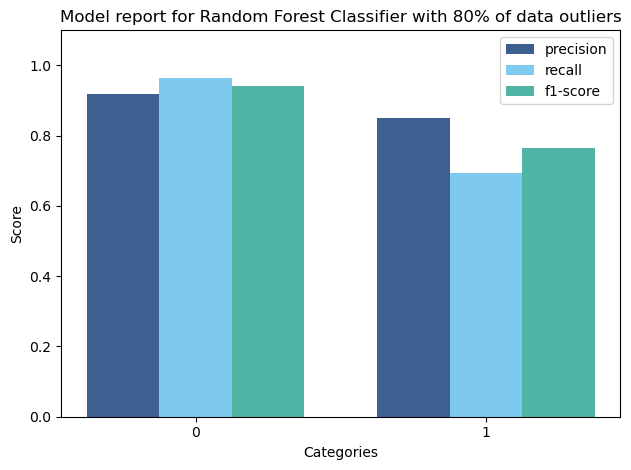

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     10533
           1       0.76      0.57      0.65      2967

    accuracy                           0.87     13500
   macro avg       0.82      0.76      0.78     13500
weighted avg       0.86      0.87      0.86     13500

Balanced accuracy:
0.7576395510589906
Feature importance ranking:
previous_loan_defaults_on_file    0.401455
loan_percent_income               0.151734
person_home_ownership             0.098988
loan_int_rate                     0.070848
person_income                     0.049879
credit_score                      0.037466
cb_person_cred_hist_length        0.036924
loan_amnt                         0.036111
person_age                        0.034981
person_emp_exp                    0.034622
loan_intent                       0.027839
person_education                  0.014537
person_gender                     0.004617
dtype: float64


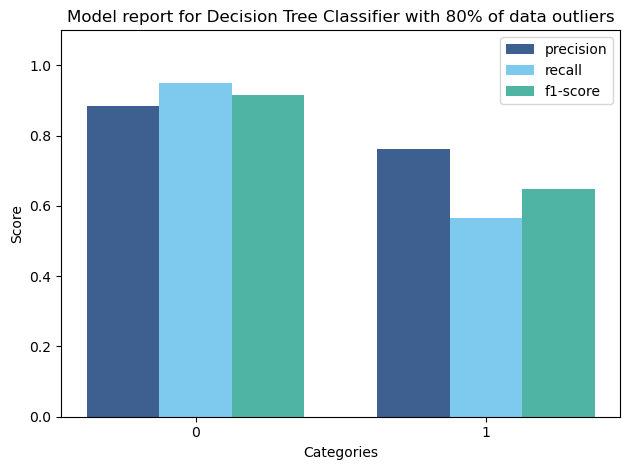

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

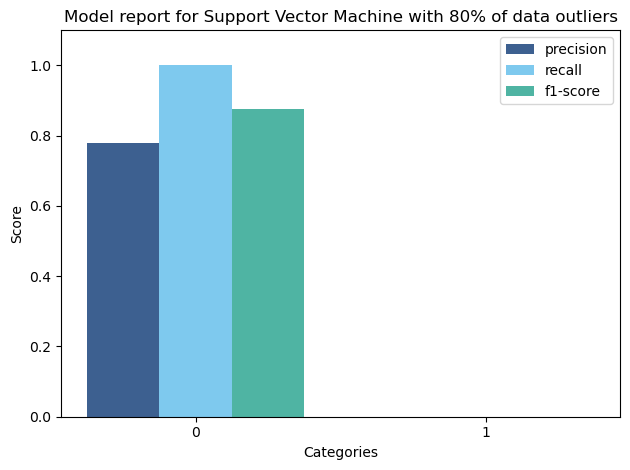

In [532]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(introduce_outliers,
                                   dirty_type = "outliers",
                                   file_suffix = "outliers")

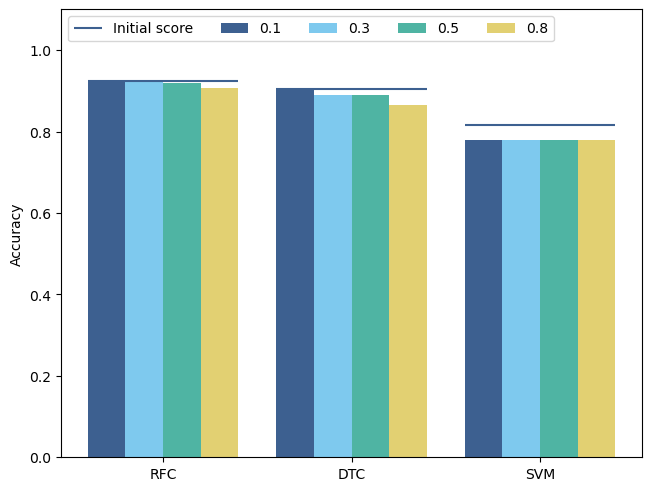

In [533]:
plot_model_accuracies(accuracies,
                      # title = "outliers",
                      filePrefix = "report_outliers")

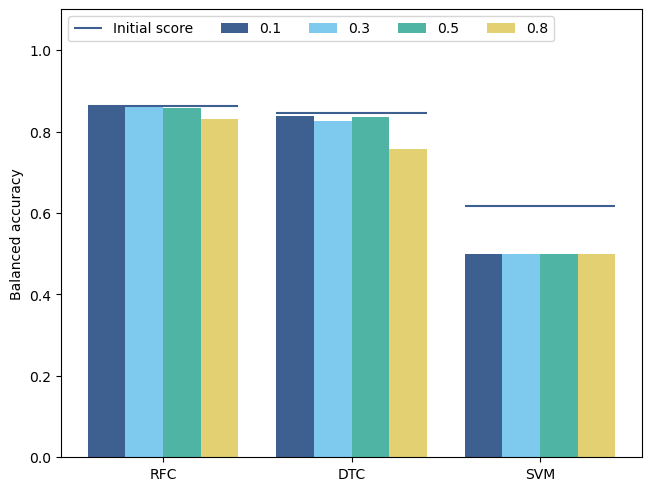

In [534]:
plot_model_accuracies(balanced_accuracies,
                      # title = "outliers",
                      filePrefix = "report_outliers_balanced",
                      balanced=True)

### Based on feature importance

In [535]:
def make_outlier(df, feature):
    """
    Numerical only ofc!
    """
    if rand.choice(2) == 0:
        res = df[feature].median() + 3 * df[feature].std() + rand.random() * 30 * df[feature].std()
    else:
        res = df[feature].median() - 3 * df[feature].std() - rand.random() * 30 * df[feature].std()
        
    return res

#### Visualizing distribution

In [536]:
X_out_flex = modify_entries_proportional_to_importance(X_train,
                                                       0.001,
                                                       feature_importance_rfc,
                                                       make_outlier,
                                                       numerical_only=True
                                                      )
X_out_flex

person_age person_gender person_education  person_income  \
21652        28.0             0                0        51613.0   
31615        42.0             0                0       137767.0   
34712        35.0             0                1        52574.0   
5455         21.0             0                4        55083.0   
36900        27.0             0                0       112215.0   
...           ...           ...              ...            ...   
30403        40.0             1                2        65596.0   
21243        28.0             0                0        36633.0   
42613        29.0             0                1        39466.0   
43567        27.0             1                3        53580.0   
2732         23.0             1                0        41843.0   

       person_emp_exp person_home_ownership  loan_amnt loan_intent  \
21652               5                     3     6000.0           5   
31615              17                     0    19200.0           4   
34712              13                     3     6150.0           3   
5455                0                     0     5000.0           1   
36900               3                     0     6000.0           4   
...               ...                   ...        ...         ...   
30403              13                     0     5000.0           4   
21243               5                     3     5200.0           4   
42613               6                     3     6525.0           1   
43567               4                     3    13650.0           0   
2732                0                     2    10950.0           5   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
21652          11.78              0.12000                        10.0   
31615          11.36              0.14000                        15.0   
34712           9.07             -0.99434                        12.0   
5455            7.14              0.09000                         4.0   
36900          11.00              0.05000                         4.0   
...              ...                  ...                         ...   
30403           5.42              0.08000                        13.0   
21243           5.42              0.14000                         7.0   
42613          16.07              0.17000                         9.0   
43567          10.65              0.25000                         7.0   
2732            7.29              0.26000                         2.0   

       credit_score previous_loan_defaults_on_file  
21652           614                              0  
31615           669                              1  
34712           688                              0  
5455            694                              0  
36900           674                              0  
...             ...                            ...  
30403           655                              0  
21243           583                              1  
42613           672                              0  
43567           548                              0  
2732            644                              1  

[31500 rows x 13 columns]

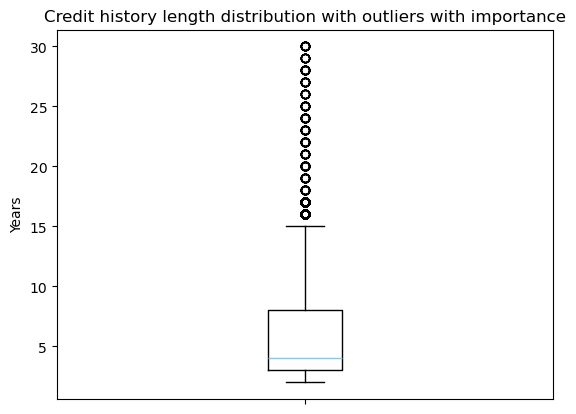

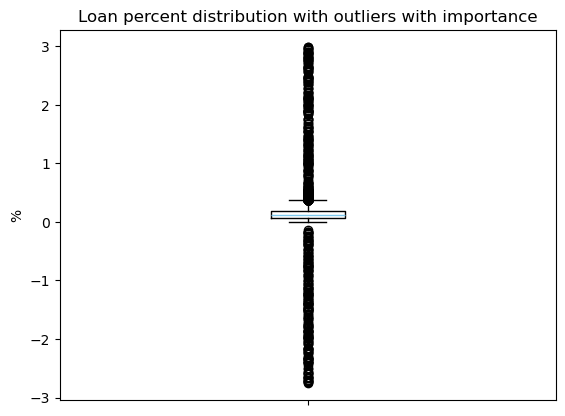

In [537]:
plt.boxplot(X_out_flex['cb_person_cred_hist_length'], tick_labels = [""])
plt.xticks()
plt.title("Credit history length distribution with outliers with importance")
plt.ylabel("Years")
# plt.savefig("images/cb_person_cred_hist_length_0.1_outliers_importance.svg")
plt.show()

plt.boxplot(X_out_flex['loan_percent_income'], tick_labels = [""])
plt.xticks()
plt.title("Loan percent distribution with outliers with importance")
plt.ylabel("%")
# plt.savefig("images/loan_percent_income_0.1_outliers_importance.svg")
plt.show()

#### Running models

Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10533
           1       0.87      0.77      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.87      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8668643793395441
Feature importance ranking:
previous_loan_defaults_on_file    0.357211
loan_int_rate                     0.120408
person_income                     0.111508
loan_percent_income               0.101207
person_home_ownership             0.077198
loan_amnt                         0.066990
credit_score                      0.050780
loan_intent                       0.030903
person_age                        0.023900
person_emp_exp                    0.022321
cb_person_cred_hist_length        0.019262
person_education                  0.012582
person_gender           

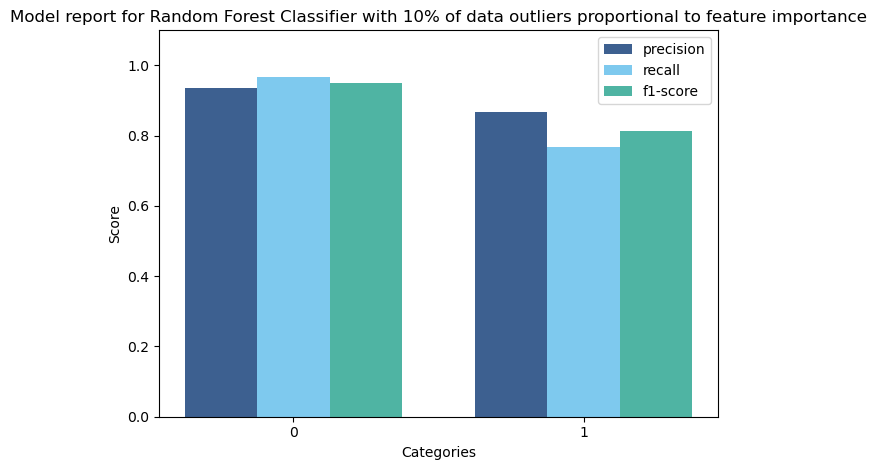

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10533
           1       0.77      0.72      0.74      2967

    accuracy                           0.89     13500
   macro avg       0.85      0.83      0.84     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.829616813141653
Feature importance ranking:
previous_loan_defaults_on_file    0.306819
loan_int_rate                     0.136973
person_income                     0.111541
loan_percent_income               0.087211
loan_amnt                         0.081943
person_home_ownership             0.079263
credit_score                      0.055437
person_age                        0.033354
loan_intent                       0.030827
cb_person_cred_hist_length        0.027423
person_emp_exp                    0.025812
person_education                  0.015646
person_gender                     0.007751
dtype: float64


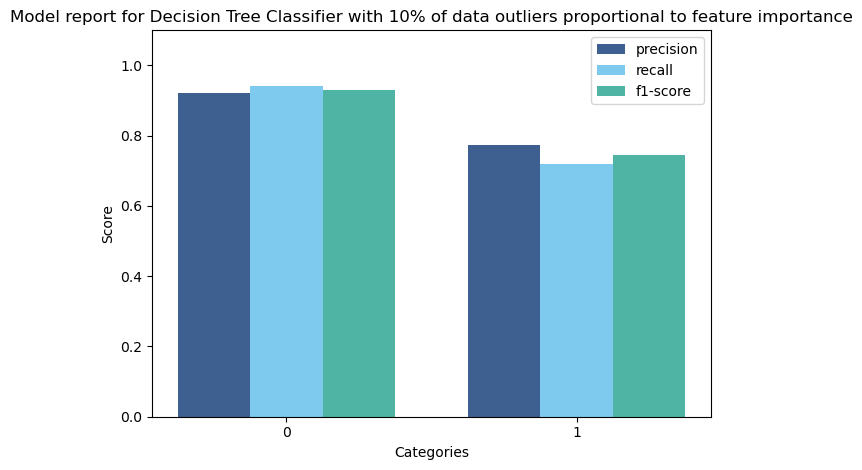

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

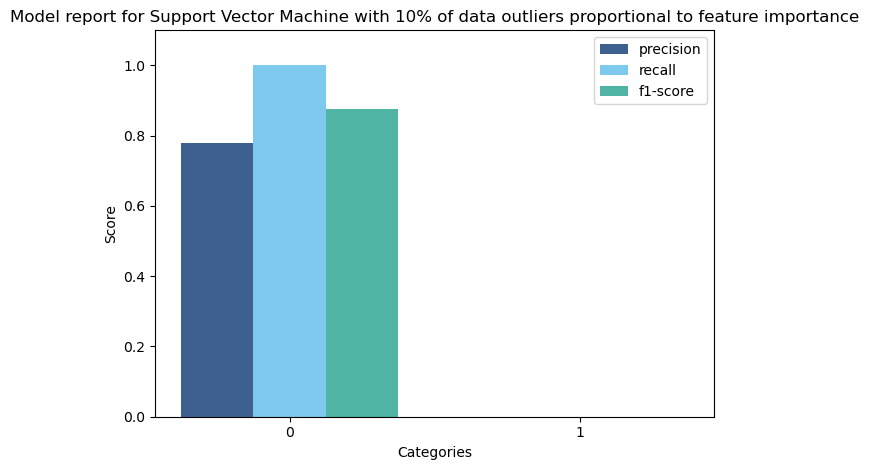

Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     10533
           1       0.86      0.72      0.79      2967

    accuracy                           0.91     13500
   macro avg       0.89      0.84      0.87     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8444464155554448
Feature importance ranking:
previous_loan_defaults_on_file    0.401473
person_income                     0.093044
person_home_ownership             0.084776
loan_amnt                         0.071139
loan_percent_income               0.070167
loan_int_rate                     0.067559
credit_score                      0.062911
loan_intent                       0.034122
person_age                        0.032749
person_emp_exp                    0.030747
cb_person_cred_hist_length        0.027603
person_education                  0.015982
person_gender           

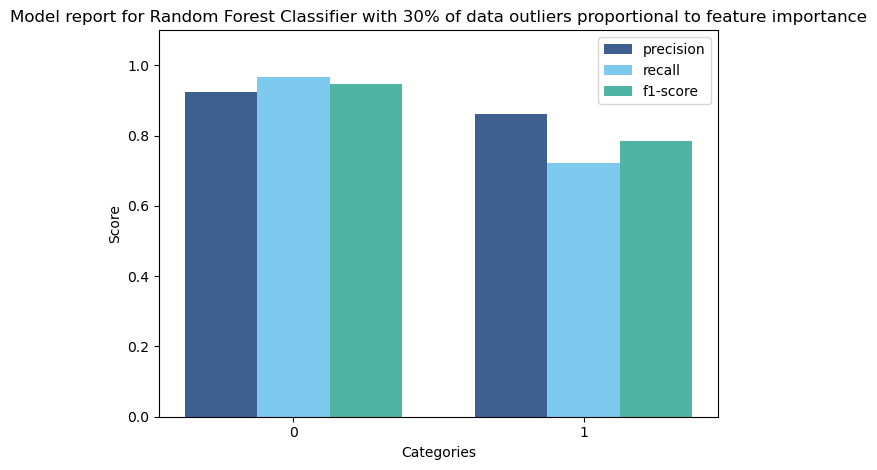

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92     10533
           1       0.75      0.66      0.70      2967

    accuracy                           0.88     13500
   macro avg       0.83      0.80      0.81     13500
weighted avg       0.87      0.88      0.87     13500

Balanced accuracy:
0.8004390745749048
Feature importance ranking:
previous_loan_defaults_on_file    0.374486
person_home_ownership             0.085097
loan_percent_income               0.082446
loan_int_rate                     0.077977
person_income                     0.072880
loan_amnt                         0.072139
credit_score                      0.063945
person_emp_exp                    0.042354
person_age                        0.039354
loan_intent                       0.032726
cb_person_cred_hist_length        0.032194
person_education                  0.017380
person_gender                     0.007022
dtype: float64


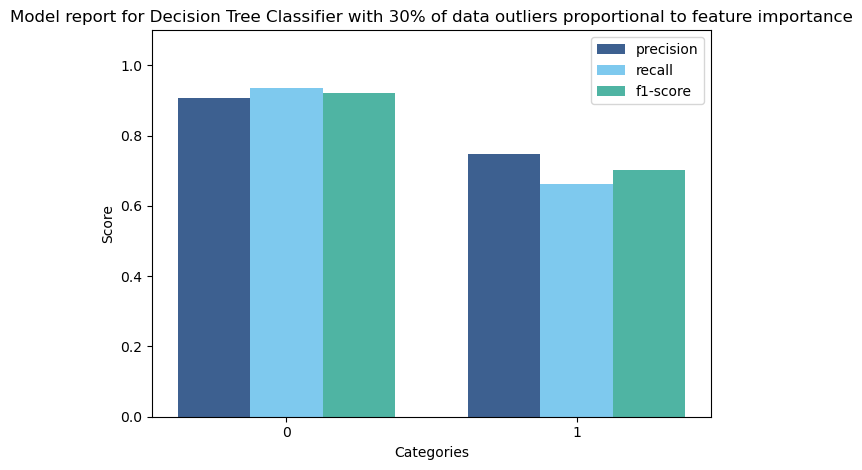

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

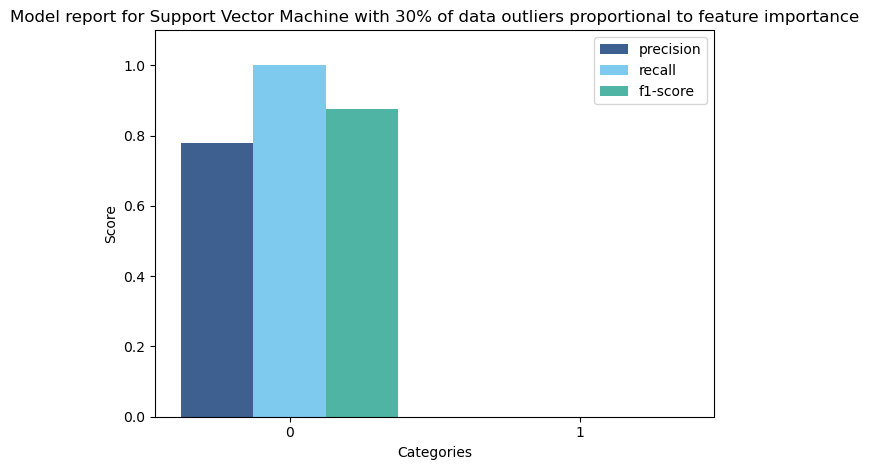

Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10533
           1       0.82      0.69      0.75      2967

    accuracy                           0.90     13500
   macro avg       0.87      0.82      0.84     13500
weighted avg       0.89      0.90      0.89     13500

Balanced accuracy:
0.8225412126191678
Feature importance ranking:
previous_loan_defaults_on_file    0.441228
person_home_ownership             0.096313
loan_amnt                         0.066505
credit_score                      0.062912
person_income                     0.062446
loan_int_rate                     0.056973
loan_percent_income               0.056922
person_age                        0.035621
loan_intent                       0.034669
person_emp_exp                    0.032884
cb_person_cred_hist_length        0.030401
person_education                  0.015512
person_gender           

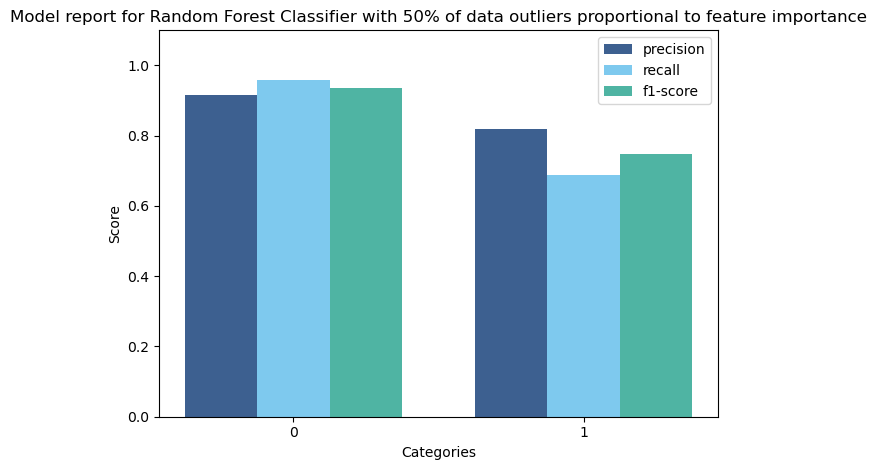

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     10533
           1       0.72      0.53      0.61      2967

    accuracy                           0.85     13500
   macro avg       0.80      0.74      0.76     13500
weighted avg       0.84      0.85      0.84     13500

Balanced accuracy:
0.7371940582138835
Feature importance ranking:
previous_loan_defaults_on_file    0.396177
person_home_ownership             0.094947
loan_amnt                         0.083700
person_income                     0.077567
credit_score                      0.060544
loan_int_rate                     0.057570
loan_percent_income               0.053485
cb_person_cred_hist_length        0.040183
person_age                        0.039920
person_emp_exp                    0.038926
loan_intent                       0.035097
person_education                  0.014346
person_gender                     0.007539
dtype: float64


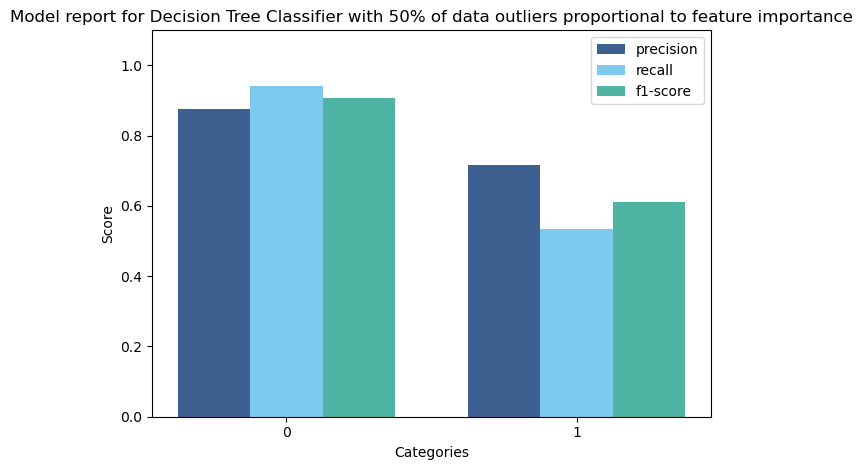

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

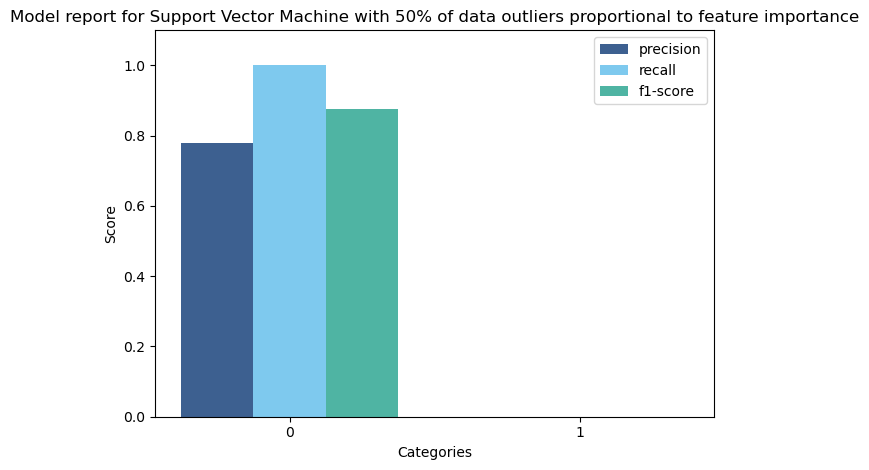

Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     10533
           1       0.70      0.64      0.67      2967

    accuracy                           0.86     13500
   macro avg       0.80      0.78      0.79     13500
weighted avg       0.86      0.86      0.86     13500

Balanced accuracy:
0.7814011181767121
Feature importance ranking:
previous_loan_defaults_on_file    0.463584
person_home_ownership             0.100562
loan_amnt                         0.061449
credit_score                      0.056979
person_income                     0.051496
loan_int_rate                     0.050913
loan_percent_income               0.049527
person_age                        0.038707
person_emp_exp                    0.036602
loan_intent                       0.035832
cb_person_cred_hist_length        0.033004
person_education                  0.014742
person_gender           

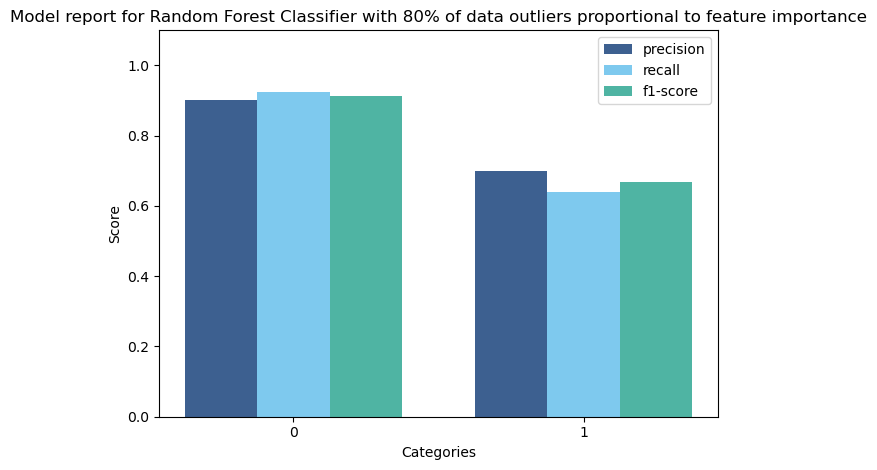

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     10533
           1       0.63      0.59      0.61      2967

    accuracy                           0.83     13500
   macro avg       0.76      0.75      0.75     13500
weighted avg       0.83      0.83      0.83     13500

Balanced accuracy:
0.7461021679949107
Feature importance ranking:
previous_loan_defaults_on_file    0.473464
person_home_ownership             0.101355
person_income                     0.061352
loan_amnt                         0.058867
credit_score                      0.051155
loan_int_rate                     0.046988
loan_percent_income               0.044189
person_age                        0.039025
person_emp_exp                    0.037068
loan_intent                       0.034233
cb_person_cred_hist_length        0.032214
person_education                  0.014128
person_gender                     0.005963
dtype: float64


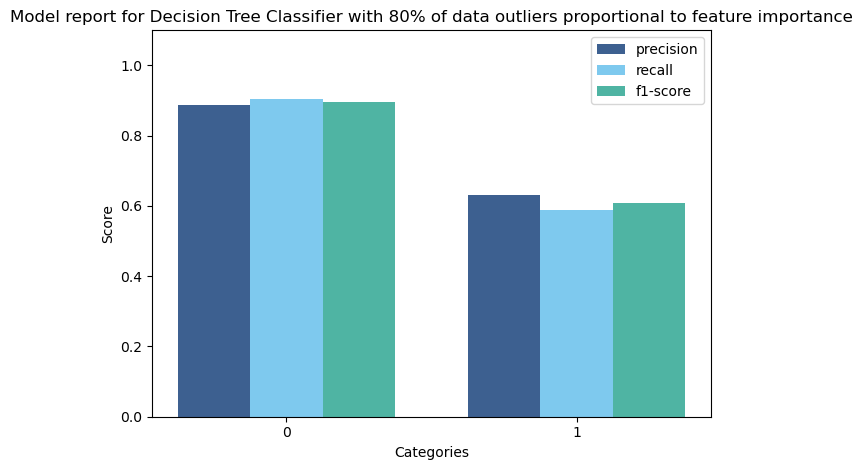

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

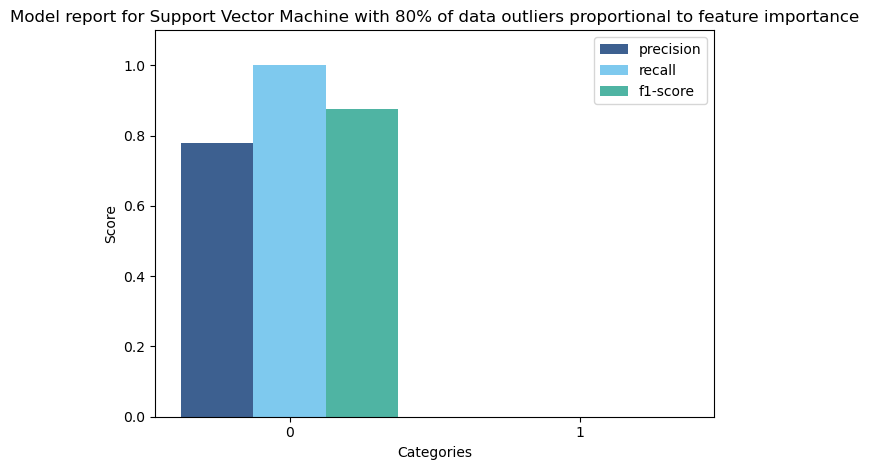

In [538]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(
    modify_entries_proportional_to_importance,
    feature_importance = feature_importance_rfc,
    dirty_type = "outliers proportional to feature importance",
    file_suffix = "outliers_importance",
    aux_function = make_outlier
)

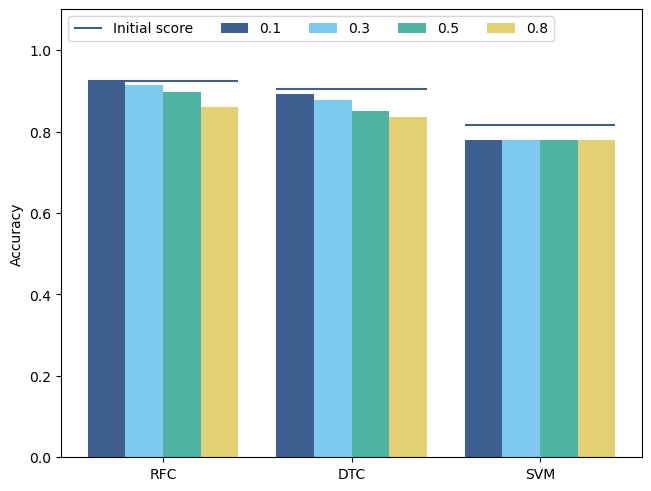

In [539]:
plot_model_accuracies(accuracies,
                      # title = "outliers",
                      filePrefix = "report_outliers_importance")

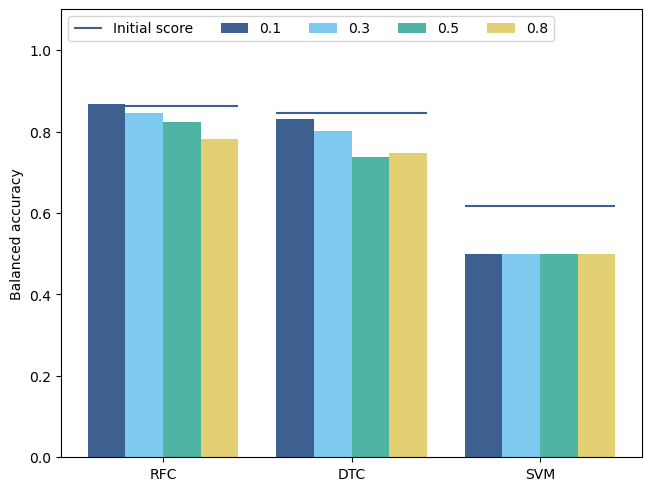

In [540]:
plot_model_accuracies(balanced_accuracies,
                      # title = "outliers",
                      filePrefix = "report_outliers_importance_balanced",
                      balanced=True)

### Based on feature importance - reversed

#### Running models

Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.89      0.75      0.82      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8637668871975093
Feature importance ranking:
previous_loan_defaults_on_file    0.327816
loan_percent_income               0.154700
loan_int_rate                     0.142487
person_income                     0.101944
person_home_ownership             0.075883
loan_amnt                         0.049259
credit_score                      0.038377
loan_intent                       0.029584
person_age                        0.022739
person_emp_exp                    0.021518
cb_person_cred_hist_length        0.021054
person_education                  0.009768
person_gender           

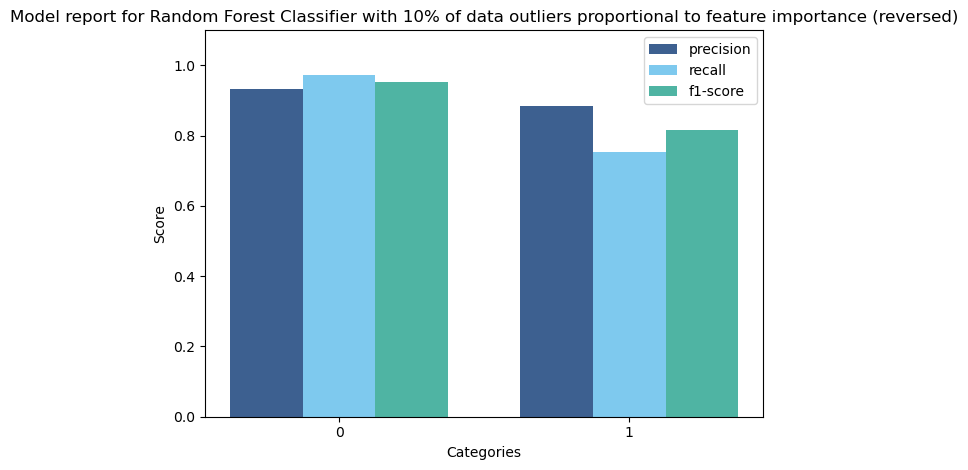

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10533
           1       0.80      0.72      0.76      2967

    accuracy                           0.90     13500
   macro avg       0.86      0.83      0.85     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.833158045247941
Feature importance ranking:
previous_loan_defaults_on_file    0.302118
loan_int_rate                     0.150931
person_income                     0.120305
loan_percent_income               0.111407
person_home_ownership             0.079246
loan_amnt                         0.055737
credit_score                      0.040287
loan_intent                       0.032989
cb_person_cred_hist_length        0.031762
person_age                        0.029988
person_emp_exp                    0.025685
person_education                  0.012689
person_gender                     0.006856
dtype: float64


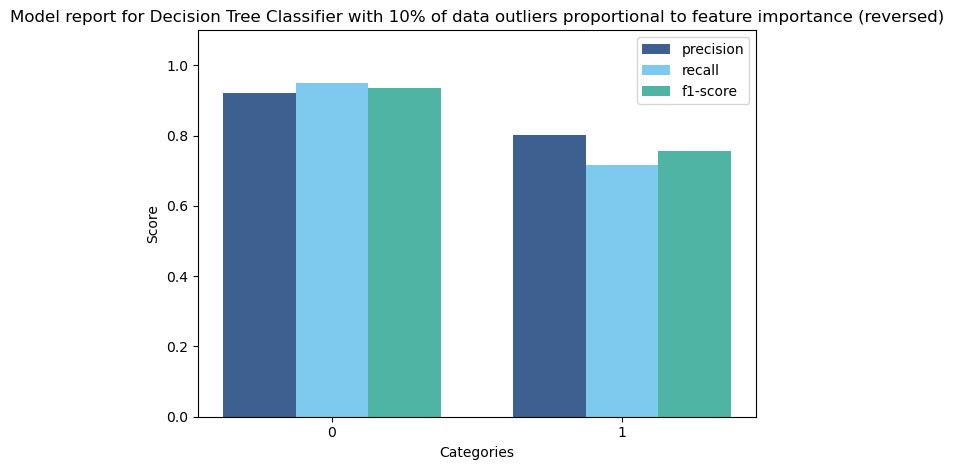

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

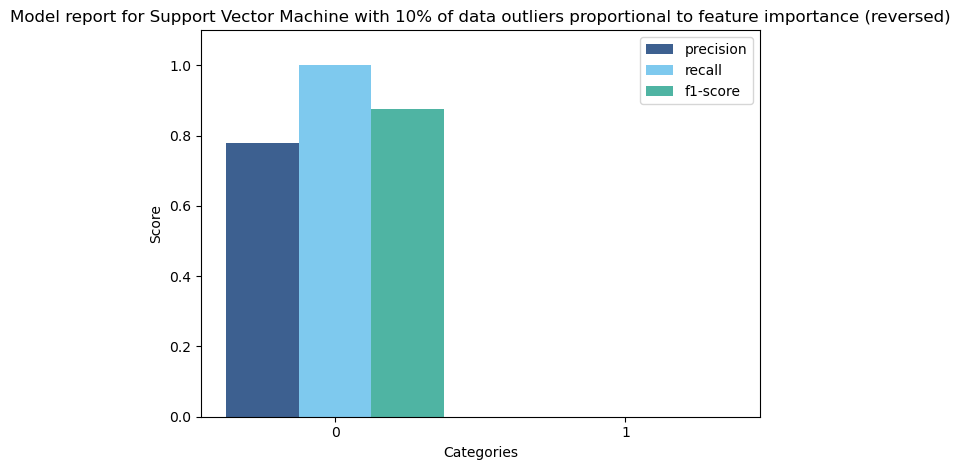

Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.87      0.75      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.860550792410621
Feature importance ranking:
previous_loan_defaults_on_file    0.359493
loan_percent_income               0.130761
loan_int_rate                     0.107056
person_income                     0.081377
person_home_ownership             0.078566
loan_amnt                         0.049565
credit_score                      0.045541
person_emp_exp                    0.033349
person_age                        0.033131
cb_person_cred_hist_length        0.032343
loan_intent                       0.030487
person_education                  0.012463
person_gender            

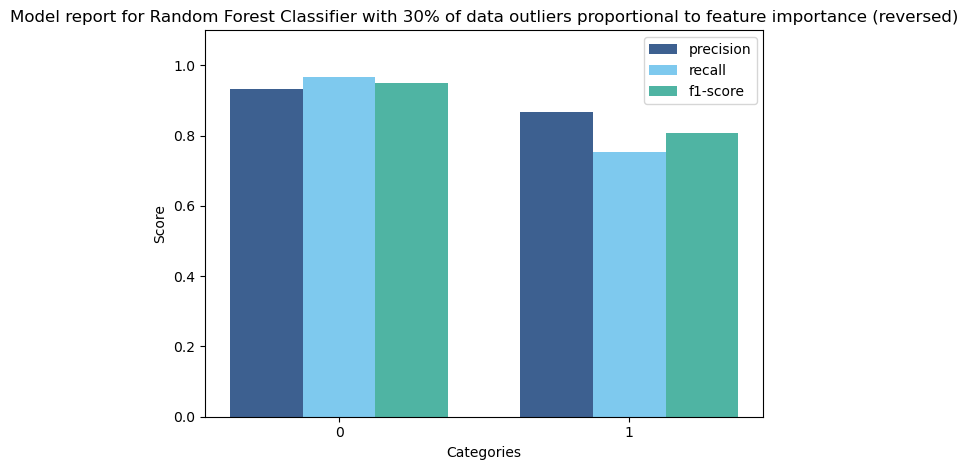

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10533
           1       0.77      0.71      0.74      2967

    accuracy                           0.89     13500
   macro avg       0.85      0.83      0.84     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8270628964560993
Feature importance ranking:
previous_loan_defaults_on_file    0.359123
loan_int_rate                     0.100787
loan_percent_income               0.093318
person_income                     0.087852
person_home_ownership             0.078579
loan_amnt                         0.059166
credit_score                      0.050417
person_emp_exp                    0.040411
person_age                        0.039472
cb_person_cred_hist_length        0.039046
loan_intent                       0.032186
person_education                  0.012833
person_gender                     0.006812
dtype: float64


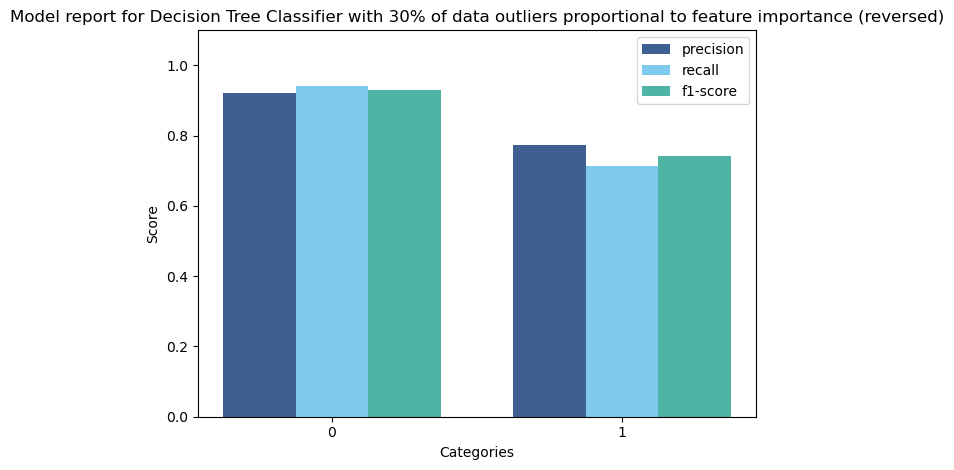

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

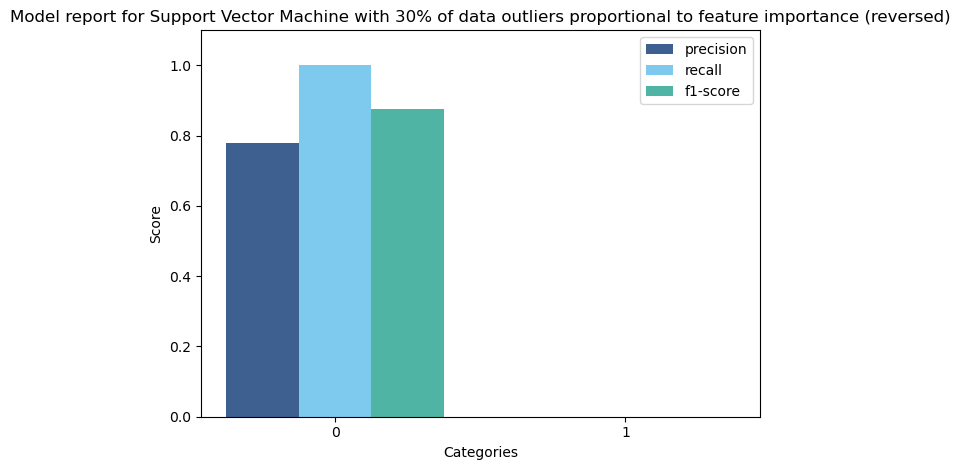

Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.86      0.74      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.90      0.85      0.87     13500
weighted avg       0.91      0.92      0.91     13500

Balanced accuracy:
0.8536509599518562
Feature importance ranking:
previous_loan_defaults_on_file    0.382261
loan_percent_income               0.108600
loan_int_rate                     0.093213
person_home_ownership             0.080097
person_income                     0.071690
loan_amnt                         0.048541
credit_score                      0.046711
person_age                        0.039731
cb_person_cred_hist_length        0.039045
person_emp_exp                    0.038864
loan_intent                       0.031132
person_education                  0.013851
person_gender           

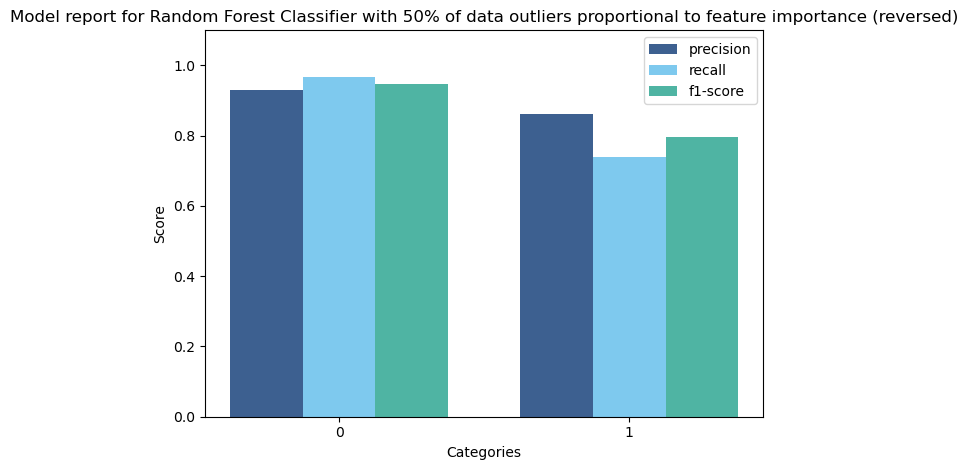

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     10533
           1       0.75      0.69      0.72      2967

    accuracy                           0.88     13500
   macro avg       0.83      0.81      0.82     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.8121168512999302
Feature importance ranking:
previous_loan_defaults_on_file    0.384124
loan_int_rate                     0.097419
person_home_ownership             0.089298
loan_percent_income               0.085561
person_income                     0.071221
loan_amnt                         0.049846
person_age                        0.048319
person_emp_exp                    0.042212
credit_score                      0.040731
cb_person_cred_hist_length        0.036817
loan_intent                       0.033366
person_education                  0.015553
person_gender                     0.005534
dtype: float64


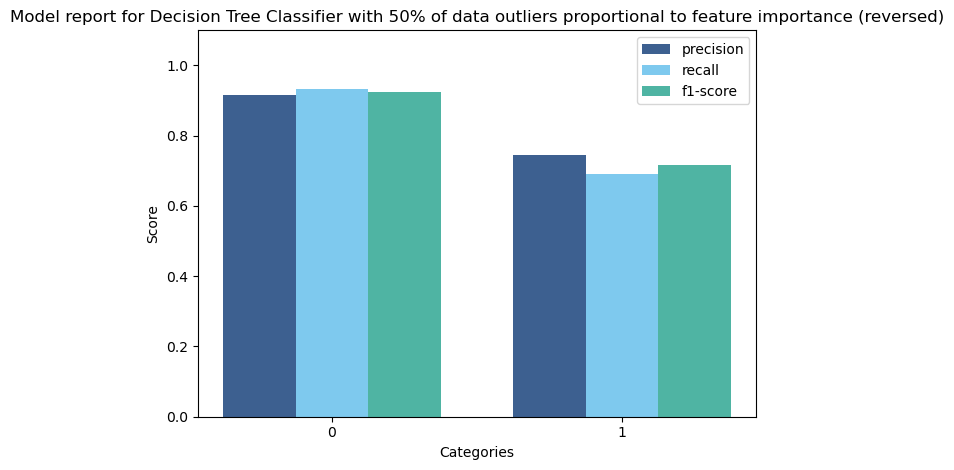

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

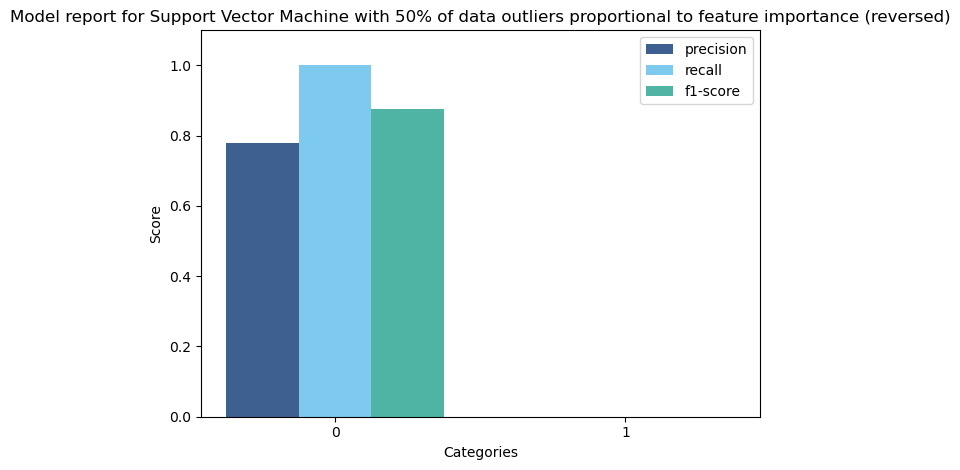

Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     10533
           1       0.85      0.73      0.79      2967

    accuracy                           0.91     13500
   macro avg       0.89      0.85      0.87     13500
weighted avg       0.91      0.91      0.91     13500

Balanced accuracy:
0.8477978642308343
Feature importance ranking:
previous_loan_defaults_on_file    0.412038
person_home_ownership             0.087786
loan_percent_income               0.086572
loan_int_rate                     0.074820
person_income                     0.060490
loan_amnt                         0.048312
credit_score                      0.046088
person_age                        0.044662
cb_person_cred_hist_length        0.043827
person_emp_exp                    0.043342
loan_intent                       0.031422
person_education                  0.014072
person_gender           

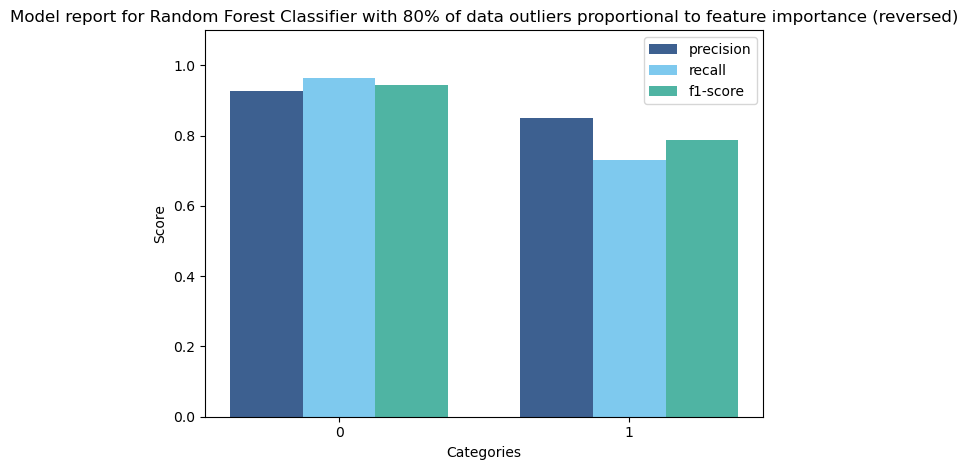

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     10533
           1       0.81      0.65      0.72      2967

    accuracy                           0.89     13500
   macro avg       0.86      0.80      0.83     13500
weighted avg       0.89      0.89      0.88     13500

Balanced accuracy:
0.804155882753582
Feature importance ranking:
previous_loan_defaults_on_file    0.393503
loan_percent_income               0.122048
person_home_ownership             0.096349
loan_int_rate                     0.077836
person_income                     0.050779
loan_amnt                         0.044236
person_age                        0.043098
person_emp_exp                    0.039545
loan_intent                       0.038750
cb_person_cred_hist_length        0.037850
credit_score                      0.037276
person_education                  0.013225
person_gender                     0.005503
dtype: float64


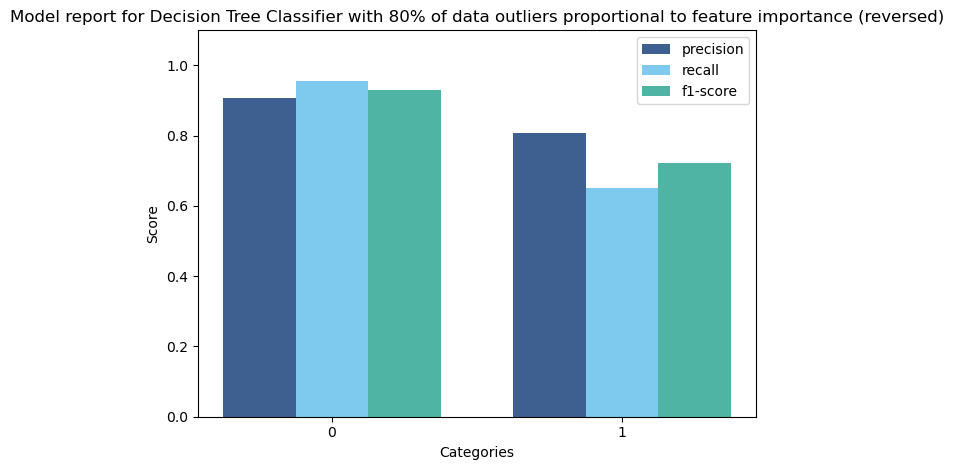

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

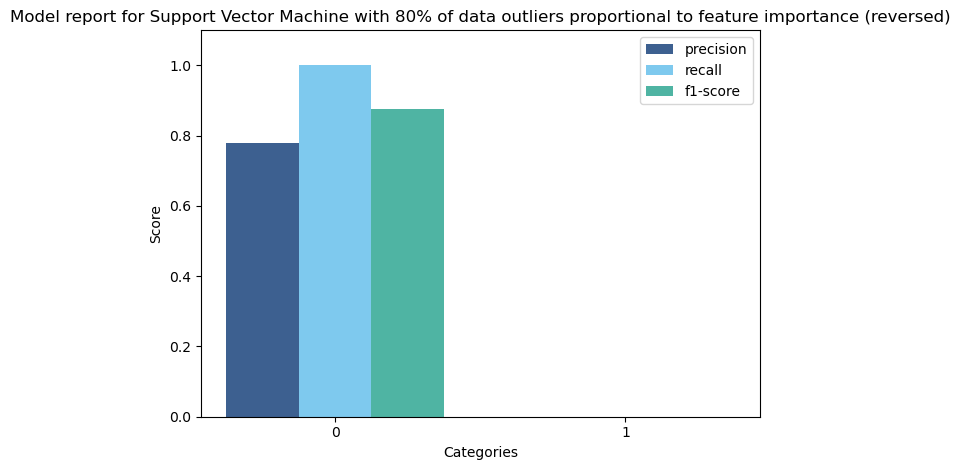

In [541]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(
    modify_entries_proportional_to_importance,
    feature_importance = inverted_feature_importances,
    dirty_type = "outliers proportional to feature importance (reversed)",
    file_suffix = "outliers_importance_reversed",
    aux_function = make_outlier
)

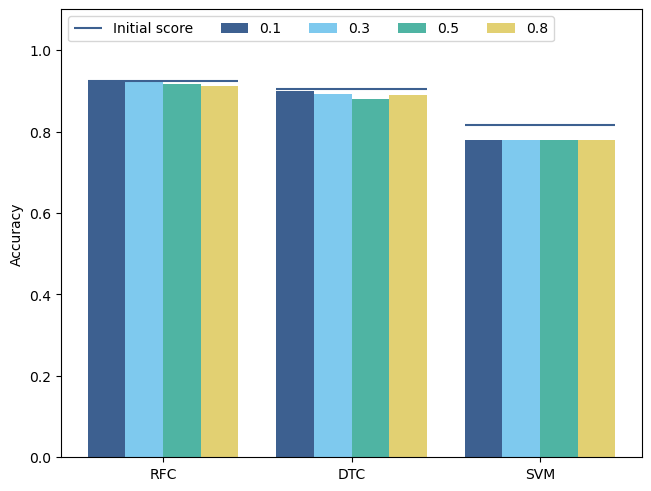

In [542]:
plot_model_accuracies(accuracies,
                      # title = "outliers",
                      filePrefix = "report_outliers_importance_reversed")

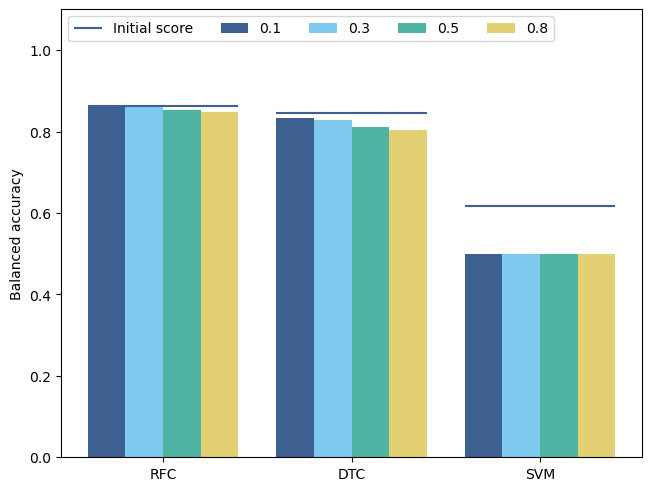

In [543]:
plot_model_accuracies(balanced_accuracies,
                      # title = "outliers",
                      filePrefix = "report_outliers_importance_reversed_balanced",
                      balanced=True)

## Noisy data

In [544]:
def introduce_noisy_data(df, portion):
    """
    Introduces noisy values into a DataFrame.

    Parameters:
    - df: pandas.DataFrame
        The input DataFrame.
    - portion: float
        A value between 0 and 1 representing the fraction of NUMERICAL cells to be modified as noisy.

    Returns:
    - pandas.DataFrame
        A DataFrame with a portion of NUMERICAL cells replaced by noisy values.
    """     
    # Isolate numerical columns
    numericals = df.drop(columns=categoricals[0:5])
    num_outliers = int(numericals.size * portion)
    
    # Create a mask where each element has a probability `portion` of being True
    mask = np.random.rand(*numericals.shape) < portion
    
    tmp = numericals.copy()

    # This logic works, but it is kinda slow...
    for idx in tmp.index:
        for col in numericals.columns:

            if col in gtz_features:
                modifier = 0
                # Slower but more "realistic" output with a continuous check to regen low values...
                # HEAPS slow
                while modifier <= 0:
                    # Add or subtract, kinda meh
                    if rand.choice(2) == 0:
                        modifier = numericals[col].median() + rand.random() * 3 * numericals[col].std()
                    else:
                        modifier = numericals[col].median() - rand.random() * 3 * numericals[col].std()

            # # Don't introduce semantically wrong values e.g. less than 0 years old
            # if col in gtz_features and modifier <= 0:
            #     modifier = 0
            
            tmp.at[idx, col] = int(modifier - numericals.loc[idx, col])

    tmp = tmp * mask
    df_noisy = pd.concat([tmp + numericals, df[categoricals[0:5]]], axis=1)
    
    return df_noisy[df.columns]

### At random

#### Visualize modified distribution

In [545]:
X_noise = introduce_noisy_data(X_train, 0.5)

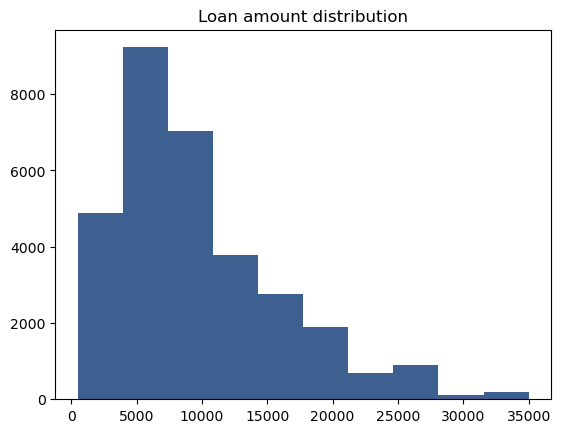

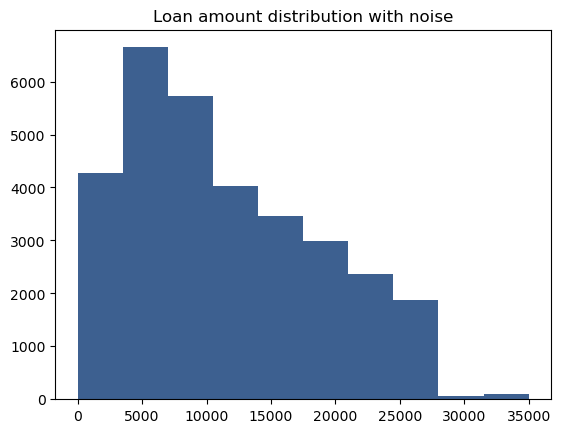

In [546]:
# X, y = get_XY(data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
plt.hist(X_train['loan_amnt'])
plt.title("Loan amount distribution")
# plt.savefig()
plt.show()

plt.hist(X_noise['loan_amnt'])
plt.title("Loan amount distribution with noise")
plt.savefig("images/loan_amount_distribution_50_noisy.svg")
plt.show()
# X_out

#### Running models

Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.89      0.75      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.861065809156585
Feature importance ranking:
previous_loan_defaults_on_file    0.304579
loan_percent_income               0.197540
loan_int_rate                     0.137766
person_income                     0.105140
person_home_ownership             0.077770
loan_amnt                         0.044315
credit_score                      0.039229
loan_intent                       0.030161
person_age                        0.018522
person_emp_exp                    0.016865
cb_person_cred_hist_length        0.014949
person_education                  0.008727
person_gender            

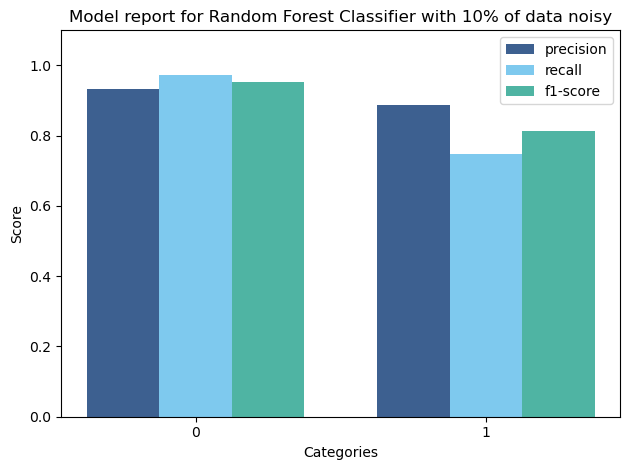

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10533
           1       0.81      0.71      0.76      2967

    accuracy                           0.90     13500
   macro avg       0.86      0.83      0.85     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8309743838446206
Feature importance ranking:
previous_loan_defaults_on_file    0.307910
loan_percent_income               0.154414
loan_int_rate                     0.147048
person_income                     0.129079
person_home_ownership             0.060027
loan_amnt                         0.049855
credit_score                      0.040559
loan_intent                       0.034701
cb_person_cred_hist_length        0.021104
person_age                        0.020826
person_emp_exp                    0.019844
person_education                  0.009687
person_gender                     0.004946
dtype: float64


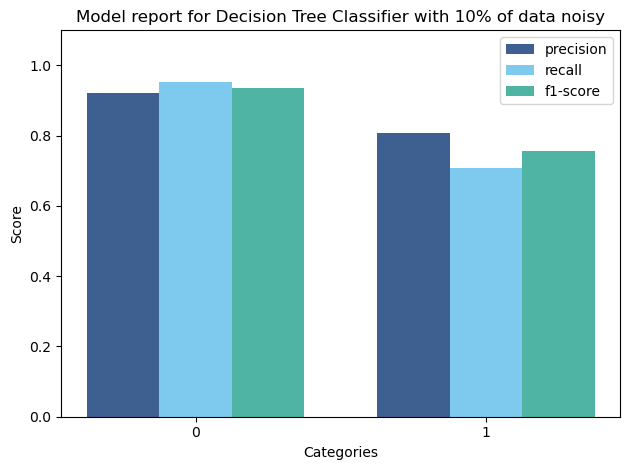

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.85      0.01      0.03      2967

    accuracy                           0.78     13500
   macro avg       0.82      0.51      0.45     13500
weighted avg       0.80      0.78      0.69     13500

Balanced accuracy:
0.506408526642205


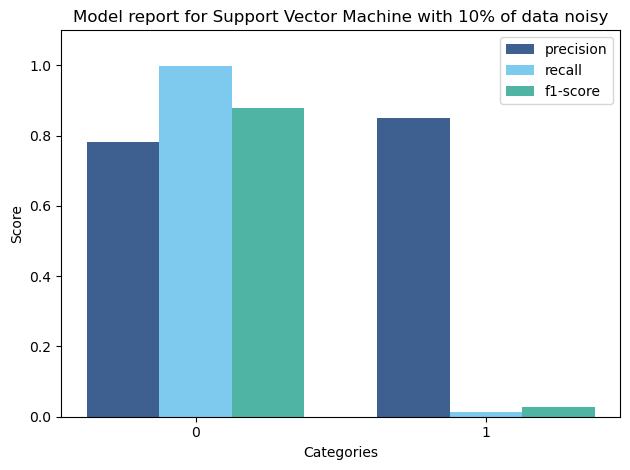

Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10533
           1       0.90      0.72      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.85      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8491364277920124
Feature importance ranking:
previous_loan_defaults_on_file    0.328983
loan_percent_income               0.217258
loan_int_rate                     0.099866
person_home_ownership             0.082192
person_income                     0.078303
loan_amnt                         0.043155
credit_score                      0.039263
loan_intent                       0.030177
person_age                        0.023635
person_emp_exp                    0.022419
cb_person_cred_hist_length        0.019195
person_education                  0.010685
person_gender           

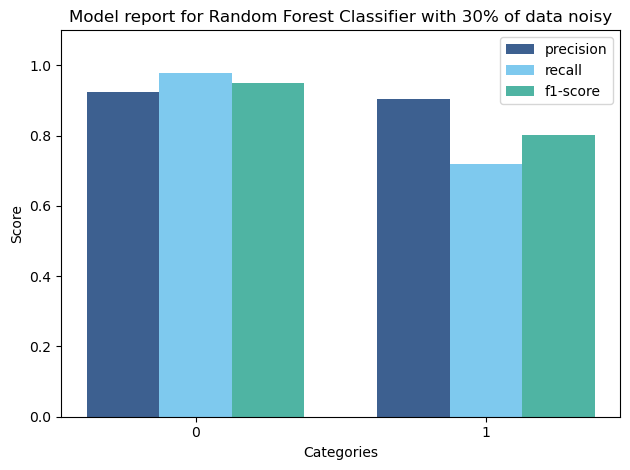

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     10533
           1       0.80      0.70      0.74      2967

    accuracy                           0.89     13500
   macro avg       0.86      0.82      0.84     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8228355833277416
Feature importance ranking:
previous_loan_defaults_on_file    0.373131
loan_percent_income               0.161659
person_home_ownership             0.090846
loan_int_rate                     0.088223
person_income                     0.076457
loan_amnt                         0.045301
credit_score                      0.041885
person_age                        0.028535
loan_intent                       0.028344
cb_person_cred_hist_length        0.026395
person_emp_exp                    0.021044
person_education                  0.013204
person_gender                     0.004976
dtype: float64


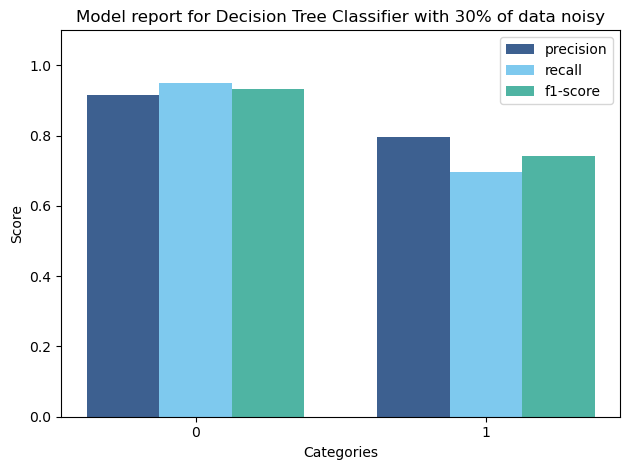

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.67      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.72      0.50      0.44     13500
weighted avg       0.76      0.78      0.68     13500

Balanced accuracy:
0.5002895709252936


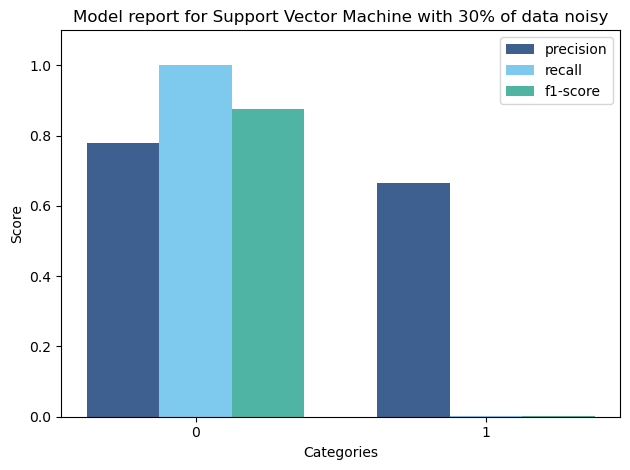

Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     10533
           1       0.90      0.70      0.78      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.84      0.87     13500
weighted avg       0.91      0.92      0.91     13500

Balanced accuracy:
0.8378075953114565
Feature importance ranking:
previous_loan_defaults_on_file    0.338213
loan_percent_income               0.232693
person_home_ownership             0.085759
loan_int_rate                     0.073731
person_income                     0.063668
loan_amnt                         0.042474
credit_score                      0.040195
loan_intent                       0.031239
person_age                        0.027484
person_emp_exp                    0.025392
cb_person_cred_hist_length        0.021768
person_education                  0.011787
person_gender           

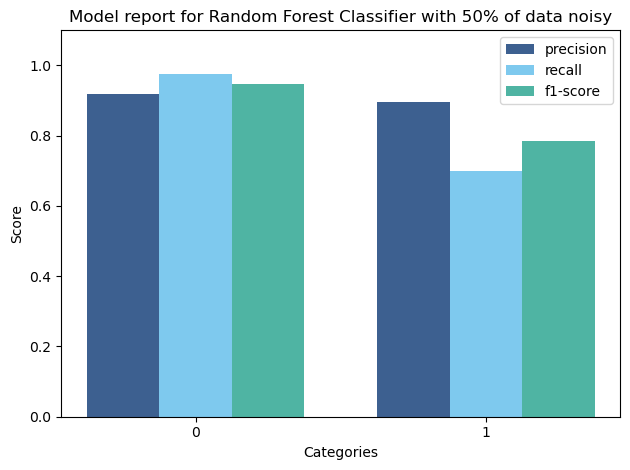

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     10533
           1       0.77      0.65      0.71      2967

    accuracy                           0.88     13500
   macro avg       0.84      0.80      0.82     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.7977545557862971
Feature importance ranking:
previous_loan_defaults_on_file    0.380253
loan_percent_income               0.202423
person_home_ownership             0.092608
loan_int_rate                     0.072003
person_income                     0.054066
credit_score                      0.043527
loan_amnt                         0.038694
person_age                        0.029850
loan_intent                       0.027014
cb_person_cred_hist_length        0.022121
person_emp_exp                    0.020165
person_education                  0.009905
person_gender                     0.007373
dtype: float64


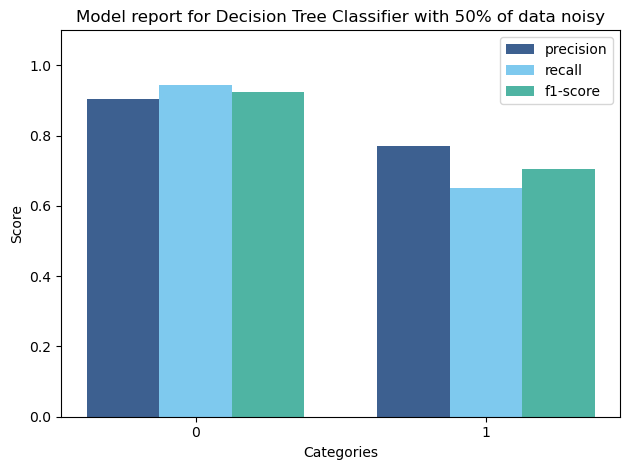

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.33      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.56      0.50      0.44     13500
weighted avg       0.68      0.78      0.68     13500

Balanced accuracy:
0.5000735806776853


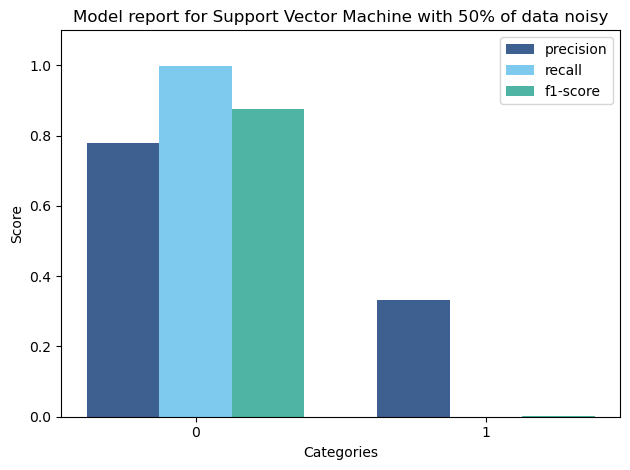

Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     10533
           1       0.86      0.60      0.70      2967

    accuracy                           0.89     13500
   macro avg       0.88      0.78      0.82     13500
weighted avg       0.89      0.89      0.88     13500

Balanced accuracy:
0.7843629204454161
Feature importance ranking:
previous_loan_defaults_on_file    0.353125
loan_percent_income               0.252578
person_home_ownership             0.090634
loan_int_rate                     0.046547
person_income                     0.043570
loan_amnt                         0.041671
credit_score                      0.039817
loan_intent                       0.031898
person_age                        0.030248
person_emp_exp                    0.027980
cb_person_cred_hist_length        0.023914
person_education                  0.012293
person_gender           

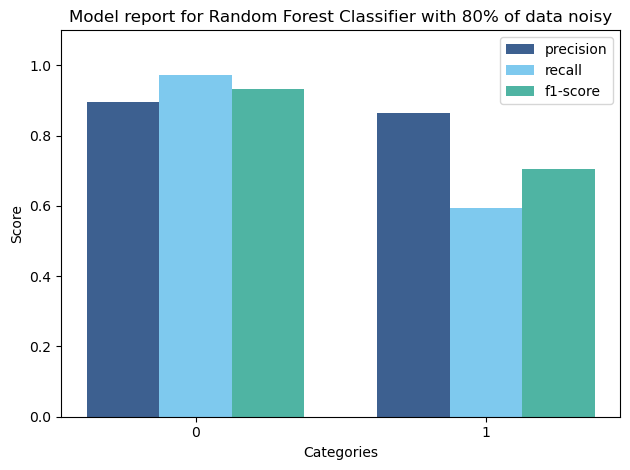

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     10533
           1       0.72      0.59      0.65      2967

    accuracy                           0.86     13500
   macro avg       0.80      0.76      0.78     13500
weighted avg       0.85      0.86      0.85     13500

Balanced accuracy:
0.7617245026152579
Feature importance ranking:
previous_loan_defaults_on_file    0.407373
loan_percent_income               0.186053
person_home_ownership             0.087136
loan_amnt                         0.048170
person_income                     0.048154
loan_int_rate                     0.043109
credit_score                      0.040529
person_age                        0.033515
loan_intent                       0.031154
person_emp_exp                    0.030641
cb_person_cred_hist_length        0.025498
person_education                  0.011906
person_gender                     0.006765
dtype: float64


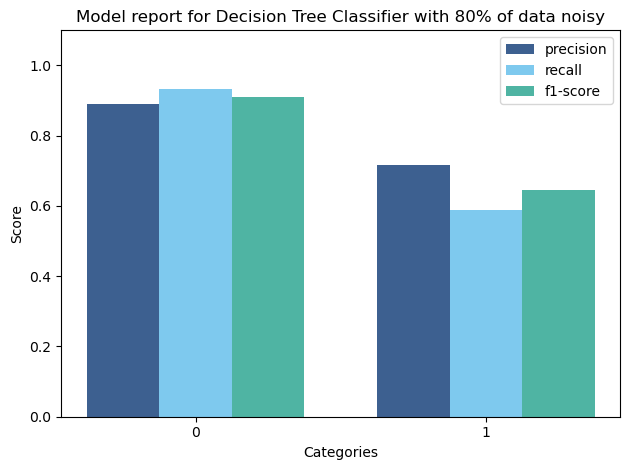

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.49995253014335894


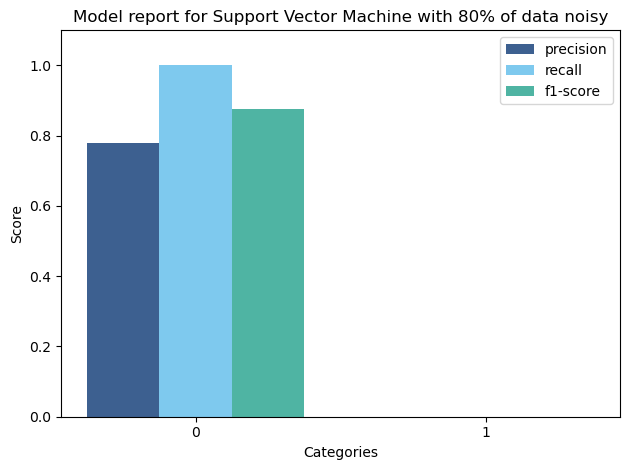

In [547]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(introduce_noisy_data,
                                   dirty_type = "noisy",
                                   file_suffix = "noisy")

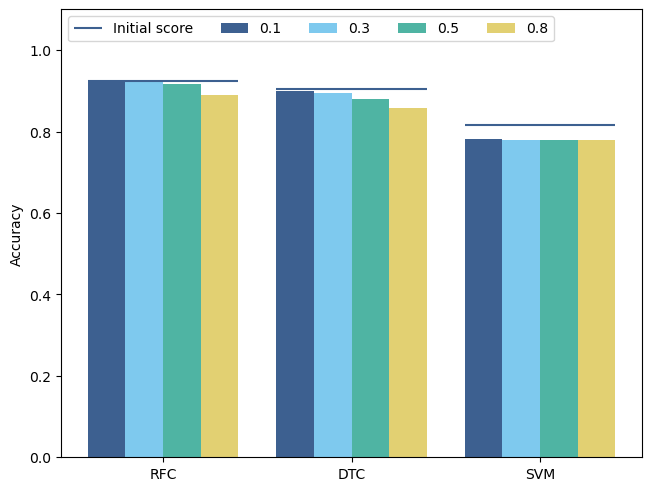

In [548]:
plot_model_accuracies(accuracies,
                      # title = "noisy",
                      filePrefix = "report_noisy")

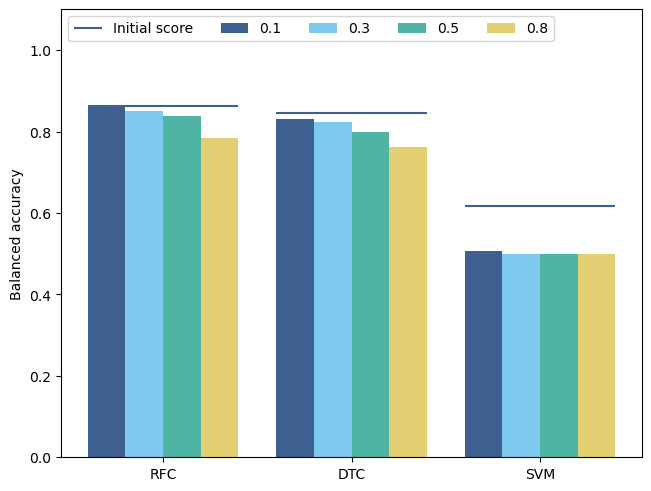

In [549]:
plot_model_accuracies(balanced_accuracies,
                      # title = "noisy",
                      filePrefix = "report_noisy_balanced",
                      balanced=True)

### Based on feature importance

In [550]:
def make_noisy_point(df, feature):
    """
    Numerical only ofc!
    """
    if rand.choice(2) == 0:
        res = df[feature].median() + rand.random() * 3 * df[feature].std()
    else:
        res = df[feature].median() - rand.random() * 3 * df[feature].std()
        
    return res

#### Running models

Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10533
           1       0.89      0.74      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8571162594866517
Feature importance ranking:
previous_loan_defaults_on_file    0.362592
person_income                     0.111315
loan_int_rate                     0.105137
loan_percent_income               0.094749
person_home_ownership             0.082399
loan_amnt                         0.071353
credit_score                      0.052657
loan_intent                       0.034130
person_age                        0.024331
person_emp_exp                    0.021693
cb_person_cred_hist_length        0.020207
person_education                  0.012803
person_gender           

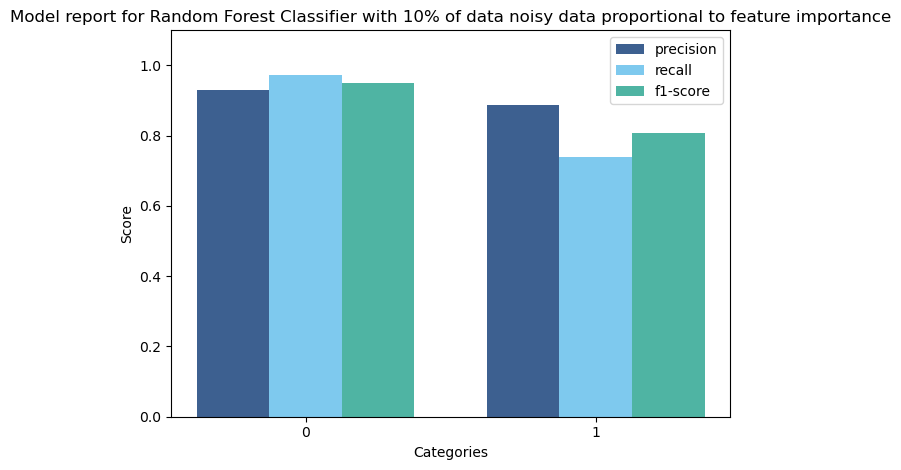

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10533
           1       0.78      0.69      0.73      2967

    accuracy                           0.89     13500
   macro avg       0.85      0.82      0.83     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8183021880196065
Feature importance ranking:
previous_loan_defaults_on_file    0.301881
person_income                     0.120695
loan_percent_income               0.117760
loan_amnt                         0.096129
loan_int_rate                     0.089862
person_home_ownership             0.083298
credit_score                      0.053643
loan_intent                       0.036390
person_age                        0.029179
cb_person_cred_hist_length        0.026718
person_emp_exp                    0.025192
person_education                  0.013262
person_gender                     0.005991
dtype: float64


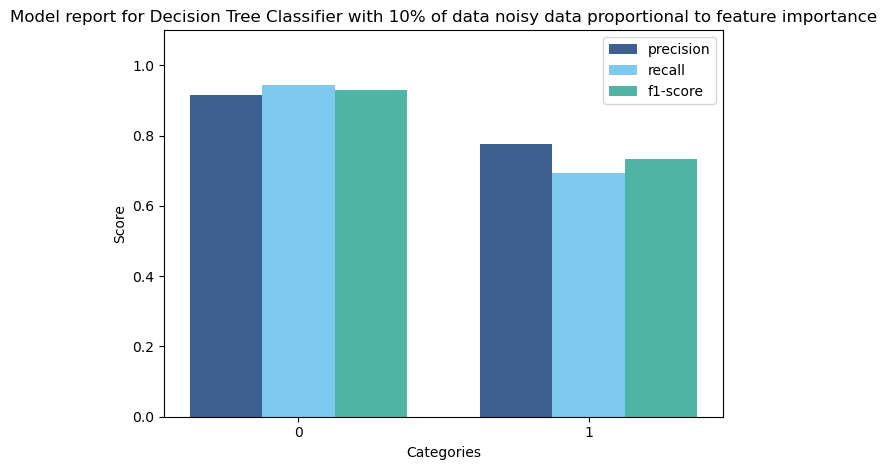

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.67      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.72      0.50      0.44     13500
weighted avg       0.76      0.78      0.68     13500

Balanced accuracy:
0.5002895709252936


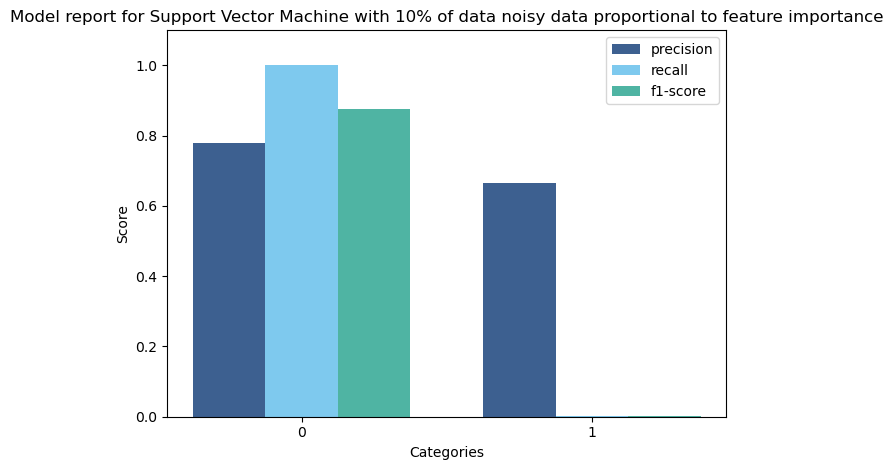

Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     10533
           1       0.83      0.67      0.74      2967

    accuracy                           0.90     13500
   macro avg       0.87      0.82      0.84     13500
weighted avg       0.90      0.90      0.89     13500

Balanced accuracy:
0.8175686371408958
Feature importance ranking:
previous_loan_defaults_on_file    0.424811
person_home_ownership             0.090783
person_income                     0.080134
loan_amnt                         0.070792
loan_percent_income               0.061986
loan_int_rate                     0.061834
credit_score                      0.059973
loan_intent                       0.034691
person_age                        0.034158
person_emp_exp                    0.030318
cb_person_cred_hist_length        0.027731
person_education                  0.015194
person_gender           

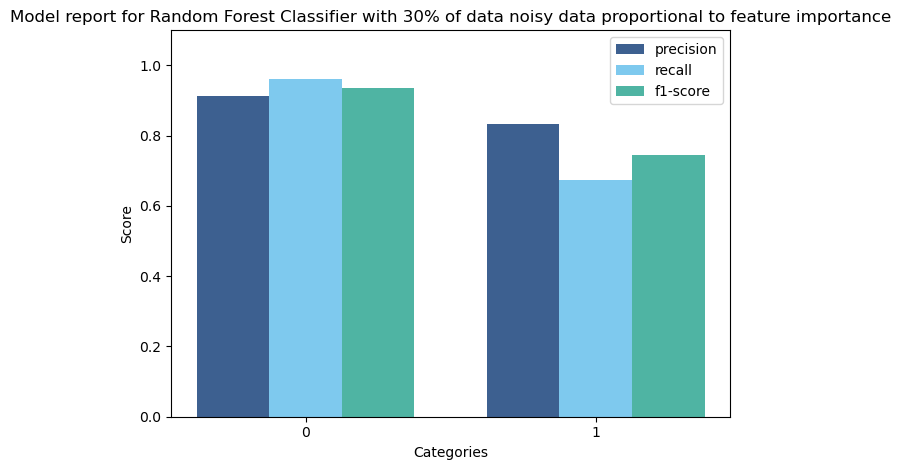

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     10533
           1       0.72      0.63      0.67      2967

    accuracy                           0.86     13500
   macro avg       0.81      0.78      0.79     13500
weighted avg       0.86      0.86      0.86     13500

Balanced accuracy:
0.7811589691102268
Feature importance ranking:
previous_loan_defaults_on_file    0.411974
person_home_ownership             0.090424
person_income                     0.071503
loan_percent_income               0.067659
loan_amnt                         0.066954
credit_score                      0.065548
loan_int_rate                     0.063947
person_age                        0.038415
loan_intent                       0.037371
person_emp_exp                    0.033398
cb_person_cred_hist_length        0.030208
person_education                  0.015419
person_gender                     0.007182
dtype: float64


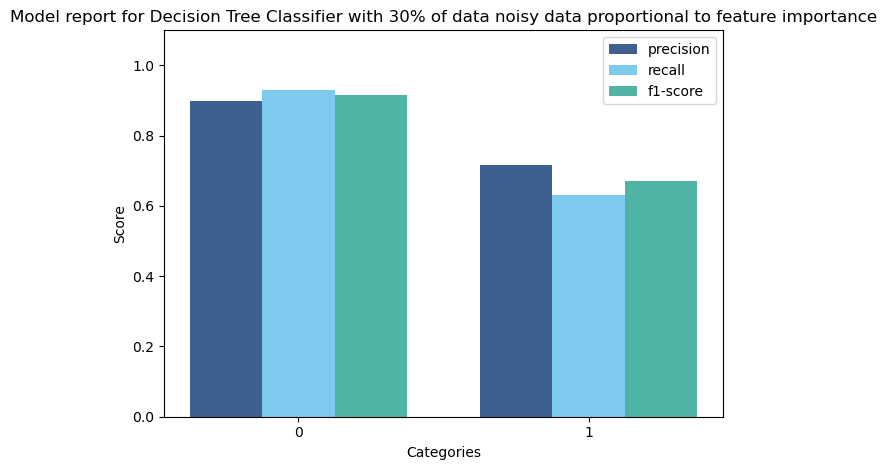

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.33      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.56      0.50      0.44     13500
weighted avg       0.68      0.78      0.68     13500

Balanced accuracy:
0.5000735806776853


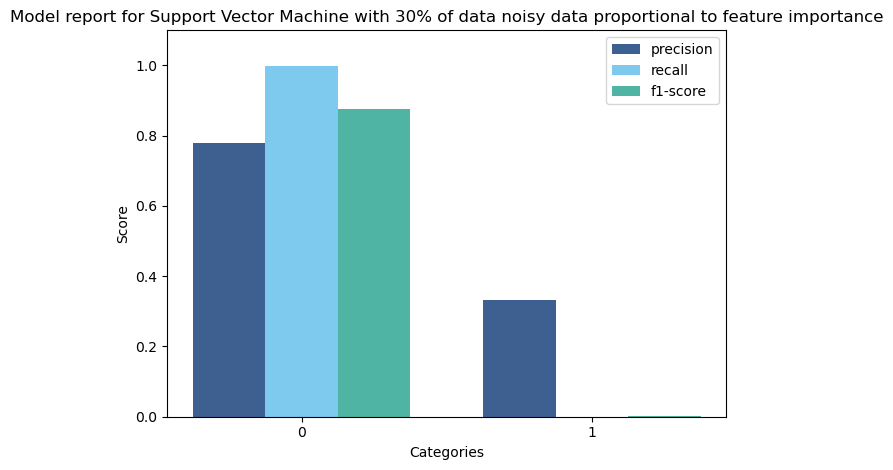

Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     10533
           1       0.78      0.65      0.71      2967

    accuracy                           0.88     13500
   macro avg       0.84      0.80      0.82     13500
weighted avg       0.88      0.88      0.88     13500

Balanced accuracy:
0.7968241177974332
Feature importance ranking:
previous_loan_defaults_on_file    0.449267
person_home_ownership             0.097634
loan_amnt                         0.064188
person_income                     0.063915
credit_score                      0.058917
loan_int_rate                     0.055021
loan_percent_income               0.053979
person_age                        0.037169
loan_intent                       0.035024
person_emp_exp                    0.031399
cb_person_cred_hist_length        0.030173
person_education                  0.015771
person_gender           

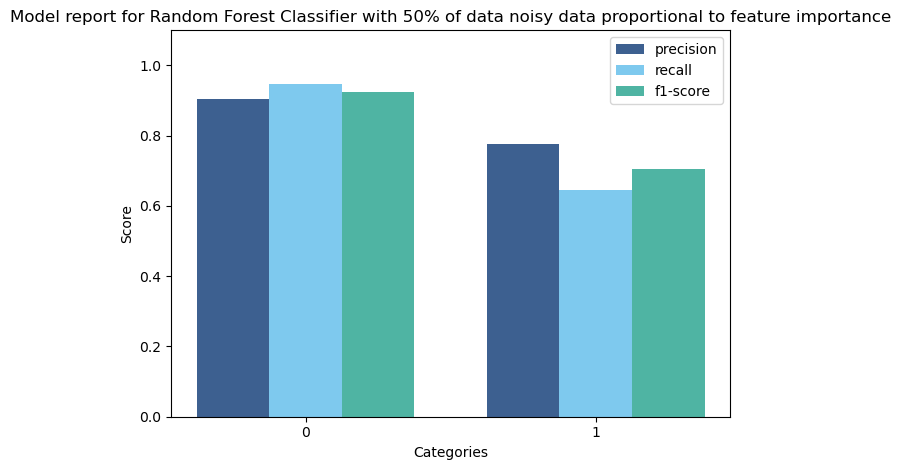

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     10533
           1       0.67      0.59      0.63      2967

    accuracy                           0.85     13500
   macro avg       0.78      0.75      0.77     13500
weighted avg       0.84      0.85      0.84     13500

Balanced accuracy:
0.7549292094363356
Feature importance ranking:
previous_loan_defaults_on_file    0.462433
person_home_ownership             0.104634
person_income                     0.060509
loan_amnt                         0.059044
loan_percent_income               0.056236
credit_score                      0.055214
loan_int_rate                     0.043273
person_age                        0.040266
loan_intent                       0.037157
person_emp_exp                    0.032663
cb_person_cred_hist_length        0.026676
person_education                  0.016543
person_gender                     0.005352
dtype: float64


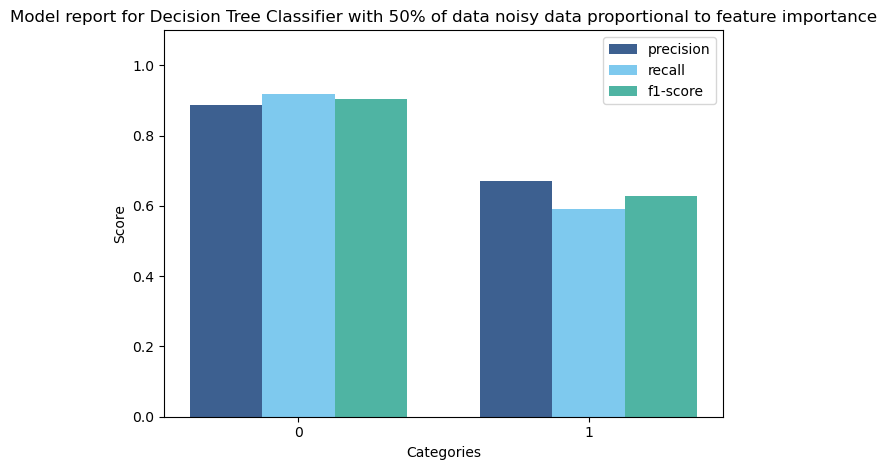

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       1.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.89      0.50      0.44     13500
weighted avg       0.83      0.78      0.68     13500

Balanced accuracy:
0.5001685203909673


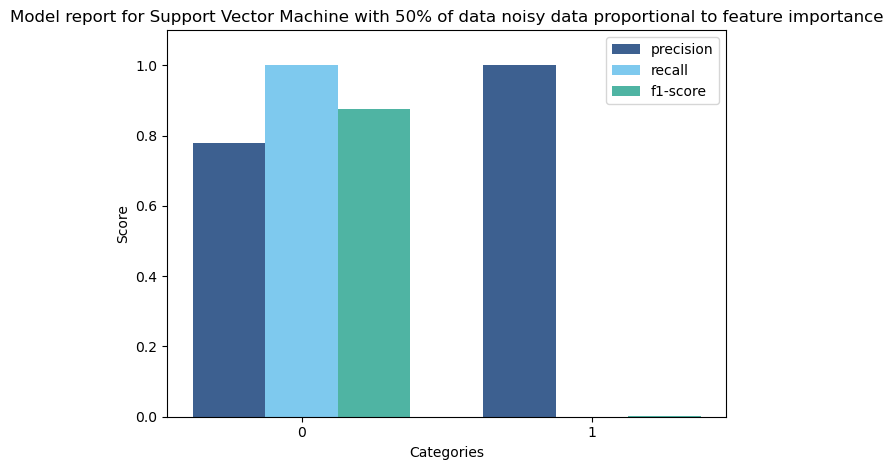

Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91     10533
           1       0.68      0.66      0.67      2967

    accuracy                           0.86     13500
   macro avg       0.79      0.79      0.79     13500
weighted avg       0.86      0.86      0.86     13500

Balanced accuracy:
0.7858064552669318
Feature importance ranking:
previous_loan_defaults_on_file    0.470761
person_home_ownership             0.101846
loan_amnt                         0.057773
credit_score                      0.054639
person_income                     0.053273
loan_int_rate                     0.051236
loan_percent_income               0.050731
person_age                        0.038615
loan_intent                       0.035357
cb_person_cred_hist_length        0.032479
person_emp_exp                    0.031211
person_education                  0.015282
person_gender           

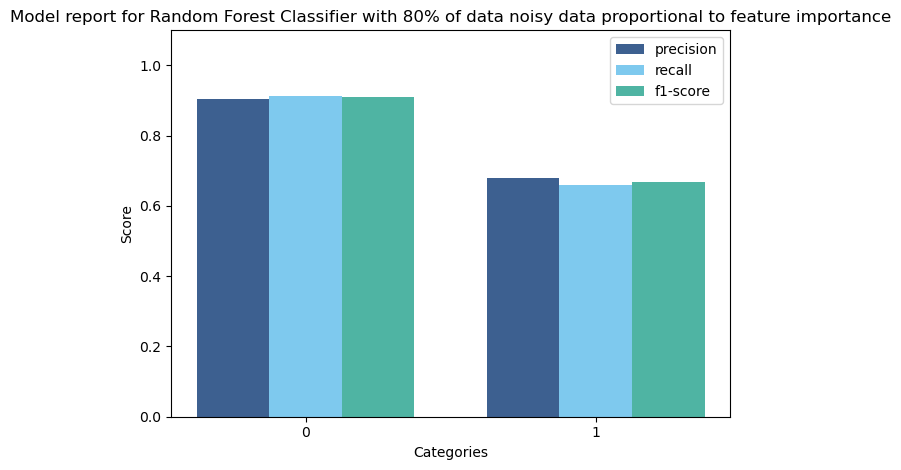

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     10533
           1       0.59      0.60      0.60      2967

    accuracy                           0.82     13500
   macro avg       0.74      0.74      0.74     13500
weighted avg       0.82      0.82      0.82     13500

Balanced accuracy:
0.7426630752768251
Feature importance ranking:
previous_loan_defaults_on_file    0.479894
person_home_ownership             0.104451
loan_amnt                         0.057395
person_income                     0.050656
credit_score                      0.049926
loan_percent_income               0.045816
loan_int_rate                     0.044484
person_age                        0.040375
person_emp_exp                    0.035408
loan_intent                       0.035109
cb_person_cred_hist_length        0.034836
person_education                  0.016351
person_gender                     0.005297
dtype: float64


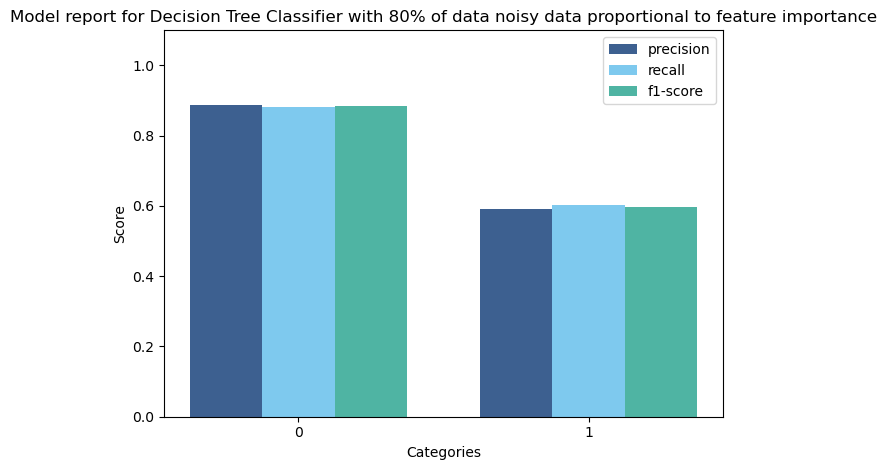

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.23      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.51      0.50      0.44     13500
weighted avg       0.66      0.78      0.68     13500

Balanced accuracy:
0.5000308626064917


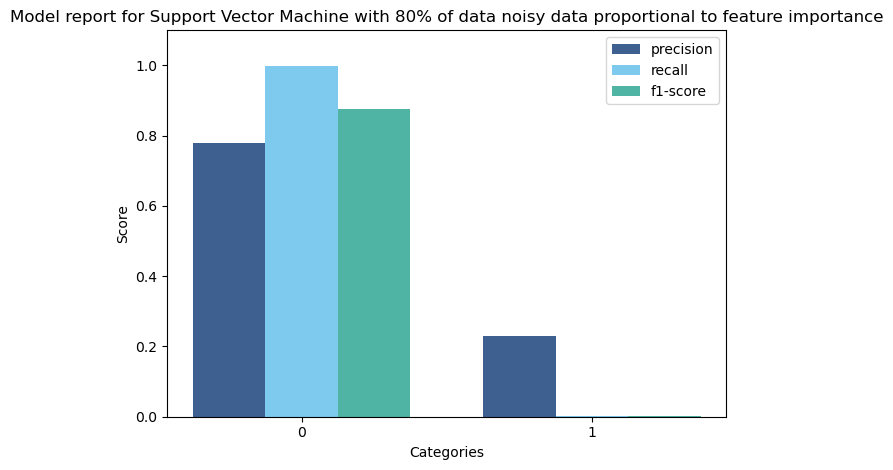

In [551]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(
    modify_entries_proportional_to_importance,
    feature_importance = feature_importance_rfc,
    dirty_type = "noisy data proportional to feature importance",
    file_suffix = "noisy_importance",
    aux_function = make_noisy_point
)

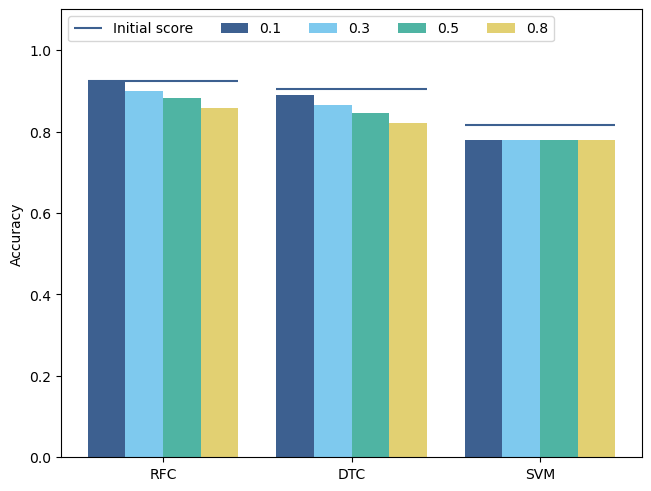

In [552]:
plot_model_accuracies(accuracies,
                      # title = "noisy",
                      filePrefix = "report_noisy_importance")

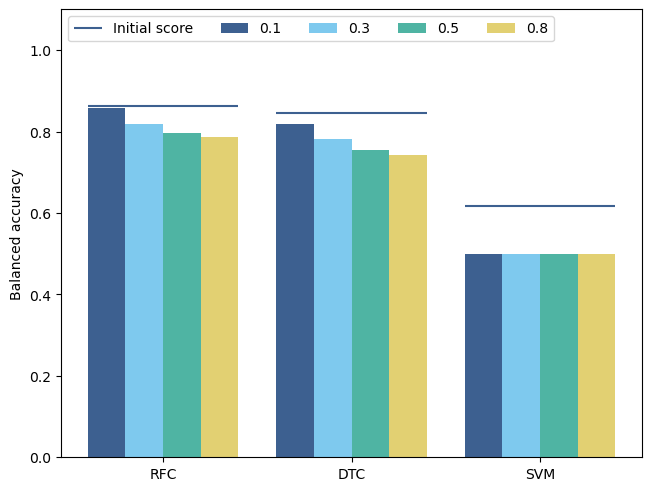

In [553]:
plot_model_accuracies(balanced_accuracies,
                      # title = "noisy",
                      filePrefix = "report_noisy_importance_balanced",
                      balanced=True)

### Based on feature importance - reversed

#### Running models

Dirty portion: 0.1
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10533
           1       0.89      0.74      0.81      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.86      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8574176858766474
Feature importance ranking:
previous_loan_defaults_on_file    0.333201
loan_percent_income               0.153897
loan_int_rate                     0.136078
person_income                     0.105069
person_home_ownership             0.070937
loan_amnt                         0.048520
credit_score                      0.041492
loan_intent                       0.029952
person_age                        0.023516
cb_person_cred_hist_length        0.021908
person_emp_exp                    0.020116
person_education                  0.010217
person_gender           

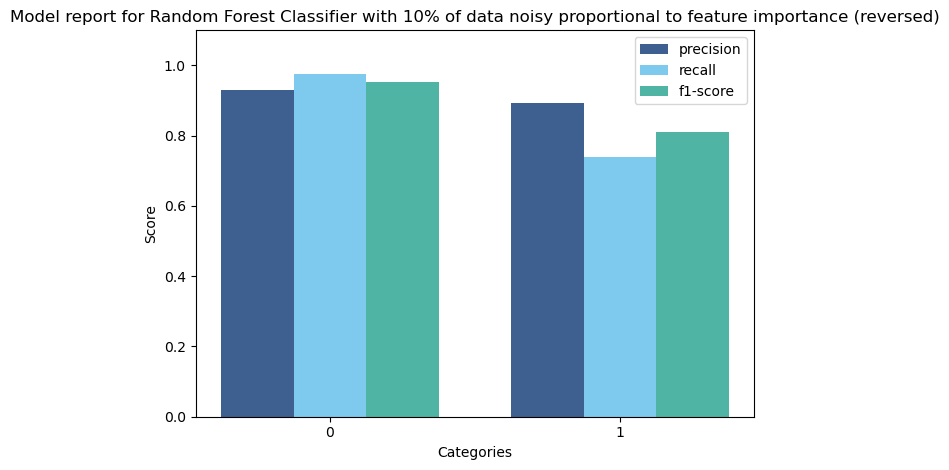

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10533
           1       0.81      0.71      0.76      2967

    accuracy                           0.90     13500
   macro avg       0.86      0.83      0.85     13500
weighted avg       0.90      0.90      0.90     13500

Balanced accuracy:
0.8332909512469693
Feature importance ranking:
previous_loan_defaults_on_file    0.348316
loan_int_rate                     0.150820
person_income                     0.116292
loan_percent_income               0.109423
person_home_ownership             0.052776
loan_amnt                         0.051886
credit_score                      0.045002
person_age                        0.029994
loan_intent                       0.026663
person_emp_exp                    0.025732
cb_person_cred_hist_length        0.023751
person_education                  0.014245
person_gender                     0.005099
dtype: float64


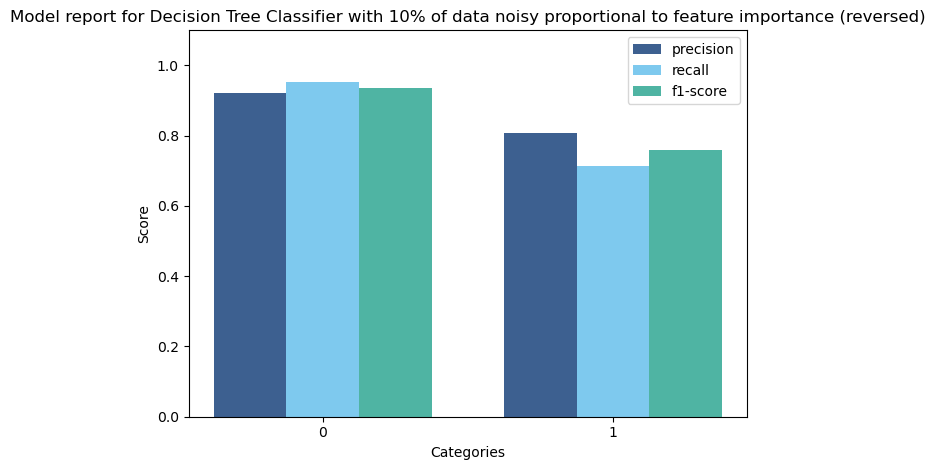

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.67      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.72      0.50      0.44     13500
weighted avg       0.76      0.78      0.68     13500

Balanced accuracy:
0.5002895709252936


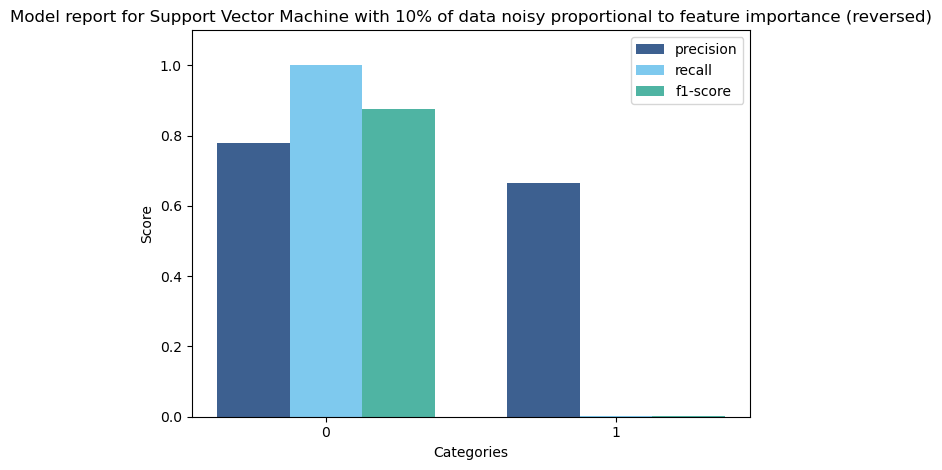

Dirty portion: 0.3
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     10533
           1       0.90      0.72      0.80      2967

    accuracy                           0.92     13500
   macro avg       0.91      0.85      0.88     13500
weighted avg       0.92      0.92      0.92     13500

Balanced accuracy:
0.8499149526400585
Feature importance ranking:
previous_loan_defaults_on_file    0.378189
loan_percent_income               0.116643
loan_int_rate                     0.094622
person_home_ownership             0.083255
person_income                     0.081842
loan_amnt                         0.051523
credit_score                      0.044595
person_age                        0.034807
cb_person_cred_hist_length        0.034196
loan_intent                       0.032189
person_emp_exp                    0.029065
person_education                  0.012856
person_gender           

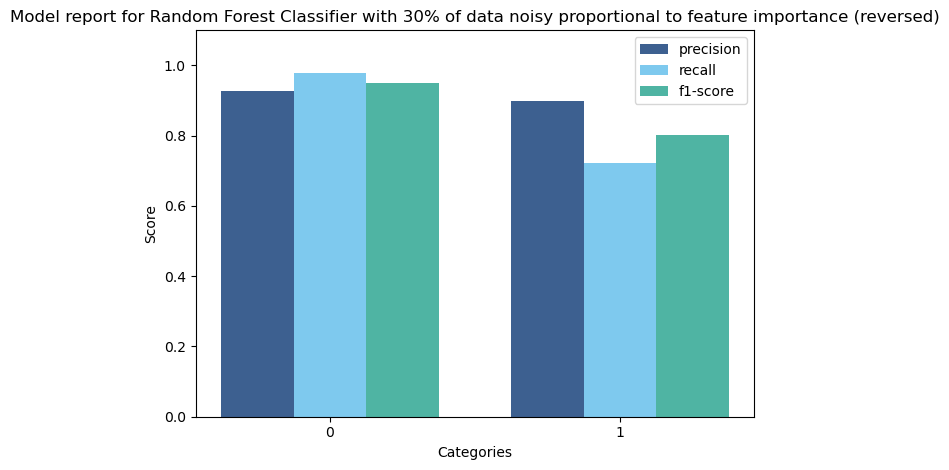

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     10533
           1       0.78      0.69      0.73      2967

    accuracy                           0.89     13500
   macro avg       0.85      0.82      0.83     13500
weighted avg       0.89      0.89      0.89     13500

Balanced accuracy:
0.8186463324807958
Feature importance ranking:
previous_loan_defaults_on_file    0.356985
loan_percent_income               0.107981
loan_int_rate                     0.100239
person_home_ownership             0.085408
person_income                     0.083905
loan_amnt                         0.057426
credit_score                      0.050749
cb_person_cred_hist_length        0.042875
person_emp_exp                    0.034011
person_age                        0.031754
loan_intent                       0.027977
person_education                  0.013234
person_gender                     0.007455
dtype: float64


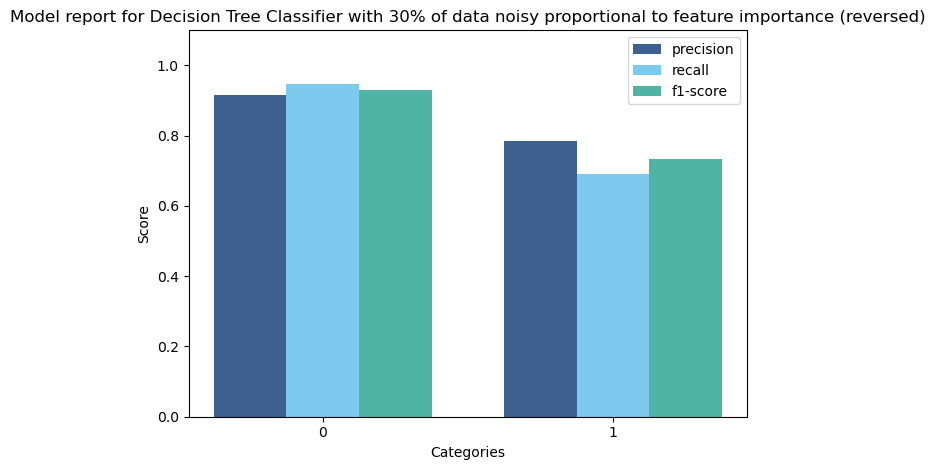

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.00      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.39      0.50      0.44     13500
weighted avg       0.61      0.78      0.68     13500

Balanced accuracy:
0.5


/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/AD/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

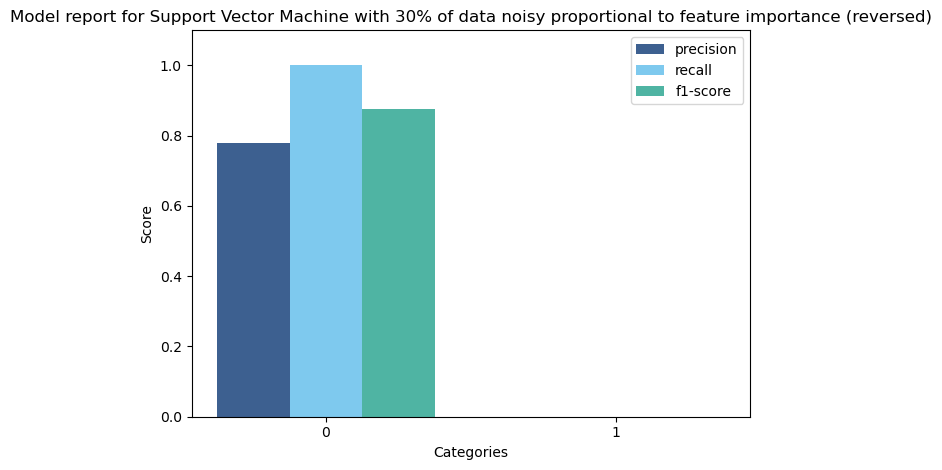

Dirty portion: 0.5
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     10533
           1       0.85      0.71      0.77      2967

    accuracy                           0.91     13500
   macro avg       0.88      0.84      0.86     13500
weighted avg       0.91      0.91      0.90     13500

Balanced accuracy:
0.8365544678926657
Feature importance ranking:
previous_loan_defaults_on_file    0.406988
loan_percent_income               0.090396
person_home_ownership             0.088234
loan_int_rate                     0.071524
person_income                     0.070648
loan_amnt                         0.052147
credit_score                      0.047575
person_age                        0.042781
cb_person_cred_hist_length        0.041710
person_emp_exp                    0.033482
loan_intent                       0.032865
person_education                  0.014773
person_gender           

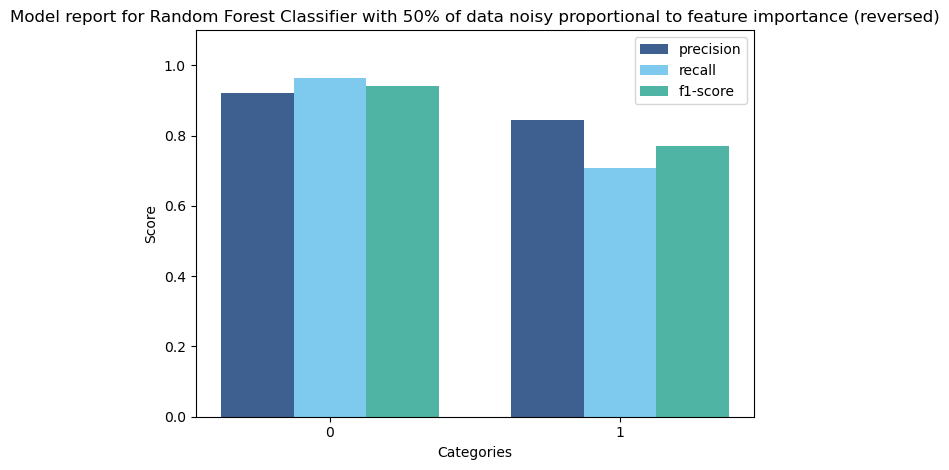

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     10533
           1       0.75      0.63      0.68      2967

    accuracy                           0.87     13500
   macro avg       0.82      0.78      0.80     13500
weighted avg       0.87      0.87      0.87     13500

Balanced accuracy:
0.7848426107864378
Feature importance ranking:
previous_loan_defaults_on_file    0.353931
loan_percent_income               0.119609
person_home_ownership             0.089324
loan_int_rate                     0.078380
person_income                     0.062121
loan_amnt                         0.057614
credit_score                      0.053350
person_age                        0.050428
cb_person_cred_hist_length        0.047669
person_emp_exp                    0.032552
loan_intent                       0.031891
person_education                  0.016583
person_gender                     0.006547
dtype: float64


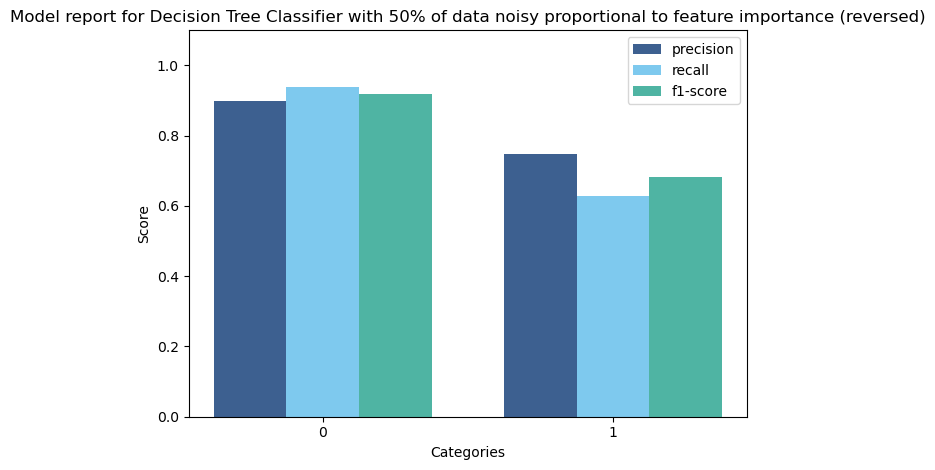

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.67      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.72      0.50      0.44     13500
weighted avg       0.76      0.78      0.68     13500

Balanced accuracy:
0.5002895709252936


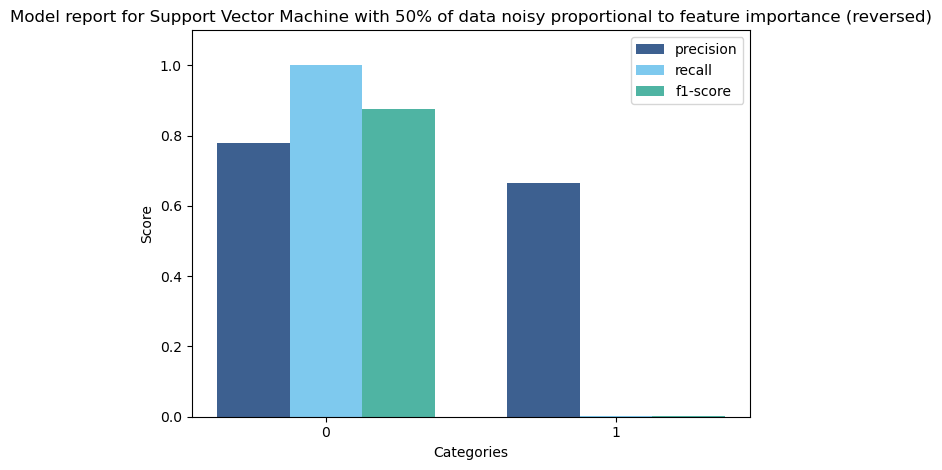

Dirty portion: 0.8
Missing percentage: 0.0%
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     10533
           1       0.81      0.68      0.74      2967

    accuracy                           0.90     13500
   macro avg       0.86      0.82      0.84     13500
weighted avg       0.89      0.90      0.89     13500

Balanced accuracy:
0.8200442693611498
Feature importance ranking:
previous_loan_defaults_on_file    0.431338
person_home_ownership             0.093266
loan_percent_income               0.076000
loan_int_rate                     0.060535
person_income                     0.059364
loan_amnt                         0.050441
credit_score                      0.047015
person_age                        0.046978
cb_person_cred_hist_length        0.045268
person_emp_exp                    0.035401
loan_intent                       0.033228
person_education                  0.014288
person_gender           

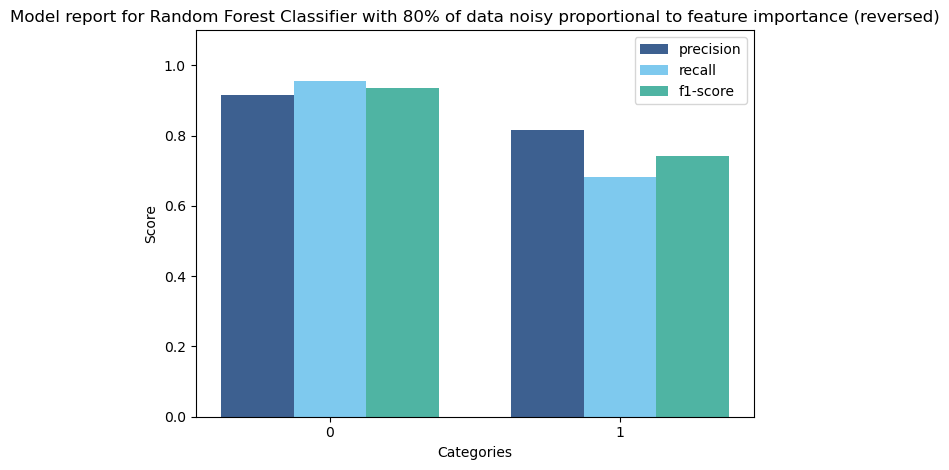

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     10533
           1       0.74      0.61      0.67      2967

    accuracy                           0.87     13500
   macro avg       0.82      0.78      0.79     13500
weighted avg       0.86      0.87      0.86     13500

Balanced accuracy:
0.7765590008079954
Feature importance ranking:
previous_loan_defaults_on_file    0.385415
person_home_ownership             0.088862
loan_percent_income               0.077071
loan_int_rate                     0.068852
person_income                     0.068784
credit_score                      0.058231
loan_amnt                         0.052235
cb_person_cred_hist_length        0.051591
person_age                        0.047691
person_emp_exp                    0.043927
loan_intent                       0.037265
person_education                  0.014352
person_gender                     0.005724
dtype: float64


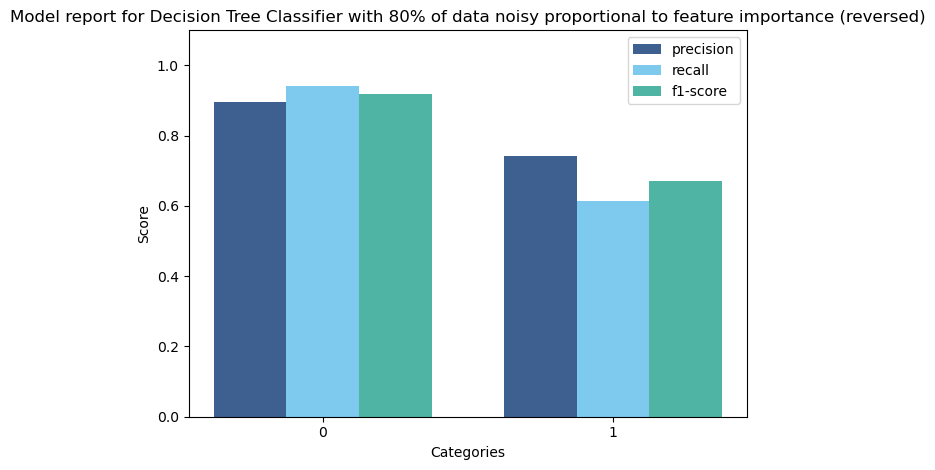

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     10533
           1       0.50      0.00      0.00      2967

    accuracy                           0.78     13500
   macro avg       0.64      0.50      0.44     13500
weighted avg       0.72      0.78      0.68     13500

Balanced accuracy:
0.5001210505343262


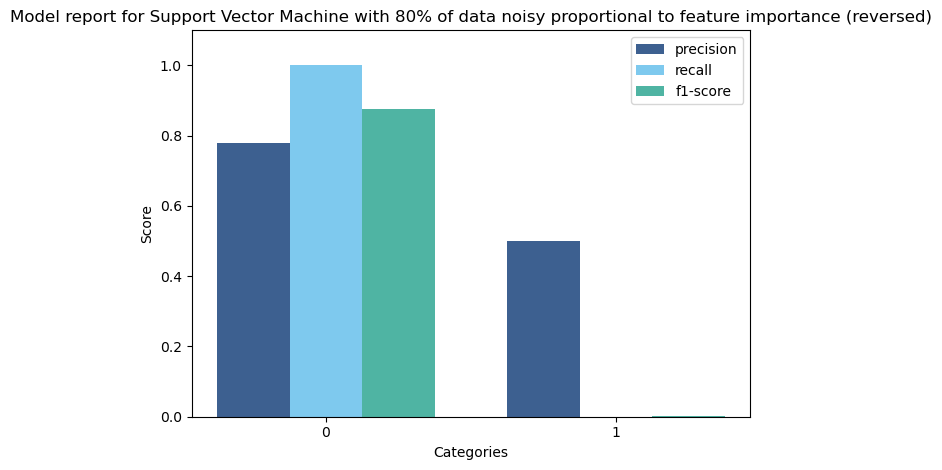

In [554]:
accuracies, balanced_accuracies = run_models_with_portion_dirty_data(
    modify_entries_proportional_to_importance,
    feature_importance = inverted_feature_importances,
    dirty_type = "noisy proportional to feature importance (reversed)",
    file_suffix = "noisy_importance_reversed",
    aux_function = make_noisy_point
)

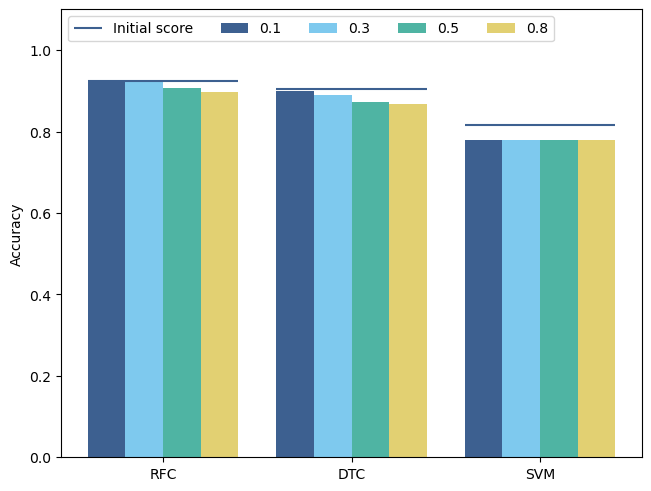

In [555]:
plot_model_accuracies(accuracies,
                      # title = "noisy",
                      filePrefix = "report_noisy_importance_reversed")

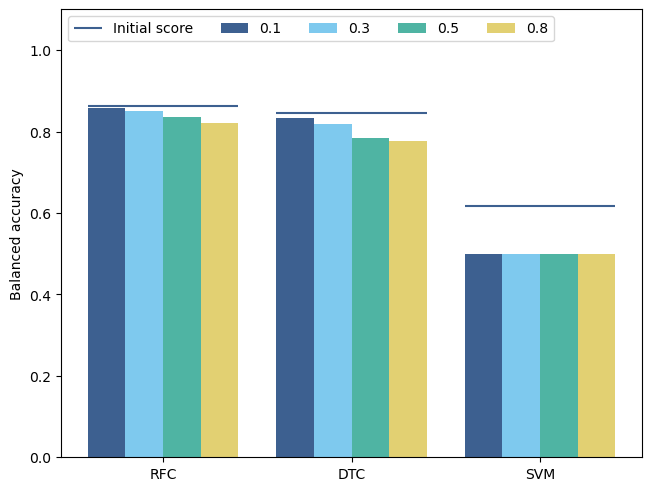

In [556]:
plot_model_accuracies(balanced_accuracies,
                      # title = "noisy",
                      filePrefix = "report_noisy_importance_reversed_balanced",
                      balanced=True)